# Data analysis and processing

This file generates the working database.

## Info

Anton van der Esch created and uploaded this notebook to GitHub. It contains the data analysis and processing in an ongoing study to determine the accuracy of formulas for predicting crack width and spacing.

First, the database "*crack width and crack spacing in reinforced and prestressed concrete elements: database*" (https://zenodo.org/records/14516072) is imported. The parameters in this database are described in "*crack width and crack spacing in reinforced and prestressed concrete elements: data description and acquisition" (https://www.sciencedirect.com/science/article/pii/S2352340924002749). Then, parameters are extracted from and added to the database. The added database is used in an ongoing study of the accuracy of formulas for predicting crack width and spacing. Please read the licence.

For the calculation of variables is referred to a different Jupyter Notebook.

Contact info:\
-antonvanderesch@hotmail.com or i.a.v.d.esch@tue.nl \
-Notebook created on 2025-01-11

## Contents

This notebook consists of several sections:\
00 - Import Packages \
01 - Settings \
02 - Import database and prepare data \
03 - Set DF types and extract additional data types \
04 - Inspect target variables \
05 - Functions to derive variables from the database \
06 - Specifications database, including extracted parameters \
07 - Selected crack width formulas

## 00 - Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

from pathlib import Path
import ast

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

from sklearn.metrics import r2_score 

from contextlib import suppress

from scipy.stats import norm
from scipy.stats import lognorm
from sklearn.metrics import root_mean_squared_error

import time

## 01 - Settings

In [2]:
Ncond = 15;
Nint = 100;
g = 9.81;
timecutoff = 30; # Transition from short to long term
Nrepcutoff = 20; # Transition from static to repeated loading
chi = 0.8; # Aeging factor

importsigs = "no"; # Choice to import steel stress calculation from previous calculation --> save tremendous time
importdat = "no";

hordijksigs = "yes"; # Include Hordijk tension softening

includeinitshrinkage = "yes"; # Include initial shrinkage in the calculations
globalfilterstress = "yes"; # Filters for the steel stress on the complete database!
sigslower = 150; # Lower bound for the steel stress to keep datapoint
sigsupper = 350; # Upper bound for the steel stress to keep datapoint
exclude_secondary_cracks = "yes";
filtercrackingplateau = "yes";

targetimputation = "no"; # Impute mean crack spacings based on known values?
Ncracksub = 4; # Only imputation if at least Ncracksub + 1 are present (for imputation of the mean crack spacing)

uniformtargets = "no"; # Express all crack widths as wmax and all spacings as srmax

tol = 0.01; # Tolerance used

fitleroutliers = "no";
wmaxU = 0.5; # Cut-off limiet gemiddelde en maximale scheurwijdte
smaxU = 400; # Cut-off limiet gemiddelde en maximale scheurafstand

ignorewarnings = "yes";

# Filter on the lengths
filter_length = 500; # Filter out considered lengths equal and smaller than .....

In [3]:
if ignorewarnings == "yes":
    import warnings
    warnings.filterwarnings('ignore');

## 02 - Import and prepare data

### 02.01 - Import data

In [4]:
motherpath = Path(r"C:\Users/20210065/OneDrive - TU Eindhoven/60_Publications/");
df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\New\Database\orgsize_expanded_features\df_master_sorted.csv"));

In [5]:
print("Number of datapoints",df.shape[0]);
print("Number of tested elements",df['ELID'].nunique());

Number of datapoints 6725
Number of tested elements 488


In [6]:
print("Number of elements loaded in tension",df[df["epsin"] == str("1a")]["ELID"].nunique());
print("Number of elements loaded in tension",df[df["epsin"] == str("1b")]["ELID"].nunique());
print("Number of elements loaded in bending",df[df["epsin"] == str("2")]["ELID"].nunique());
print("Number of elements with prestressing",df[(df["epsin"] == str("3")) & (df["Ap"] != 0)]["ELID"].nunique());
print("Number of elements with eccentric tension",df[(df["epsin"] == str("3")) & (df["Ap"] == 0)]["ELID"].nunique());

Number of elements loaded in tension 257
Number of elements loaded in tension 6
Number of elements loaded in bending 161
Number of elements with prestressing 64
Number of elements with eccentric tension 0


In [7]:
df.drop(df[(df["ELID"] == "A-FPhs/f1-5")].index, inplace=True); # Contains steel fibres outside constant bending moment
df.drop(df[(df["ELID"] == "A-PPhs/f1-5")].index, inplace=True); # Contains steel fibres outside constant bending moment
df.drop(df[(df["EPID"] == 9)].index, inplace=True); # Bennet; too little info known for further analysis
df.drop(df[(df["EPID"] == 22)].index, inplace=True); # Dawood; bi-axial loading, outside scope
df.drop(df[(df["EPID"] == 26)].index, inplace=True); # Heuveln; lightweight concrete

df.drop(df[(df["ELID"] == "1B1a")].index, inplace=True); # Excentric tension
df.drop(df[(df["ELID"] == "2B1a")].index, inplace=True); # Excentric tension
df.drop(df[(df["ELID"] == "3B1a")].index, inplace=True); # Excentric tension
df.drop(df[(df["ELID"] == "1C1a")].index, inplace=True); # Excentric tension
df.drop(df[(df["ELID"] == "3C1a")].index, inplace=True); # Excentric tension

# Contains likely measurement errors
df.drop(df[(df["ELID"] == "S1UND")].index, inplace=True);

# Contains likely measurement errors
df.drop(df[(df["ELID"] == "250-20-2")].index, inplace=True);

# Data files inconsistent with the thesis
df.drop(df[(df["ELID"] == "350-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "350-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "350-10-3")].index, inplace=True);

# Remove elements containing high-strength concrete
df.drop(df[(df["ELID"] == "H50-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-10-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-14-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-14-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-14-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-20-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-20-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "H50-20-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-14-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-14-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-14-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "H52-20-1")].index, inplace=True);

# Unrealistic values
df.drop(df[(df["ELID"] == "S20-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "S20-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "S22-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "S22-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "S22-10-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "S30-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "S30-10-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "S30-10-3")].index, inplace=True);
df.drop(df[(df["ELID"] == "S32-10-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "S32-10-2")].index, inplace=True);

# Unrealistic crack widths
df.drop(df[(df["ELID"] == "C210")].index, inplace=True);

# Unrealistic crack widths; possibly yielding
df.drop(df[(df["ELID"] == "1C2a")].index, inplace=True);
df.drop(df[(df["ELID"] == "3C2a")].index, inplace=True);
df.drop(df[(df["ELID"] == "3C2b")].index, inplace=True);

# Implicit calculation required to compute the section forces
df.drop(df[(df["ELID"] == "B8")].index, inplace=True);
df.drop(df[(df["ELID"] == "P7")].index, inplace=True);
df.drop(df[(df["ELID"] == "T16")].index, inplace=True);

# Unrealistic crack widths
df.drop(df[(df["ELID"] == "T-C3-1")].index, inplace=True);
df.drop(df[(df["ELID"] == "T-C3-2")].index, inplace=True);
df.drop(df[(df["ELID"] == "T-C3-4")].index, inplace=True);

# Unrealistic crack widths
df.drop(df[(df["ELID"] == "PL/201")].index, inplace=True);

# Secondary cracks + unrealistic crack widths
df.drop(df[(df["ELID"] == "T40")].index, inplace=True);
df.drop(df[(df["ELID"] == "T31")].index, inplace=True);
df.drop(df[(df["ELID"] == "T13")].index, inplace=True);
df.drop(df[(df["ELID"] == "T39")].index, inplace=True);
df.drop(df[(df["ELID"] == "T26")].index, inplace=True);
df.drop(df[(df["ELID"] == "T29")].index, inplace=True);
df.drop(df[(df["ELID"] == "T16")].index, inplace=True);

# Unrealistic crack widths and spacings
df.drop(df[(df["ELID"] == "R22")].index, inplace=True);
df.drop(df[(df["ELID"] == "R13")].index, inplace=True);
df.drop(df[(df["ELID"] == "R23")].index, inplace=True);
df.drop(df[(df["ELID"] == "R24")].index, inplace=True);
df.drop(df[(df["ELID"] == "R1")].index, inplace=True);
df.drop(df[(df["ELID"] == "R34")].index, inplace=True);
df.drop(df[(df["ELID"] == "R35")].index, inplace=True);
df.drop(df[(df["ELID"] == "R38")].index, inplace=True);
df.drop(df[(df["ELID"] == "R4")].index, inplace=True);
df.drop(df[(df["ELID"] == "R14")].index, inplace=True);
df.drop(df[(df["ELID"] == "R50")].index, inplace=True);
df.drop(df[(df["ELID"] == "R54")].index, inplace=True);
df.drop(df[(df["ELID"] == "R70")].index, inplace=True);
df.drop(df[(df["ELID"] == "R65")].index, inplace=True);
df.drop(df[(df["ELID"] == "R8")].index, inplace=True);
df.drop(df[(df["ELID"] == "R9")].index, inplace=True);
df.drop(df[(df["ELID"] == "R69")].index, inplace=True);
df.drop(df[(df["ELID"] == "R72")].index, inplace=True);

# Yielding of reinforcement
df.drop(df[(df["ELID"] == "2-32R2")].index, inplace=True);
df.drop(df[(df["ELID"] == "2-4.75R")].index, inplace=True); # Implicit calculation required to compute the section forces
df.drop(df[(df["ELID"] == "3-S3")].index, inplace=True); # Implicit calculation required to compute the section forces
df.drop(df[(df["ELID"] == "3-S4")].index, inplace=True); # Implicit calculation required to compute the section forces

In [8]:
# Below: keep elements needed for analysis CRC2025
df.drop(df[~df['ELID'].isin(["BSTS2-16","BSTS3-16","SSTS4-12","STN12","STN16","STS12","STS16",
                             "12-20-00","12-70-00","25-20-00","25-70-00","16-20-00F","16-20T","16-70-00F","16-70T","25-20T"
                            ])].index,inplace=True);

In [9]:
df.drop_duplicates(inplace=True);

In [10]:
print("Dataset contains",df.shape[0], "rows");
print("Dataset contains",df.shape[1], "columns");

Dataset contains 164 rows
Dataset contains 79 columns


In [11]:
df.rename(columns={"Unnamed: 0": "ID"},inplace=True);

In [12]:
df.reset_index(drop=True, inplace=True)

In [13]:
print("Number of tested elements",df['ELID'].nunique());

Number of tested elements 16


### 02.02 - Impute data

Estimate the values of $f_{p01k}$, which are unknown in some experimental programs, from $f_{\text{pk}}$.

#### EPID 14

$f_{\text{pk}}$ is known, $f_{\text{p}01\text{k}}$ is estimated using EN 10138: $f_{\text{p}01\text{k}} = 0.9 \cdot f_{\text{pk}}$

In [14]:
for i in range(df.shape[0]):
    if df["EPID"].iloc[i] == 14 and df["fpk"].iloc[i] > 1:
        df["fp01k"].iloc[i] = 0.9*df["fpk"].iloc[i];

#### EPID 17

$f_{\text{pk}}$ is known, $f_{\text{p}01\text{k}}$ is estimated using EN 10138: $f_{\text{p}01\text{k}} = 0.9 \cdot f_{\text{pk}}$

In [15]:
for i in range(df.shape[0]):
    if df["EPID"].iloc[i] == 17 and df["fpk"].iloc[i] > 1:
        df["fp01k"].iloc[i] = 0.9*df["fpk"].iloc[i];

### 02.03 Change target type of EPID28

Characteristic crack widths $w_{\text{k}}$ will be considered as maximum crack widths $w_{\text{max}}$.

In [16]:
for i in range(df.shape[0]):
    if df["EPID"].iloc[i] == 28:
        if df["wk"].iloc[i] > 0.001:
            df["wmax"].iloc[i] = df["wk"].iloc[i];

for i in range(df.shape[0]):
    if df["EPID"].iloc[i] == 28:
        df["wk"].iloc[i] = 0;

## 03 - Set DF types and extract additional data types

### 03.01 - Functions

Function to extract concrete properties from the imported database.

In [17]:
def func_extract_prop(data,var):

    Nrow = data.shape[0];
    hc = np.zeros((Nrow,Ncond));

    for i in range(Nrow):
        hctemp = ast.literal_eval(data[var].iloc[i]);
        Nhc = np.shape(hctemp)[0];
        
        for j in range(Nhc):
            hc[i,j] = float(hctemp[j]);

    return hc

Function to extract concrete properties from the variable $\text{cat}_{\text{fcm}}$.

In [18]:
def func_extract_catfcm(data):

    Nrowele = data.shape[0];
    
    col = ["Shape","Dim","Treat"];
    catfcm = pd.DataFrame(np.zeros((Nrowele,len(col))),columns=col);

    for i in range(data.shape[0]):
        for j in range(len(col)):
            catfcm[col[j]].iloc[i] = data["catfcm"].iloc[i].strip("[]").split(",")[j];

    fcm_shape = catfcm["Shape"].astype(int);
    fcm_dim = catfcm["Dim"].astype(str);
    fcm_treat = catfcm["Treat"].astype(int);

    return fcm_shape, fcm_dim, fcm_treat

Function to extract concrete properties from the variable $\text{cat}_{\text{fctm}}$.

In [19]:
def func_extract_catfctm(data):

    Nrowele = data.shape[0];
    
    col = ["Shape","Dim","Test"];
    catfctm = pd.DataFrame(np.zeros((Nrowele,len(col))),columns=col);

    for i in range(data.shape[0]):
        for j in range(len(col)):
            catfctm[col[j]].iloc[i] = data["catfctm"].iloc[i].strip("[]").split(",")[j];

    fctm_shape = catfctm["Shape"].astype(int);
    fctm_dim = catfctm["Dim"].astype(str);
    fctm_test = catfctm["Test"].astype(int);

    return fctm_shape, fctm_dim, fctm_test

Function to extract concrete properties from the variable $\text{cat}_{\text{Ecm}}$.

In [20]:
def func_extract_catEcm(data):

    Nrowele = data.shape[0];
    
    col = ["Shape","Dim","Test"];
    catEcm = pd.DataFrame(np.zeros((Nrowele,len(col))),columns=col);

    for i in range(data.shape[0]):
        for j in range(len(col)):
            catEcm[col[j]].iloc[i] = data["catEcm"].iloc[i].strip("[]").split(",")[j];

    Ecm_shape = catEcm["Shape"].astype(int);
    Ecm_dim = catEcm["Dim"].astype(str);
    Ecm_test = catEcm["Test"].astype(int);

    return Ecm_shape, Ecm_dim, Ecm_test

Function to extract concrete properties from the variable $\text{mix}$.

In [21]:
def func_extract_mix(data):
    
    Nrowele = data.shape[0];
    
    col = ["CEM","classCEM","cons","clinker","w/c","dmax","typeagg","add","rho"];
    mix = pd.DataFrame(np.zeros((Nrowele,len(col))),columns=col);
    
    for i in range(Nrowele):
        for j in range(len(col)):
            mix[col[j]].iloc[i] = data["mix"].iloc[i].strip("[]").split(",")[j];

    CEM = mix["CEM"].astype(int);
    classCEM = mix["classCEM"].astype(int);
    cons = mix["cons"].astype(int);
    clinker = mix["clinker"].astype(int);
    wc = mix["w/c"].astype(float);
    dmax = mix["dmax"].astype(float);
    typeagg = mix["typeagg"].astype(int);
    add = mix["add"].astype(str);
    rho = mix["rho"].astype(float);

    return CEM, classCEM, cons, clinker, wc, dmax, typeagg, add, rho

### 03.02 - Metadata

In [22]:
df = df.astype({
    "EPID": "int64",
    "ELID": "string",
    "LOADID": "int64",
    "DOI": "string",
    "title": "string",
    "year": "int64",
    "journal": "string",
    "country": "string",
    "institution": "string",
    "laboratory": "string",
    "authors": "string"
});

### 03.03 - Geometry

In [23]:
df = df.astype({
    "Ltot": "float",
    "Lspan": "float",
    "Lcons": "float",
    "Lmeas": "float",
    "h": "float",
    "b": "string"
});

### 03.04 - Element preparations

In [24]:
df = df.astype({
    "hc": "string",
    "thc": "string",
    "RH": "string",
    "Temp": "string",
    "pd": "int64",
});

In [25]:
hc = func_extract_prop(df,"hc");
thc = func_extract_prop(df,"thc");
RH = func_extract_prop(df,"RH");
Temp = func_extract_prop(df,"Temp");

### 03.05 - Concrete

In [26]:
df = df.astype({
    "fcm": "string",
    "catfcm": "string",
    "tfcm": "string",
    "fctm": "string",
    "catfctm": "string",
    "tfctm": "string",
    "Ecm": "string",
    "catEcm": "string",
    "tEcm": "string",
    "mix": "string",
});

In [27]:
fcm = func_extract_prop(df,"fcm");
tfcm = func_extract_prop(df,"tfcm");
fctm = func_extract_prop(df,"fctm");
tfctm = func_extract_prop(df,"tfctm");
Ecm = func_extract_prop(df,"Ecm");
tEcm = func_extract_prop(df,"tEcm");

fcm_shape, fcm_dim, fcm_treat = func_extract_catfcm(df);
fctm_shape, fctm_dim, fctm_test = func_extract_catfctm(df);
Ecm_shape, Ecm_dim, Ecm_test = func_extract_catEcm(df);

CEM, classCEM, cons, clinker, wc, dmax, typeagg, add, rho = func_extract_mix(df);

### 03.06 - Reinforcing steel - longitudinal direction

In [28]:
df = df.astype({
    "Es": "float",
    "fsr": "int64",
    "fy": "float",
    "phi": "string",
    "zs": "string",
    "nbl": "string",
    "clat": "string"
});

In [29]:
phi = func_extract_prop(df,"phi");
zs = func_extract_prop(df,"zs");
nbl = func_extract_prop(df,"nbl");
clat = func_extract_prop(df,"clat")

### 03.07 - Reinforcing steel - transverse direction

In [30]:
df = df.astype({
    "phit": "string",
    "st": "string"
});

In [31]:
phit = func_extract_prop(df,"phit");
st = func_extract_prop(df,"st");

### 03.08 - Reinforcing steel - stirrups

In [32]:
df = df.astype({
    "phiw": "float",
    "sw": "float"
});

### 03.09 - Prestressing steel

In [33]:
df = df.astype({
    "type": "string",
    "method": "int64",
    "fpk": "float",
    "fp01k": "float",
    "Ep": "float",
    "rel": "int64",
    "fpr": "int64",
    "npl": "string",
    "phip": "string",
    "Ap": "string",
    "zp": "string",
    "cplat": "string"
});

In [34]:
npl = func_extract_prop(df,"npl");
phip = func_extract_prop(df,"phip");
Ap = func_extract_prop(df,"Ap");
zp = func_extract_prop(df,"zp");
cplat = func_extract_prop(df,"cplat");

### 03.10 - Test setup

In [35]:
df = df.astype({
    "catf": "int64",
    "epsin": "string",
    "catcal": "int64",
    "selfw": "int64",
    "typew": "int64",
    "locw": "int64"  
});

### 03.11 - Loads

In [36]:
df = df.astype({
    "LOADID": "int64",
    "epsc": "float",
    "Nrep": "int64",
    "N": "float",
    "M": "float",
    "sigs": "float",
    "t0": "int64",
    "t": "int64",
    "PL": "float",
    "catp": "int64",
    "t0p": "int64",
    "tp": "int64",
});

### 03.12 - Datapoints

In [37]:
df = df.astype({
    "ncr": "int64",
    "wm": "float",
    "wk": "float",
    "wmax": "float",
    "sm": "float",
    "smax": "float",
});

## 04 - Inspect the various variables

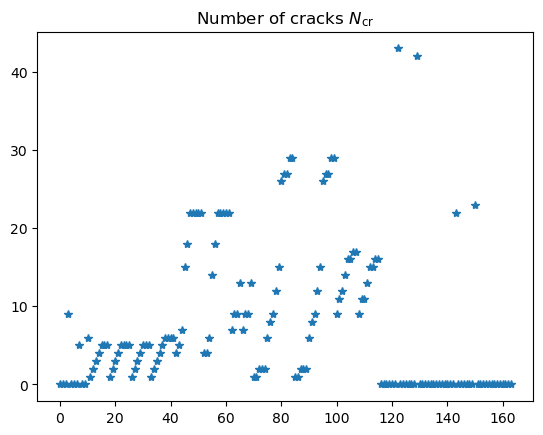

In [38]:
plt.figure();
plt.plot(df["ncr"],"*");
plt.title("Number of cracks $N_{\\rm{cr}}$");

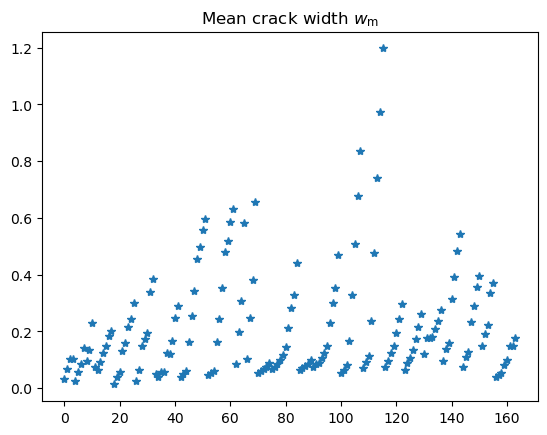

In [39]:
plt.figure();
plt.plot(df["wm"],"*");
plt.title("Mean crack width $w_{\\rm{m}}$");

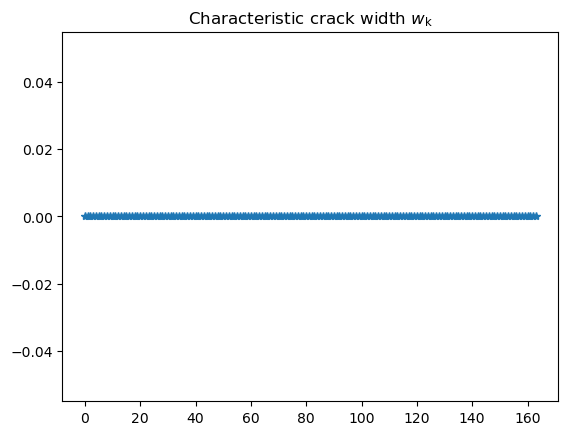

In [40]:
plt.figure();
plt.plot(df["wk"],"*");
plt.title("Characteristic crack width $w_{\\rm{k}}$");

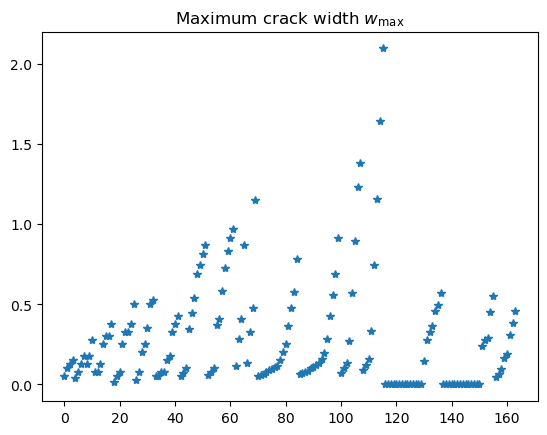

In [41]:
plt.figure();
plt.plot(df["wmax"],"*");
plt.title("Maximum crack width $w_{\\rm{max}}$");

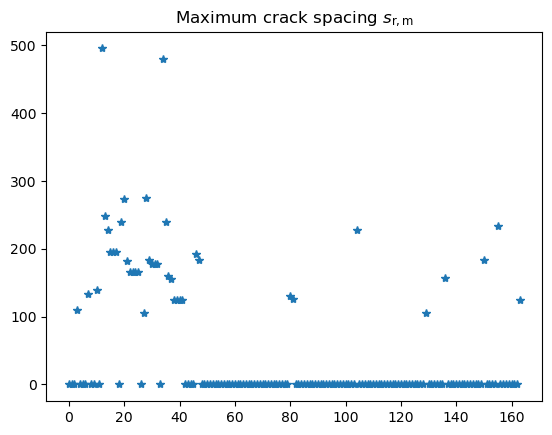

In [42]:
plt.figure();
plt.plot(df["sm"],"*");
plt.title("Maximum crack spacing $s_{\\rm{r,m}}$");

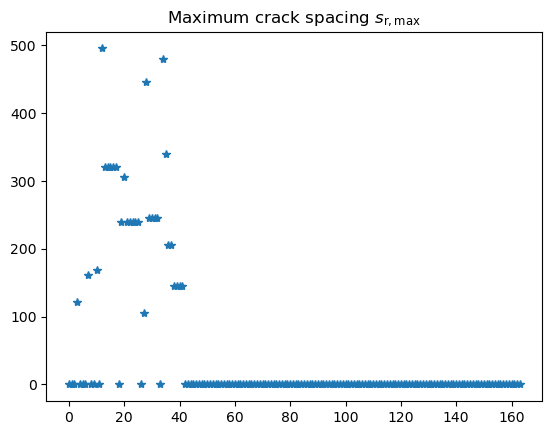

In [43]:
plt.figure();
plt.plot(df["smax"],"*");
plt.title("Maximum crack spacing $s_{\\rm{r,max}}$");

## 05 - Functions

### 05.01 - Nonzero layers

Function to inspect which elements in a array-type cell are empty. Returns last element that is not zero.

In [44]:
def func_cal_nonzero(data,var):
    nonzero = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        nonzero[i] = int(np.where(var[i,:]<0.001)[0][0]-1);
        
    return nonzero

In [45]:
df["indLR"] = func_cal_nonzero(df,zs);
df["indNP"] = func_cal_nonzero(df,zp);
df["indtfcm"] = func_cal_nonzero(df,tfcm);
df["indtfctm"] = func_cal_nonzero(df,tfctm);
df["indtEcm"] = func_cal_nonzero(df,tEcm);

df = df.astype({
    "indLR": "int",
    "indNP": "int",
    "indtfcm": "int",
    "indtfctm": "int",
    "indtEcm": "int"
});

### 05.02 - Functions to extract geometrical properties

#### Function to extract the section width of a string

In [46]:
def func_extract_width(z,bstr):

    # This function computes the widht of a cross-section, at a certain height
    bstr = str(bstr);
    tempstr = bstr.strip("[]");    
    nfunc = len(tempstr.split(","));
    
    # Create temparray to store different bounds, widths and heights
    if nfunc > 1:
        
        boundstore = np.zeros((2,nfunc)); # Lower resp. upper bound
        funcstore = [];
        
        for j in range(nfunc):
            boundstore[0,j] = float(tempstr.split(",")[j].split("if")[1].split("<z<")[0]);
            boundstore[1,j] = float(tempstr.split(",")[j].split("if")[1].split("<z<")[1]);
    
            def f(z):
                return float(eval(tempstr.split(",")[j].split("if")[0]));
            
            funcstore.append(f(z));
                    
        b = np.piecewise(
                        z,
                        [(z < boundstore[1,j]) & (z >= boundstore[0,j]) for j in range(nfunc)],funcstore);
  
    else:
        b = float(eval(bstr));

    return b

#### Function to calculate the concrete area (including reinforcing steel)

In [47]:
def func_cal_Ac(data):
   
    Ac = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        Ac[i] = quad(func_extract_width,0,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
    
    return Ac

In [48]:
df["Ac"] = func_cal_Ac(df);
df = df.astype({
    "Ac": "float"
});

#### Computation of total reinforcing steel

In [49]:
def func_cal_Astot(data):
    Astot = np.zeros(data.shape[0]);
    for i in range(data.shape[0]):
        Aslayer = np.zeros(Ncond);
        for j in range(Ncond):
            Aslayer[j] = nbl[i,j]*(1/4)*np.pi*(phi[i,j]**2);

        Astot[i] = sum(Aslayer);
        
    return Astot

In [50]:
df["Astot"] = func_cal_Astot(df);
df = df.astype({
    "Astot": "float"
});

### 05.03 - Functions to extract structural element preparations

#### Imputation of $t_0$

$t_0$ is the age of the concrete when the structural element is first loaded.

In [51]:
def func_impute_t0(data,thc,tfcm):
    t0 = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        
        if data["t0"].iloc[i] == 0: # Assume the time where loading starts; start of unloading is unknown
            if thc[i,0] > 0 and tfcm[i,0] == 0: # Address thc
                t0[i] = sum(thc[i,:]);
            elif thc[i,0] > 0 and tfcm[i,0] > 0: # Address tfcm
                t0[i] = max(tfcm[i,:]);  # Take the last value of the nonzero values
            else:
                t0[i] = 28;
        if data["t0"].iloc[i] > 0: # Start of loading is known
            t0[i] = data["t0"].iloc[i];
        
    return t0

In [52]:
df["t0"] = func_impute_t0(df,thc,tfcm);
df = df.astype({
    "t0": "int"
});

#### Imputation of t (duration of the loading)

In [53]:
def func_impute_t(data):
    t = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):

        if data["t"].iloc[i] == 0:
            t[i] = 1; # Just impute a 1 --> this an assumption of the load duration, for unreported cases
        else:
            t[i] = data["t"].iloc[i];

    return t

In [54]:
df["t"] = func_impute_t(df);
df = df.astype({
    "t": "int"
});

#### Adjustment of RH

In [55]:
def func_determine_RH(rh):

    RH = np.zeros(rh.shape[0]);

    for i in range(rh.shape[0]):
        RHtemp = np.max(rh[i,:]);
        if RHtemp > 1:
            RH[i] = RHtemp;
        else:
            RH[i] = 65;

    return RH

In [56]:
df["RH"] = func_determine_RH(RH);
df = df.astype({
    "RH": "float"
});

#### Computation of $t_s$

$t_s$ is the age of the concrete at the beginning of drying in days. Assumption: in case of hardening condition $hc$ equals 0 (unknown), 6 (elements stored inside test hall) or 8 (elements stored outside), then it is assumed that the hardening condition is contributing to the drying shrinkage.

In [57]:
def func_determine_ts(hc,data):
    ts = np.zeros(data.shape[0]);
    tstemp = np.zeros((data.shape[0],Ncond));

    indxtemp = np.zeros((data.shape[0],Ncond));
    for i in range(data.shape[0]):
        for j in range(Ncond):
            if int(hc[i,j]) not in [6,8,0]:
                indxtemp[i,j] = int(thc[i,j]);

        idx = np.where(indxtemp[i,:] == 0)[0][0];
        ts[i] = sum(indxtemp[i,0:idx]);
    
    return ts

In [58]:
df["ts"] = func_determine_ts(hc,df);
df = df.astype({
    "ts": "int"
});

### 05.04 - Functions to extract concrete properties

#### Diff $f_{\mathrm{cm}}$

In [59]:
diff_tfcm = np.zeros((df.shape[0],10));
for i in range(df.shape[0]):
    for j in range(df["indtfcm"].iloc[i]+1):
        diff_tfcm[i,j] = abs(df["t0"].iloc[i] + df["t"].iloc[i] - 1 - tfcm[i,j]);

#### Diff $f_{\mathrm{ctm}}$

In [60]:
diff_tfctm = np.zeros((df.shape[0],10));
for i in range(df.shape[0]):
    for j in range(df["indtfctm"].iloc[i]+1):
        diff_tfctm[i,j] = abs(df["t0"].iloc[i] + df["t"].iloc[i] - 1 - tfctm[i,j]);

#### Diff $E_{\mathrm{cm}}$

In [61]:
diff_tEcm = np.zeros((df.shape[0],10));
for i in range(df.shape[0]):
    for j in range(df["indtEcm"].iloc[i]+1):
        diff_tEcm[i,j] = abs(df["t0"].iloc[i] + df["t"].iloc[i] - 1 - tEcm[i,j]);

#### Estimation of the characteristic compression strength from the mean strength

Conversion is according to *fib* MC 2020.

In [62]:
def func_cal_fck(fcm):
    return fcm - 8;

#### Calculation of uniformly defined concrete compression strength, related to correct loading stage

Conversions according to HEFT 597.

In [63]:
def func_cal_fcm_unified(fcm):

    fcm_unified = np.zeros((fcm.shape[0],fcm.shape[1]));
    
    for i in range(fcm.shape[0]):
        
        if int(fcm_shape[i]) == 1: # Conversion to cylinder 150x300
            if float(fcm_dim[i].split("x")[0]) > 100-10 and float(fcm_dim[i].split("x")[0]) < 100+10:
                for j in range(fcm.shape[1]):
                    fcm_unified[i,j] = (0.92/0.95)*fcm[i,j];
            elif float(fcm_dim[i].split("x")[0]) > 150-15 and float(fcm_dim[i].split("x")[0]) < 150+15:
                for j in range(fcm.shape[1]):
                    fcm_unified[i,j] = 1*fcm[i,j];
            elif float(fcm_dim[i].split("x")[0]) > 70-7 and float(fcm_dim[i].split("x")[0]) < 70+7:
                for j in range(fcm.shape[1]):
                    fcm_unified[i,j] = (1/1.06)*fcm[i,j];
            else:
                for j in range(fcm.shape[1]):
                    fcm_unified[i,j] = fcm[i,j];

        elif int(fcm_shape[i]) == 2: # Conversion from cubes to cylinders 150x300
            if float(fcm_dim[i].split("x")[0]) > 200-20 and float(fcm_dim[i].split("x")[0]) < 200+20:
                for j in range(fcm.shape[1]):
                    fcm_unified[i,j] = 0.975*fcm[i,j];
            elif float(fcm_dim[i].split("x")[0]) > 100-10 and float(fcm_dim[i].split("x")[0]) < 100+10:
                for j in range(fcm.shape[1]):
                    if fcm[i,j] <= 72.5:
                        fcm_unified[i,j] = 0.745*fcm[i,j];
                    else:
                        fcm_unified[i,j] = 1.2*fcm[i,j]-32.4;
            elif float(fcm_dim[i].split("x")[0]) > 150-15 and float(fcm_dim[i].split("x")[0]) < 150+15:
                for j in range(fcm.shape[1]):
                    if fcm[i,j] <= 65:
                        fcm_unified[i,j] = 0.83*fcm[i,j];
                    else:
                        fcm_unified[i,j] = 1.0*fcm[i,j] - 11.1;
            else:
                for j in range(fcm.shape[1]): # In case no dimensions of cubes are available1
                    fcm_unified[i,j] = fcm[i,j];

        else: # No correction, in case of missing values
            for j in range(fcm.shape[1]):
                fcm_unified[i,j] = fcm[i,j];
                
    return fcm_unified

In [64]:
fcm_unified = func_cal_fcm_unified(fcm);

#### Coefficient considering the strength development

$s_c$ is a coefficient depending on the strength development class of concrete. In case the strength development class is unknown, class $CN$ is assumed.

In [65]:
def func_cal_sc(data,fcm,CEM):
    sc = np.zeros(data.shape[0]);
    class_C = np.empty(data.shape[0],dtype="U256");
    for i in range(data.shape[0]):
        
        # Determination of sc; according to fib MC 2020, table 14.9-1
        # =============================

        fck = func_cal_fck(fcm[i,0]); # Call function func_cal_fck
        
        if CEM[i] == 1 or CEM[i] == 2:
            if classCEM[i] == 2 or classCEM[i] == 0: # address class SC = CN
                class_C[i] = "CN";
                if fck > 35 and fck < 60:
                    sc[i] = 0.4;
                elif fck < 35:
                    sc[i] = 0.5;
                elif fck > 60:
                    sc[i] = 0.3;
            elif classCEM[i] == 3: # address class SC = CR
                class_C[i] = "CR";
                if fck > 35 and fck < 60:
                    sc[i] = 0.2;
                elif fck < 35:
                    sc[i] = 0.3;
                elif fck > 60:
                    sc[i] = 0.1;
        elif CEM[i] == 3:
            class_C[i] = "CS";
            if fck > 35 and fck < 60:
                sc[i] = 0.6;
            elif fck < 35:
                sc[i] = 0.5;
            elif fck > 60:
                sc[i] = 0.4;
        else:
            class_C[i] = "CN";
            if fck > 35 and fck < 60:
                sc[i] = 0.4;
            elif fck < 35:
                sc[i] = 0.5;
            elif fck > 60:
                sc[i] = 0.3;
    
    return sc, class_C

In [66]:
df["sc"], df["class_C"] = func_cal_sc(df,fcm,CEM);
df = df.astype({
    "sc": "float",
    "class_C": "str"
});

#### Correction of the strength, based on the reference time

In [67]:
def func_correct_time(t0,t,sc,fcm,tfcm,exp):
   
    # Adjustment in time - concrete compression strength - determination testing structural element
    # =============================

    t28 = 28;
    t_ele_test = t0 + t - 1; # Time at testing
    t_mat_test_fcm = 0;

    if len(tfcm) > 1 and max(tfcm) > 0:
            arg = np.argmin(np.where(tfcm > 0,abs(tfcm-t28),1000)); # Temporarily substitutes 1000 in places of 0
            t_mat_test_fcm = tfcm[arg]; # Selection of the test
            fcm_not_adjusted = fcm[arg];
    else:
        fcm_not_adjusted = fcm[0]; # Because then no compression strength was tested

    if t_mat_test_fcm == 0 or t_ele_test == 0:
        Bcc = 1;
    else:
        Bcc = np.exp(sc*((1-(t_mat_test_fcm/t_ele_test)**0.5)) * (28/t_mat_test_fcm)**0.5);
    
    fcm_adj = ((Bcc)**(exp))*fcm_not_adjusted;
    
    # Adjustment in time - concrete compression strength - determination 28 day strength
    # =============================
    if len(tfcm) > 1 and max(tfcm) > 0:
            arg = np.argmin(np.where(tfcm > 0,abs(tfcm-t28),1000)); # Temporarily substitutes 1000 in places of 0
            t_mat_test_fcm = tfcm[arg]; # Selection of the test
            fcm_not_adjusted = fcm[arg];
    else:
        fcm_not_adjusted = fcm[0]; # Because then no compression strength was tested

    if t_mat_test_fcm == 0 or t_ele_test == 0:
        Bccadj = 1;
    else:
        Bccadj = np.exp(sc*((1-(t_mat_test_fcm/t28)**0.5)) * (28/t_mat_test_fcm)**0.5);

    fcm28 = ((Bccadj)**(exp))*fcm_not_adjusted;
    
    return fcm_adj, fcm28, Bcc
        
# Outputs: 28 day fcm unified strength, fcm strength at moment of testing structural element

In [68]:
fcm_uni = np.zeros(df.shape[0]);
fcm28_uni = np.zeros(df.shape[0]);
Bcc = np.zeros(df.shape[0]);

for i in range(df.shape[0]):
    fcm_uni[i], fcm28_uni[i], Bcc[i] = func_correct_time(df["t0"].iloc[i],df["t"].iloc[i],df["sc"].iloc[i],fcm_unified[i,:],tfcm[i,:],1); 

df["fcm"], df["fcm28"], df["Bcc"] = fcm_uni, fcm28_uni, Bcc;

df = df.astype({
    "fcm": "float",
    "fcm28": "float",
    "Bcc": "float"
});

In [69]:
df["fck28"] = func_cal_fck(df["fcm28"]);
df = df.astype({
    "fck28": "float"
});

#### Calculation of the cube compression strength (based on dimensions 150x150x150mm)

For the conversion, HEFT 597 is used.

In [70]:
def func_cal_fcm_cube_150(fcm):
    if fcm <= 54:
        fcm_cube_150 = fcm/0.83;
    else:
        fcm_cube_150 = fcm + 11.1;

    return fcm_cube_150

In [71]:
fcm_cube_150_temp = np.zeros(df.shape[0]);

for i in range(df.shape[0]):
    fcm_cube_150_temp[i] = func_cal_fcm_cube_150(df["fcm"].iloc[i]);

df["fcm_cube_150"] = fcm_cube_150_temp;
df = df.astype({
    "fcm_cube_150": "float"
});

#### Calculation of uniformly defined concrete tensile strength, related to correct loading stage

Estimation of the mean tensile strength $f_{\rm{cm}}$, based on the mean compression strength.

In [72]:
def func_cal_fctm_from_fcm(fck28,fcm28):
  
    if fck28 < 50:
        fctm = 0.3*fck28**(2/3);
    else:
        fctm = 2.12 * np.log(1+fcm28/10);
    
    return fctm

In [73]:
# Requires input of 28 day splitting tensile strength
def func_cal_fctm_from_fctm_splitting(fctm_splitting):
    asp = 1;
    return asp*fctm_splitting

In [74]:
# Requires input of 28 day flexural tensile strength
def func_cal_fctm_from_fctmfl(fctmfl,h):
    arup = (1 + 0.06*(h**0.7))/(0.06*(h**0.7));
    fctm = fctmfl/arup;
    return fctm

In [75]:
# Requires input of 28 day tensile strength
def func_cal_fctmfl_from_fctm(fctm,h):
    arup = (1 + 0.06*(h**0.7))/(0.06*(h**0.7));
    fctmfl = fctm*arup;
    return fctmfl

In [76]:
def func_cal_fcteff_from_fctm(fctm):
    fcteff = 1.3*fctm
    return fcteff

In [77]:
def func_cal_uniformly_fctm(data,fctm,tfctm,exp):

    fctm_unified_28 = np.zeros(data.shape[0]); # This is the 28th day tensile strength (uniformly defined)
    fctm_unified = np.zeros(data.shape[0]); # This is the unixial tensile strength, based on the testing time!

    fctmfl_unified_28 = np.zeros(data.shape[0]);
    fctmfl_unified = np.zeros(data.shape[0]);

    fct095_28 = np.zeros(data.shape[0]);
    fct095 = np.zeros(data.shape[0]);

    fct095_28_fl = np.zeros(data.shape[0]);
    fct095_fl = np.zeros(data.shape[0]);

    for i in range(data.shape[0]): # Loop through all the rows in the database

        # step 1: describe the tensile strength uniformly
        # ==========================
        t0 = data["t0"].iloc[i];
        t = data["t"].iloc[i];
        sc = data["sc"].iloc[i];
    
        t_ele_test = t0 + t - 1;
        
        if fctm[i,0] < 0.01: # First, address the cases where the tensile strength is unknown
            fctm_unified_28[i] = func_cal_fctm_from_fcm(data["fck28"].iloc[i],data["fcm28"].iloc[i]);  # Replace with the 28th day tensile strength
            fctmfl_unified_28[i] = func_cal_fctmfl_from_fctm(fctm_unified_28[i],data["h"].iloc[i]);
    
            fct095_28[i] = func_cal_fcteff_from_fctm(fctm_unified_28[i]);
            fct095_28_fl[i] = func_cal_fcteff_from_fctm(fctmfl_unified_28[i]);
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctm_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time
            
            fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,time_temp,exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctmfl_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time
            
            fctmfl_unified[i] = func_correct_time(t0,t,sc,fctm_temp,time_temp,exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time
    
            fct095[i] = func_correct_time(t0,t,sc,fctm_temp,time_temp,exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28_fl[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time
    
            fct095_fl[i] = func_correct_time(t0,t,sc,fctm_temp,time_temp,exp)[0];
        
        elif fctm[i,0] > 0.01 and fctm_test[i] == 1: # Tensile strength measured with direct tensile test --> unusuable
            fctm_unified_28[i] = func_cal_fctm_from_fcm(data["fck28"].iloc[i],data["fcm28"].iloc[i]);  # Replace with the 28th day tensile strength
            fctmfl_unified_28[i] = func_cal_fctmfl_from_fctm(fctm_unified_28[i],data["h"].iloc[i]);
    
            fct095_28[i] = func_cal_fcteff_from_fctm(fctm_unified_28[i]);
            fct095_28_fl[i] = func_cal_fcteff_from_fctm(fctmfl_unified_28[i]);
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctm_unified_28[i]; # Use testing time when the direct tensile test was performed
            
            fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctmfl_unified_28[i]; # Use testing time when the direct tensile test was performed
            
            fctmfl_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time
            
            fct095[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28_fl[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time
    
            fct095_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0];
        
        elif fctm[i,0] > 0.01 and fctm_test[i] == 2: # Address tensile splitting test
            fctm_temp = func_cal_fctm_from_fctm_splitting(fctm[i,:]); # Value of tensile strength at moment of testing
            
            # convert it to 28 day tensile testing
            fctm_unified_28[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[1]; # Replace with the 28th day tensile strength
            fctmfl_unified_28[i] = func_cal_fctmfl_from_fctm(fctm_unified_28[i],data["h"].iloc[i]);
                  
            fct095_28[i] = func_cal_fcteff_from_fctm(fctm_unified_28[i]);
            fct095_28_fl[i] = func_cal_fcteff_from_fctm(fctmfl_unified_28[i]);
            
            fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0]; # Value of tensile strength at moment of testing
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctmfl_unified_28[i]; # Use testing time when the direct tensile test was performed
           
            fctmfl_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0]; 
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28[i]; 
    
            fct095[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0]; 
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28_fl[i]; 
    
            fct095_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0]; 
        
        elif fctm[i,0] > 0.01 and fctm_test[i] == 3: # Address flexural tensile strength
            fctm_temp = func_correct_time(t0,t,sc,fctm[i,:],tfctm[i,:],exp)[1]; # Replace with the 28th day tensile strength
            fctm_unified_28[i] = func_cal_fctm_from_fctmfl(fctm_temp,data["h"].iloc[i]); # Replace with the 28th day tensile strength
            fctmfl_unified_28[i] = fctm_temp;
            fct095_28[i] = func_cal_fcteff_from_fctm(fctm_unified_28[i]);
            fct095_28_fl[i] = func_cal_fcteff_from_fctm(fctmfl_unified_28[i]);
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctm_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
            
            fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,time_temp,exp)[0]; # Value of tensile strength at moment of testing
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctmfl_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
    
            fctmfl_unified[i] = func_correct_time(t0,t,sc,fctm_temp,time_temp,exp)[0]; 
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
            
            fct095[i] = func_correct_time(t0,t,sc,fctm_temp,time_temp,exp)[0]; 
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28_fl[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
    
            fct095_fl[i] = func_correct_time(t0,t,sc,fctm_temp,time_temp,exp)[0]; 
        
        elif fctm[i,0] > 0.01 and fctm_test[i] == 0: # Address case were testing method was unknown, but it was tested --> assume splitting tensile test
            fctm_unified_28[i] = func_correct_time(t0,t,sc,fctm[i,:],tfctm[i,:],exp)[1]; # Replace with the 28th day tensile strength
            fctmfl_unified_28[i] = func_cal_fctmfl_from_fctm(fctm_unified_28[i],data["h"].iloc[i]);
            fct095_28[i] = func_cal_fcteff_from_fctm(fctm_unified_28[i]);
            fct095_28_fl[i] = func_cal_fcteff_from_fctm(fctmfl_unified_28[i]);
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctm_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
            
            fctm_unified[i] = func_correct_time(t0,t,sc,fctm_temp,time_temp,exp)[0]; # Value of tensile strength at moment of testing
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fctmfl_unified_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
    
            fctmfl_unified[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0];
    
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28[i];
    
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
    
            fct095[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0];
            
            fctm_temp = np.zeros(Ncond);
            fctm_temp[0] = fct095_28_fl[i];
            
            time_temp = np.zeros(Ncond);
            time_temp[0] = t_ele_test; # Impute testing time (at first element in the array)
    
            fct095_fl[i] = func_correct_time(t0,t,sc,fctm_temp,tfctm[i,:],exp)[0];
        
    return fctm_unified_28, fctm_unified, fctmfl_unified_28, fctmfl_unified, fct095_28, fct095, fct095_28_fl, fct095_fl

In [78]:
df["fctm28"], df["fctm"], df["fctmfl28"], df["fctmfl"], df["fct095_28"], df["fct095"], df["fct095fl_28"], df["fct095fl"] \
    = func_cal_uniformly_fctm(df,fctm,tfctm,0.6)
df = df.astype({
    "fctm28": "float",
    "fctm": "float",
    "fctmfl28": "float",
    "fctmfl": "float",
    "fct095_28": "float",
    "fct095": "float", 
    "fct095fl_28": "float",
    "fct095fl": "float"  
});

#### Calculation of uniformly defined youngs modulus, related to correct loading stage

Estimation of the Young's Modulus, based on the mean compression strength. Since the aggregate type is unknown, the standard value of $E_{\rm{c0}} = 21500$ MPa is used.

In [79]:
def func_cal_Ecm_from_fcm(fcm,ae):
    Ec0 = 21500;
    Ecm = Ec0*ae*(fcm/10)**(1/3);
    return Ecm

In [80]:
def func_cal_uniformly_Ecm(data,Ecm,tEcm,exp):

    Ecm_unified_28 = np.zeros(data.shape[0]);
    Ecm_unified = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        
        # ==========================
        t0 = data["t0"].iloc[i];
        t = data["t"].iloc[i];
        sc = data["sc"].iloc[i];

        t_ele_test = t0 + t - 1;
        # Address case were the Youngs modulus is unknown (not tested)
        if Ecm[i,0] < 0.01:
            Ecm_unified_28[i] = func_cal_Ecm_from_fcm(data["fcm28"].iloc[i],1);  # Replace with the 28th day tensile strength

            Ecm_temp = np.zeros(Ncond);
            Ecm_temp[0] = Ecm_unified_28[i];

            time_temp = np.zeros(Ncond);
            time_temp[0] = 28;
            #time_temp[0] = t_ele_test; # Impute testing time
            
            Ecm_unified[i] = func_correct_time(t0,t,sc,Ecm_temp,time_temp,exp)[0];

        # Address case were the Youngs modulus is known
        elif Ecm[i,0] > 0.01:

            Ecm_unified_28[i] = func_correct_time(t0,t,sc,Ecm[i,:],tEcm[i,:],exp)[1];
            Ecm_temp = np.zeros(Ncond);
            Ecm_temp[0] = Ecm_unified_28[i];

            Ecm_unified[i] = func_correct_time(t0,t,sc,Ecm_temp,tEcm[i,:],exp)[0]; 
            
    return Ecm_unified_28, Ecm_unified

In [81]:
df["Ecm28"], df["Ecm"] = func_cal_uniformly_Ecm(df,Ecm,tEcm,0.33)
df = df.astype({
    "Ecm28": "float",
    "Ecm": "float"
});

#### Calculation of the creep coefficient

##### Basic creep (load, no prestressing)

In [82]:
def func_alpha(class_conc):
    
    if class_conc == "CS":
        alpha = -1;
    elif class_conc == "CN":
        alpha = 0;
    elif class_conc == "CR":
        alpha = 1;

    return alpha

In [83]:
def func_beta_bc_fcm(fcm):
    return (1.8/(fcm**0.7))

In [84]:
def func_beta_t_t0(t0adj,t,t0,xi_bc2):
    return np.log(  (((30/t0adj) + 0.035)**2) * ((t-t0)/xi_bc2) + 1);

In [85]:
def func_t0adj(t0T,alpha):
    return max(t0T*(9/(2+t0T**1.2) + 1)**alpha , 0.5);    

In [86]:
def func_compute_basic_creep(data):

    xi_bc2 = 1;
    phi_bc = np.zeros(data.shape[0]); # Basic creep coefficient
    
    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1;
        t0 = data["t0"].iloc[i];
        t0T = t0; # In case of lab conditions with temperature of 20 degrees
        
        beta_bc_fcm = func_beta_bc_fcm(data["fcm28"].iloc[i]);

        alpha = func_alpha(data["class_C"].iloc[i]);
        
        t0adj = func_t0adj(t0T,alpha);
        beta_t_t0 = func_beta_t_t0(t0adj,t,t0,xi_bc2);

        phi_bc[i] = beta_bc_fcm*beta_t_t0; # Basic creep coefficient
    
    return phi_bc, t0adj

In [87]:
df["phi_bc"],t0adj = func_compute_basic_creep(df);
df = df.astype({
    "phi_bc": "float"
});

##### Basis creep (prestressing)

In [88]:
def func_compute_basic_creep_prestress(data):

    xi_bc2 = 1;
    phi_bc = np.zeros(data.shape[0]); # Basic creep coefficient
    
    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        t0 = data["t0p"].iloc[i]; # fib MC 2020 convention
        t0T = t0; # In case of lab conditions with temperature of 20 degrees
        
        beta_bc_fcm = func_beta_bc_fcm(data["fcm28"].iloc[i]);

        alpha = func_alpha(data["class_C"].iloc[i]);
        
        t0adj = func_t0adj(t0T,alpha);
        beta_t_t0 = func_beta_t_t0(t0adj,t,t0,xi_bc2);

        phi_bc[i] = beta_bc_fcm*beta_t_t0; # Basic creep coefficient
    
    return phi_bc, t0adj

In [89]:
df["phi_bc_prestress"],t0adj = func_compute_basic_creep_prestress(df);
df = df.astype({
    "phi_bc_prestress": "float"
});

##### Basis creep (prior to loading)

In [90]:
def func_compute_basic_creep_prior_load(data):

    xi_bc2 = 1;
    phi_bc = np.zeros(data.shape[0]); # Basic creep coefficient
    
    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        t0 = 0; # fib MC 2020 convention
        t0T = t0; # In case of lab conditions with temperature of 20 degrees
        
        beta_bc_fcm = func_beta_bc_fcm(data["fcm28"].iloc[i]);

        alpha = func_alpha(data["class_C"].iloc[i]);
        
        t0adj = func_t0adj(t0T,alpha);
        beta_t_t0 = func_beta_t_t0(t0adj,t,t0,xi_bc2);

        phi_bc[i] = beta_bc_fcm*beta_t_t0; # Basic creep coefficient
    
    return phi_bc, t0adj

In [91]:
df["phi_bc_prior_load"],t0adj = func_compute_basic_creep_prior_load(df);
df = df.astype({
    "phi_bc_prior_load": "float"
});

##### Drying creep (load, no prestress)

In [92]:
def func_dc_fcm(fcm):
    return 412/(fcm**1.4);

In [93]:
def func_compute_h0(b,h,Ac,Nint):

    Lint = np.zeros(Nint);
    zint = np.zeros(Nint);
    bint = np.zeros(Nint);

    dz = h/Nint;

    for i in range(Nint):
        if i > 1 and i < Nint:
            zint[i] = (h/Nint)*i;
            bint[i] = (func_extract_width(max(zint[i],0.01),b) - func_extract_width(max(zint[i-1],0.01),b))/2;
            Lint[i] = np.sqrt(dz**2 + bint[i]**2);

        if i == 0:
            bint[i] = (func_extract_width(max(zint[1],0.01),b) - func_extract_width(max(zint[0],0.01),b))/2;
            Lint[i] = np.sqrt(dz**2 + bint[i]**2);
           
    arclength = sum(Lint);

    u = func_extract_width(0+0.01,b) + func_extract_width(h-0.01,b) + 2*arclength;

    h0 = 2*Ac/u;
    
    return h0

In [94]:
def func_beta_RH(h0,RH):
    return (1-RH/100)/( (0.1*h0/100)**(1/3) );

In [95]:
def func_a_fcm(fcm):
    return (35/fcm)**0.5;

In [96]:
def func_gamma_t0(t0adj):
    return (1/(2.3 + 3.5/(np.sqrt(t0adj))));

In [97]:
def func_beta_h(h0,afcm):
    return min(1.5*h0 + 250*afcm , 1500*afcm)

In [98]:
def func_dc_t0(t0adj):
    return 1/(0.1 + t0adj**0.2);

In [99]:
def func_beta_dc(t,t0,gamma_t0,beta_h,xi_dc2):
    return ( (t-t0)/(beta_h*xi_dc2 + (t-t0)) )**gamma_t0

In [100]:
def func_compute_drying_creep(data):

    xi_dc2 = 1;
    phi_dc = np.zeros(data.shape[0]); # drying creep coefficient

    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        t0 = data["t0"].iloc[i]; # fib MC 2020 convention
        t0T = t0; # In case of lab conditions with temperature of 20 degrees

        alpha = func_alpha(data["class_C"].iloc[i]);
        t0adj = func_t0adj(t0T,alpha);
        
        dc_fcmb = func_dc_fcm(data["fcm28"].iloc[i]);
        h0 = func_compute_h0(data["b"].iloc[i],data["h"].iloc[i],data["Ac"].iloc[i],Nint);
        beta_RH = func_beta_RH(h0,data["RH"].iloc[i]);
        a_fcm = func_a_fcm(data["fcm28"].iloc[i]);
        
        gamma_t0 = func_gamma_t0(t0adj);
        beta_h = func_beta_h(h0,a_fcm);
    
        dc_t0 = func_dc_t0(t0adj);
        beta_dc = func_beta_dc(t,t0,gamma_t0,beta_h,xi_dc2);
        phi_dc[i] = dc_fcmb*beta_RH*dc_t0*beta_dc;
    
    return phi_dc

In [101]:
df["phi_dc"] = func_compute_drying_creep(df);
df = df.astype({
    "phi_dc": "float"
});

##### Drying creep, prestress

In [102]:
def func_compute_drying_creep_prestress(data):

    xi_dc2 = 1;
    phi_dc = np.zeros(data.shape[0]); # drying creep coefficient

    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        t0 = data["t0p"].iloc[i]; # fib MC 2020 convention
        t0T = t0; # In case of lab conditions with temperature of 20 degrees

        alpha = func_alpha(data["class_C"].iloc[i]);
        t0adj = func_t0adj(t0T,alpha);
        
        dc_fcmb = func_dc_fcm(data["fcm28"].iloc[i]);
        h0 = func_compute_h0(data["b"].iloc[i],data["h"].iloc[i],data["Ac"].iloc[i],Nint);
        beta_RH = func_beta_RH(h0,data["RH"].iloc[i]);
        a_fcm = func_a_fcm(data["fcm28"].iloc[i]);
        
        gamma_t0 = func_gamma_t0(t0adj);
        beta_h = func_beta_h(h0,a_fcm);
    
        dc_t0 = func_dc_t0(t0adj);
        beta_dc = func_beta_dc(t,t0,gamma_t0,beta_h,xi_dc2);
        phi_dc[i] = dc_fcmb*beta_RH*dc_t0*beta_dc;
    
    return phi_dc

In [103]:
df["phi_dc_prestress"] = func_compute_drying_creep_prestress(df);
df = df.astype({
    "phi_dc_prestress": "float"
});

##### Dyring creep, prior to loading

In [104]:
def func_compute_drying_creep_prior_load(data):

    xi_dc2 = 1;
    phi_dc = np.zeros(data.shape[0]); # drying creep coefficient

    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        t0 = 0; # fib MC 2020 convention
        t0T = t0; # In case of lab conditions with temperature of 20 degrees

        alpha = func_alpha(data["class_C"].iloc[i]);
        t0adj = func_t0adj(t0T,alpha);
        
        dc_fcmb = func_dc_fcm(data["fcm28"].iloc[i]);
        h0 = func_compute_h0(data["b"].iloc[i],data["h"].iloc[i],data["Ac"].iloc[i],Nint);
        beta_RH = func_beta_RH(h0,data["RH"].iloc[i]);
        a_fcm = func_a_fcm(data["fcm28"].iloc[i]);
        
        gamma_t0 = func_gamma_t0(t0adj);
        beta_h = func_beta_h(h0,a_fcm);
    
        dc_t0 = func_dc_t0(t0adj);
        beta_dc = func_beta_dc(t,t0,gamma_t0,beta_h,xi_dc2);
        phi_dc[i] = dc_fcmb*beta_RH*dc_t0*beta_dc;
    
    return phi_dc

In [105]:
df["phi_dc_prior_load"] = func_compute_drying_creep_prior_load(df);
df = df.astype({
    "phi_dc_prior_load": "float"
});

##### Resulting creep

In [106]:
xi_bc1 = 1;
xi_dc1 = 1;

df["phi_creep"] = xi_bc1*df["phi_bc"] + xi_dc1*df["phi_dc"];
df["phi_creep_prestress"] = xi_bc1*df["phi_bc_prestress"] + xi_dc1*df["phi_dc_prestress"];
df["phi_creep_prior_load"] = xi_bc1*df["phi_bc_prior_load"] + xi_dc1*df["phi_dc_prior_load"];

#### Calculation of the Youngs Modulus including creep effects

In [107]:
df["Ecm0"] = df["Ecm"];
df["Ecm"] = df["Ecm"]/(1 + chi*df["phi_creep"]);

df = df.astype({
    "Ecm0": "float",
    "Ecm": "float"
});

#### Calculation of the shrinkage (at moment of loading)

##### Calculation of the basic shrinkage (pouring to load application)

In [108]:
def func_alpha_bs(class_conc):
    if class_conc == "CS":
        alpha_bs = 800;
    elif class_conc == "CN":
        alpha_bs = 700;
    elif class_conc == "CR":
        alpha_bs = 600;

    return alpha_bs

In [109]:
def func_eps_cbs0(alpha_bs,fcm):
    return (-alpha_bs * ((0.1*fcm)/(6 + 0.1*fcm))**2.5)*(10**(-6));

In [110]:
def func_beta_bs(xi_bs2,t):
    return 1 - np.exp(-0.2*xi_bs2*np.sqrt(t));

In [111]:
def func_compute_basic_shrinkage(data):

    eps_cbs = np.zeros(data.shape[0]);
    xi_bs2 = 1;
    
    for i in range(data.shape[0]):

        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention
        alpha_bs = func_alpha_bs(data["class_C"].iloc[i]);
        eps_cbs0 = func_eps_cbs0(alpha_bs,data["fcm28"].iloc[i]);
        beta_bs = func_beta_bs(xi_bs2,t);

        eps_cbs[i] = eps_cbs0*beta_bs;
    
    return eps_cbs

In [112]:
df["eps_cbs"] = func_compute_basic_shrinkage(df);
df = df.astype({
    "eps_cbs": "float"
});

##### Calculation of the basic shrinkage (prestressing to load application)

In [113]:
def func_compute_basic_shrinkage_prestress(data):

    eps_cbs = np.zeros(data.shape[0]);
    xi_bs2 = 1;
    
    for i in range(data.shape[0]):

        # Computation of the total shrinkage; from pouring concrete to loading
        t = data["t0"].iloc[i] + data["t"].iloc[i] - 1; # fib MC 2020 convention
        alpha_bs = func_alpha_bs(data["class_C"].iloc[i]);
        eps_cbs0 = func_eps_cbs0(alpha_bs,data["fcm28"].iloc[i]);
        beta_bs = func_beta_bs(xi_bs2,t);

        eps_cbs[i] = eps_cbs0*beta_bs;
    
    return eps_cbs

In [114]:
df["eps_cbs_prestress"] = func_compute_basic_shrinkage_prestress(df);
df = df.astype({
    "eps_cbs_prestress": "float"
});

##### Calculation of the drying shrinkage

In [115]:
def func_alpha_ds1(class_conc):
    if class_conc == "CS":
        alpha_ds1 = 3;
    elif class_conc == "CN":
        alpha_ds1 = 4;
    elif class_conc == "CR":
        alpha_ds1 = 6;

    return alpha_ds1

In [116]:
def func_alpha_ds2(class_conc):
    if class_conc == "CS":
        alpha_ds2 = 0.013;
    elif class_conc == "CN":
        alpha_ds2 = 0.012;
    elif class_conc == "CR":
        alpha_ds2 = 0.012;

    return alpha_ds2

In [117]:
def func_eps_cds0(alpha_ds1,alpha_ds2,fcm):
    return ( (220 + 110*alpha_ds1)*np.exp(-alpha_ds2*fcm) )*10**(-6);

In [118]:
def func_RHeq(fcm):
    return min(99*(35/fcm)**0.1 , 99);

In [119]:
def func_betaRH(RH,RHeq):

    if RH >= 20 and RH <= RHeq:
        betaRH = -1.55*(1-(RH/RHeq)**3);
        
    elif RH >= RHeq and RH < 100:
        betaRH = -1.55*(1-(RH/RHeq)**2);
        
    elif RH == 100:
        betaRH = -1.55*(1-(RH/RHeq)**2) + 0.25;        
    
    return betaRH

In [120]:
def func_beta_ds_delta_t(t,ts,xi_ds2,h0):
    dt = t-ts;
    return (dt/(0.035*xi_ds2*(h0**2) + dt))**0.5

In [121]:
def func_compute_drying_shrinkage(data):

    eps_cds = np.zeros(data.shape[0]);
    xi_ds2 = 1;
    
    for i in range(data.shape[0]):
        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention; total time, from pouring concrete until loading
        t0 = data["t0"].iloc[i]; # fib MC 2020 convention
        
        t0T = t0; # In case of lab conditions with temperature of 20 degrees
        ts = data["ts"].iloc[i];

        alpha_ds1 = func_alpha_ds1(data["class_C"].iloc[i]);
        alpha_ds2 = func_alpha_ds2(data["class_C"].iloc[i]);
        h0 = func_compute_h0(data["b"].iloc[i],data["h"].iloc[i],data["Ac"].iloc[i],Nint);
        
        ds_delta_t = func_beta_ds_delta_t(t,ts,xi_ds2,h0);

        RHeq = func_RHeq(data["fcm28"].iloc[i]);
        betaRH = func_betaRH(data["RH"].iloc[i],RHeq);
        
        eps_cds0 = func_eps_cds0(alpha_ds1,alpha_ds2,data["fcm28"].iloc[i]);
        eps_cds[i] = eps_cds0*betaRH*ds_delta_t;
    
    return eps_cds

In [122]:
df["eps_cds"] = func_compute_drying_shrinkage(df);
df = df.astype({
    "eps_cds": "float"
});

##### Calculation of the drying shrinkage (prestress)

In [123]:
def func_compute_drying_shrinkage_prestress(data):

    eps_cds = np.zeros(data.shape[0]);
    xi_ds2 = 1;
    
    for i in range(data.shape[0]):
        t = data["t"].iloc[i] + data["t0"].iloc[i] - 1; # fib MC 2020 convention; total time, from pouring concrete until loading
        t0 = data["t0p"].iloc[i]; # fib MC 2020 convention
        
        t0T = t0; # In case of lab conditions with temperature of 20 degrees
        ts = data["ts"].iloc[i];

        alpha_ds1 = func_alpha_ds1(data["class_C"].iloc[i]);
        alpha_ds2 = func_alpha_ds2(data["class_C"].iloc[i]);
        h0 = func_compute_h0(data["b"].iloc[i],data["h"].iloc[i],data["Ac"].iloc[i],Nint);
        
        ds_delta_t = func_beta_ds_delta_t(t,ts,xi_ds2,h0);

        RHeq = func_RHeq(data["fcm28"].iloc[i]);
        betaRH = func_betaRH(data["RH"].iloc[i],RHeq);
        
        eps_cds0 = func_eps_cds0(alpha_ds1,alpha_ds2,data["fcm28"].iloc[i]);
        eps_cds[i] = eps_cds0*betaRH*ds_delta_t;
    
    return eps_cds

In [124]:
df["eps_cds_prestress"] = func_compute_drying_shrinkage_prestress(df);
df = df.astype({
    "eps_cds_prestress": "float"
});

##### Total shrinkage

In [125]:
xi_bs1 = 1;
xi_ds1 = 1;

df["shrinkage"] = xi_bs1*df["eps_cbs"] + xi_ds1*df["eps_cds"]; # Shrinkage from pouring concrete until loading in element setup
df["shrinkage_prestress"] = xi_bs1*df["eps_cbs_prestress"] + xi_ds1*df["eps_cds_prestress"];

#### Initial shrinkage

The majority of the tests are short-term loading tests. Thus, for the majority of the cases, the initial shrinkage is approximately equal to the total shrinkage; except for long term tests. For the initial shrinkage, the first value of the first time instance is considered.

In [126]:
def func_compute_initial_shrinkage(data):
    # Function to compute the initial shrinkage
    initshrink = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if data["epsc"].iloc[i] < 1:    # Address unknown values of the initial shrinkage: impute them
            if data["t"].iloc[i] < timecutoff:
                initshrink[i] = data["shrinkage"].iloc[i];
            elif data["t"].iloc[i] >= timecutoff:
                if data["ELID"].iloc[i] == "C210":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C210") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C211":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C211") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C212":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C212") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C213":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C213") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C214":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C214") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C216":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C216") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "C218":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C218") & (data['LOADID']==1))][["shrinkage"]].values[0,0];

                elif data["ELID"].iloc[i] == "LTN12A":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12A") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12B":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12B") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12C":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12C") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12D":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12D") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "SLTN4-12A":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "SLTN4-12A") & (data['LOADID']==1))][["shrinkage"]].values[0,0];
                elif data["ELID"].iloc[i] == "SLTN4-12B":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "SLTN4-12B") & (data['LOADID']==1))][["shrinkage"]].values[0,0];

        # Impute for known initial shrinkage values
        else:
            if data["t"].iloc[i] < timecutoff: # To make sure that only short-term loaded elements are included (t=1).
                initshrink[i] = -(10**-6)*data["epsc"].iloc[i];
            elif data["t"].iloc[i] >= timecutoff:
                if data["ELID"].iloc[i] == "C210":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C210") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C211":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C211") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C212":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C212") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C213":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C213") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C214":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C214") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C216":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C216") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "C218":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "C218") & (data['LOADID']==1))][["epsc"]].values[0,0];

                elif data["ELID"].iloc[i] == "LTN12A":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12A") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12B":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12B") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12C":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12C") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "LTN12D":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "LTN12D") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "SLTN4-12A":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "SLTN4-12A") & (data['LOADID']==1))][["epsc"]].values[0,0];
                elif data["ELID"].iloc[i] == "SLTN4-12B":
                    initshrink[i] = -(10**-6)*data.loc[((data['ELID']== "SLTN4-12B") & (data['LOADID']==1))][["epsc"]].values[0,0];
    
    return initshrink

In [127]:
df["shrinkage_init"] = func_compute_initial_shrinkage(df);
df = df.astype({
    "shrinkage_init": "float"
});

#### Bond conditions

In [128]:
def func_determine_bond_cond(data):

    bondLR = np.zeros((data.shape[0],Ncond)); # 1 = good bond, 2 = bad bond
    bondPR = np.zeros((data.shape[0],Ncond)); # 1 = good bond, 2 = bad bond

    bondLRexp = np.zeros(data.shape[0]);
    bondPRexp = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["Astot"].iloc[i] > tol:
            if data["pd"].iloc[i] == 1: # Elements are parallel to concreting
                bondLR[i,0:data["indLR"].iloc[i]+1] = 2;
            elif data["pd"].iloc[i] == 2: # Elements perpendicular to concreting
                for j in range(data["indLR"].iloc[i]+1):
                    if data["h"].iloc[i] > 300 and data["h"].iloc[i] - zs[i,j] > 300:
                        bondLR[i,0:data["indLR"].iloc[i]+1] = 2;
                    else:
                        bondLR[i,0:data["indLR"].iloc[i]+1] = 1;
            else: # In case the pouring direction is unknown, assume that elements are poured perpendicular to concreting
                for j in range(data["indLR"].iloc[i]+1):
                    if data["h"].iloc[i] > 300 and data["h"].iloc[i] - zs[i,j] > 300:
                        bondLR[i,0:data["indLR"].iloc[i]+1] = 2;
                    else:
                        bondLR[i,0:data["indLR"].iloc[i]+1] = 1;

        else:
            if data["pd"].iloc[i] == 1: # Elements are parallel to concreting
                bondPR[i,0:data["indNP"].iloc[i]+1] = 2;
            elif data["pd"].iloc[i] == 2: # Elements perpendicular to concreting
                for j in range(data["indNP"].iloc[i]+1):
                    if data["h"].iloc[i] > 300 and data["h"].iloc[i] - zp[i,j] > 300:
                        
                        bondPR[i,0:data["indNP"].iloc[i]+1] = 2;
                    else:
                        bondPR[i,0:data["indNP"].iloc[i]+1] = 1;
            else:
                for j in range(data["indNP"].iloc[i]+1):
                    if data["h"].iloc[i] > 300 and data["h"].iloc[i] - zp[i,j] > 300:
                        bondPR[i,0:data["indNP"].iloc[i]+1] = 2;
                    else:
                        bondPR[i,0:data["indNP"].iloc[i]+1] = 1;
        
        bondLRexp[i] = bondLR[i,data["indLR"].iloc[i]];
        bondPRexp[i] = bondPR[i,data["indNP"].iloc[i]];    

    return bondLRexp, bondPRexp

In [129]:
df["bondLR"] = func_determine_bond_cond(df)[0]; # The lowest reinforcing bar is used to calculate crack widths
df["bondPR"] = func_determine_bond_cond(df)[1]; # The lowest tendon is used to calculate crack widths
df = df.astype({
    "bondLR": "int",
    "bondPR": "int"
});

### 05.05 - Functions to extract properties reinforcing steel - longitudinal direction

#### Imputation of the yield strength

In [130]:
def func_cal_fy(data):
    fy = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if data["fy"].iloc[i] > tol:
            fy[i] = data["fy"].iloc[i];
            
        elif data["fy"].iloc[i] < tol and phi[i,0] > tol:
            fy[i] = 500;
            
    return fy

In [131]:
df["fy"] = func_cal_fy(df);
df = df.astype({
    "fy": "float"
});

#### Imputation of the youngs modulus of reinforcing steel

In [132]:
def func_cal_Es(data):
    Es = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["Es"].iloc[i] != 0:
            Es[i] = data["Es"].iloc[i];
        else:
            Es[i] = 200000;
            
    return Es

In [133]:
df["Es"] = func_cal_Es(df);
df = df.astype({
    "Es": "float"
});

#### Imputation of the youngs modulus of prestressing steel

In [134]:
def func_cal_Ep(data,npl):
    Ep = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["Ep"].iloc[i] > 0.01:
            Ep[i] = data["Ep"].iloc[i];
            
        else:
            if npl[i,0] > tol and data["EPID"].iloc[i] == 8:
                Ep[i] = 205000; # Since it seems that the youngs modulus for the bars is closer to 205 GPa, instead of 165 GPa
                # and 205 GPa is also used for single wires
                
            elif npl[i,0] > tol and data["EPID"].iloc[i] == 9:
                Ep[i] = 195000; # For strands

            elif npl[i,0] > tol and data["EPID"].iloc[i] == 14:
                Ep[i] = 195000; # For strands
            
            elif npl[i,0] > tol and data["EPID"].iloc[i] == 17:
                Ep[i] = 195000; # For strands

            elif npl[i,0] > tol and data["EPID"].iloc[i] == 20: 
                Ep[i] = 205000; # For single wires
            
            else:
                Ep[i] = 0;
    
    return Ep

In [135]:
df["Ep"] = func_cal_Ep(df,npl);
df = df.astype({
    "Ep": "float"
});

#### Computation of ae en ap

In [136]:
def func_cal_ae(data):
    ae = data["Es"]/data["Ecm"]
    return ae

In [137]:
def func_cal_ap(data):
    ap = data["Ep"]/data["Ecm"]
    return ap

In [138]:
df["ae"] = func_cal_ae(df);
df["ap"] = func_cal_ap(df);
df = df.astype({
    "ae": "float",
    "ap": "float"
});

#### Horizontal spacing

In [139]:
exceptlist = ["R18","R21","T16"];

In [140]:
# Horizontal spacing
def func_cal_spac(data):
    
    spac = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        if data["ELID"].iloc[i] not in exceptlist:
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
        
            if nbl[i,data["indLR"].iloc[i]] > 0:
                # Case: bottom layer contains a single diameter
                if zs[i,data["indLR"].iloc[i]] - nbl[i,data["indLR"].iloc[i]-1] < tol and nbl[i,data["indLR"].iloc[i]-1] > 0:
                    if nbl[i,data["indLR"].iloc[i]] > 1: # Multiple bars within a layer
                        spac[i] = (b - 2*clat[i,data["indLR"].iloc[i]] - phi[i,data["indLR"].iloc[i]])/ \
                            ((nbl[i,data["indLR"].iloc[i]]) + (nbl[i,data["indLR"].iloc[i]-1]) - 1);  
                # Case: multiple bars within a layer
                elif nbl[i,data["indLR"].iloc[i]] > 1:
                    spac[i] = (b - 2*clat[i,data["indLR"].iloc[i]] - phi[i,data["indLR"].iloc[i]])/(nbl[i,data["indLR"].iloc[i]]-1);
                elif nbl[i,data["indLR"].iloc[i]] == 1:
                    spac[i] = b;

        # Below: custom elements, different diameters within a single layer
        elif data["ELID"].iloc[i] == "R18":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i] = (b - 2*clat[i,data["indLR"].iloc[i]] - phi[i,data["indLR"].iloc[i]])/(2);
            
        elif data["ELID"].iloc[i] == "R21":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i] = (b - 2*clat[i,data["indLR"].iloc[i]] - phi[i,data["indLR"].iloc[i]])/(2);
            
        elif data["ELID"].iloc[i] == "T16":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i] = (b - 2*clat[i,data["indLR"].iloc[i]] - phi[i,data["indLR"].iloc[i]])/(2);

    return spac

In [141]:
df["sxLR"] = func_cal_spac(df); # The lowest layer is used (reinforcing steel)

In [142]:
def func_cal_spac_all(data):

    spac = np.zeros((data.shape[0],Ncond));

    for i in range(data.shape[0]):
        
        if data["ELID"].iloc[i] not in exceptlist:
            for j in range(Ncond):
                b =  float(func_extract_width(zs[i,j],data["b"].iloc[i]));
                if nbl[i,j] > 1:
                    spac[i,j] = (b - 2*clat[i,j] - phi[i,j])/(nbl[i,j]-1);
                elif nbl[i,j] == 1:
                    spac[i,j] = b;
                else:
                    spac[i,j] = 0;

        elif data["ELID"].iloc[i] == "R18":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i,0] = (b - 2*clat[i,0] - phi[i,0])/(nbl[i,0]-1);
            spac[i,1] = (b - 2*clat[i,1] - phi[i,1])/(nbl[i,1]-1);
            spac[i,2] = (b - 2*clat[i,2] - phi[i,2])/(2);
            spac[i,3] = (b - 2*clat[i,2] - phi[i,2])/(2);
            
        elif data["ELID"].iloc[i] == "R21":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i,0] = (b - 2*clat[i,0] - phi[i,0])/(nbl[i,0]-1);
            spac[i,1] = (b - 2*clat[i,1] - phi[i,1])/(2);
            spac[i,2] = (b - 2*clat[i,1] - phi[i,1])/(2);
            
        elif data["ELID"].iloc[i] == "T16":
            b =  float(func_extract_width(zs[i,data["indLR"].iloc[i]],data["b"].iloc[i]));
            spac[i,0] = (b - 2*clat[i,0] - phi[i,0])/(nbl[i,0]-1);
            spac[i,1] = (b - 2*clat[i,1] - phi[i,1])/(2);
            spac[i,2] = (b - 2*clat[i,1] - phi[i,1])/(2);
    
    return spac

In [143]:
spacall = func_cal_spac_all(df);

#### Vertical cover

In [144]:
def func_cal_ry(data):

    ry0 = np.zeros(data.shape[0]);
    ry = np.zeros(data.shape[0]);
    cy = np.zeros(data.shape[0]);
    ryp = np.zeros(data.shape[0]);

    rx = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["indLR"].iloc[i] > -0.1:
            ry[i] = data["h"].iloc[i]-zs[i,data["indLR"].iloc[i]];
            cy[i] = ry[i] - 0.5*phi[i,data["indLR"].iloc[i]];
            ry0[i] = zs[i,0];
            rx[i] = clat[i,data["indLR"].iloc[i]] + phi[i,data["indLR"].iloc[i]]/2;

        elif data["Astot"].iloc[i] < tol:
            ryp[i] = data["h"].iloc[i]-zp[i,data["indNP"].iloc[i]];
            
    return ry, cy, ry0, rx, ryp

In [145]:
df["ry"], df["cy"], df["ry0"], df["rx"], df["ryp"] = func_cal_ry(df);
df = df.astype({
    "ry": "float",
    "cy": "float",
    "ry0": "float",
    "rx": "float",
    "ryp": "float"
});

#### Centre of gravity of longitudinal reinforcing steel (based on all reinforcing steel layers)

In [146]:
def func_cal_zstot(data):
    Aslayer = np.zeros((data.shape[0],Ncond)); # Storage for reinforcing area, for each layer
    zstot = np.zeros(data.shape[0]);
    Aszstemp = np.zeros((data.shape[0],Ncond));
    
    for i in range(data.shape[0]):
        for j in range(Ncond):
            Aslayer[i,j] = nbl[i,j]*(1/4)*np.pi*(phi[i,j]**2);
            Aszstemp[i,j] = zs[i,j]*Aslayer[i,j];

        if data["Astot"].iloc[i] > 0:
            zstot[i] = sum(Aszstemp[i,:])/data["Astot"].iloc[i];

    return zstot, Aslayer

In [147]:
df["zstot"] = func_cal_zstot(df)[0];
df = df.astype({
    "zstot": "float"
});

In [148]:
Aslayer = func_cal_zstot(df)[1];

#### Centre of gravity of longitudinal reinforcing steel (tension reinforcement only - initial)

Assumption for the determination of the compression reinforcement: layers where $z > 0.5*h$ (for elements loaded in bending and/or subjected to prestressing).

In [149]:
def func_cal_zstens_init(data):
    Aslayer = np.zeros((data.shape[0],Ncond)); # Storage for reinforcing area, for each layer
    zstens = np.zeros(data.shape[0]);
    Aszstemp = np.zeros((data.shape[0],Ncond));

    Astens = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3):
        
            for j in range(Ncond):
                if zs[i,j] - tol > data["h"].iloc[i]/2:
                    Aslayer[i,j] = nbl[i,j]*(1/4)*np.pi*(phi[i,j]**2);
                    Aszstemp[i,j] = zs[i,j]*Aslayer[i,j];
    
            Astens[i] = sum(Aslayer[i,:]);
    
            if Astens[i] > 0:
                zstens[i] = sum(Aszstemp[i,:])/Astens[i];

    return zstens, Astens

In [150]:
df["zstensinit"],df["Astensinit"] = func_cal_zstens_init(df);
df = df.astype({
    "zstensinit": "float",
    "Astensinit": "float"
});

#### Computation of total reinforcing ratio

This is the total reinforcing ratio, including compression reinforcement.

In [151]:
def func_cal_rhotot(data):
    rhotot = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):

        if data["epsin"].iloc[i] == str("1a"):
        
            if data["Astot"].iloc[i] > tol:
                rhotot[i] = data["Astot"].iloc[i] / data["Ac"].iloc[i];
        else:
            if data["Astot"].iloc[i] > tol:
                Ac = quad(func_extract_width,0,data["zstot"].iloc[i],args=(data["b"].iloc[i]))[0];
                rhotot[i] = data["Astot"].iloc[i] / Ac;
    
    return rhotot

In [152]:
df["rhotot"] = func_cal_rhotot(df);
df = df.astype({
    "rhotot": "float"
});

#### Computation of reinforcing ratio based on tension reinforcement

In [153]:
def func_cal_rhotens(data):
    rhotens = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):

        if data["epsin"].iloc[i] == str("1a"):
        
            if data["Astot"].iloc[i] > tol:
                rhotens[i] = data["Astot"].iloc[i] / data["Ac"].iloc[i];
        else:
            if data["Astot"].iloc[i] > tol:
                Ac = quad(func_extract_width,0,data["zstensinit"].iloc[i],args=(data["b"].iloc[i]))[0];
                rhotens[i] = data["Astensinit"].iloc[i] / Ac;
    
    return rhotens

In [154]:
df["rhotensinit"] = func_cal_rhotens(df);
df = df.astype({
    "rhotensinit": "float"
});

### 05.06 - Functions to extract properties reinforcing steel - transverse direction

#### Reinforcing area of transverse steel, in region of constant bending moment

In [155]:
def func_cal_At(data,phit,st):
    
    At = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        Atlayer = np.zeros(Ncond);
        
        for j in range(Ncond):
            if st[i,j] == 0:
                At[i] = 0;
            
            elif st[i,j] > 0:
                nt = 1000/st[i,j];
                Atlayer[j] = nt*(1/4)*np.pi*(phit[i,j])**2;
                
        At[i] = np.sum(Atlayer);
    
    return At

In [156]:
df["At"] = func_cal_At(df,phit,st);
df = df.astype({
    "At": "float"
});

### 05.07 - Functions to extract properties reinforcing steel - stirrups

#### Calculation of stirrup area, in region of constant bending moment

In [157]:
def func_cal_Aw(data):
    
    Aw = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if data["sw"].iloc[i] < tol:
            Aw[i] = 0;
            
        else:
            nw = (1000/data["sw"].iloc[i]);
            Aw[i] = nw*2*(1/4)*np.pi*(data["phiw"].iloc[i])**2; # *2 (double cross-section)
            
    for i in range(data.shape[0]):
        if data["sw"].iloc[i] < tol:
            Aw[i] = 0;
            
        else:
            nw = (1000/data["sw"].iloc[i]);
            Aw[i] = nw*2*(1/4)*np.pi*(data["phiw"].iloc[i])**2; # *2 (double cross-section)
    
    return Aw

In [158]:
df["Aw"] = func_cal_Aw(df);
df = df.astype({
    "Aw": "float"
});

### 05.08 - Functions to extract properties prestressing steel

#### Computation of Aplayer, Aptot en zp

In [159]:
def func_compute_prestress_prop(Ap,npl,zp):
    Aplayer = np.zeros((Ap.shape[0],Ap.shape[1]));
    Aptot = np.zeros(Ap.shape[0]);
    zptot = np.zeros(Ap.shape[0])

    for i in range(Ap.shape[0]):
        if npl[i,0] > tol:
            zpAp = np.zeros(Ap.shape[1]);
            for j in range(Ap.shape[1]):
                Aplayer[i,j] = Ap[i,j]*npl[i,j];
                zpAp[j] = Aplayer[i,j]*zp[i,j]
    
            Aptot[i] = np.sum(Aplayer[i,:]);
            zptot[i] = np.sum(zpAp)/Aptot[i];       
    
    return Aplayer, Aptot, zptot

In [160]:
Aplayer, df["Aptot"], df["zptot"] = func_compute_prestress_prop(Ap,npl,zp);
df = df.astype({
    "Aptot": "float",
    "zptot": "float"
});

#### Computation of the bond factor prestressing steel and surrounding concrete

This is the computation of the factor $\xi_1$

In [161]:
def func_compuate_zeta1(data):

    zeta = np.zeros(data.shape[0]);
    zeta1 = np.zeros(data.shape[0]);
    phi_peq = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["EPID"].iloc[i] == 8 and data["Aptot"].iloc[i] > tol:
            # This case is not specified in MC 2020
            # EN 1992-1-1 (2023): bonded-post tensioned, smooth bars and wires: 0.3 if fck < 50, 0.15 if fck > 50 (fck is voor epid 8 < 50)
            zeta[i] = 0.3;

            if data["Astot"].iloc[i] < 1: # Case: only prestressing steel present
                zeta1[i] = zeta[i];
                phi_peq[i] = phip[i,0];
            else: # Straightforward, wires and bars used
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    circ[j] = npl[i,j]*np.pi*phip[i,j];
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ));
                
                zeta1[i]  = np.sqrt(zeta[i]*max(phi[i,:])/phi_peq[i]);

                if data["Ep"].iloc[i] == 0:
                    data["Ep"].iloc[i] == 205000; # Closer to 205 GPa, and applicable to wires

        elif data["EPID"].iloc[i] == 9 and data["Aptot"].iloc[i] > tol:
            # strands --> according to MC 2020: 0.4
            zeta[i] = 0.4;

            if data["Astot"].iloc[i] < 1: # Case: only prestressing steel present
                zeta1[i] = zeta[i];
            else:
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    phi_wire = np.sqrt(Ap[i,j]*4/(3*np.pi));
                    circ[j] = npl[i,j]*1.2*np.pi*phi_wire; # See MC 2020, eq. 30.5-24b
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ))

                zeta1[i]  = np.sqrt(zeta[i]*max(phi[i,:])/phi_peq[i]);

                if data["Ep"].iloc[i] == 0:
                    data["Ep"].iloc[i] == 195000; # For strands
        
        elif data["EPID"].iloc[i] == 14 and data["Aptot"].iloc[i] > tol:
            # strands --> according to MC 2020: 0.4
            zeta[i] = 0.4;

            if data["Astot"].iloc[i] < 1: # Case: only prestressing steel present
                zeta1[i] = zeta[i];
            else:
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    circ[j] = npl[i,j]*1.6*np.pi*np.sqrt(Ap[i,j]); # See MC 2020, eq. 30.5-24b --> here 12 wires in a strand considered as a bundle
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ))

                zeta1[i]  = np.sqrt(zeta[i]*max(phi[i,:])/phi_peq[i]);

                if data["Ep"].iloc[i] == 0:
                    data["Ep"].iloc[i] == 195000; # For strands
        
        elif data["EPID"].iloc[i] == 17 and data["Aptot"].iloc[i] > tol:
            # strands --> according to MC 2020: 0.6
            zeta[i] = 0.6;

            if data["Astot"].iloc[i] < 1: # Case: only prestressing steel present
                zeta1[i] = zeta[i];
            else:
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    phi_wire = np.sqrt(Ap[i,j]*4/(7*np.pi));
                    circ[j] = npl[i,j]*1.75*np.pi*phi_wire; # See MC 2020, eq. 30.5-24b
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ))

                zeta1[i]  = np.sqrt(zeta[i]*max(phi[i,:])/phi_peq[i]);

                if data["Ep"].iloc[i] == 0:
                    data["Ep"].iloc[i] == 195000; # For strands
        
        elif data["EPID"].iloc[i] == 20 and data["Aptot"].iloc[i] > tol:
            # single wires --> according to MC 2020: 0.4
            zeta[i] = 0.4;

            if data["Astot"].iloc[i] < 1: # Case: only prestressing steel present
                zeta1[i] = zeta[i];
            else:
                circ = np.zeros(Ncond);
                for j in range(Ncond):
                    circ[j] = npl[i,j]*np.pi*phip[i,j];
                phi_peq[i] = 4*data["Aptot"].iloc[i]/(sum(circ));

                zeta1[i]  = np.sqrt(zeta[i]*max(phi[i,:])/phi_peq[i]);

                if data["Ep"].iloc[i] == 0:
                    data["Ep"].iloc[i] == 205000; # For single wires
    
    return zeta1, zeta, phi_peq

In [162]:
df["zeta1"], df["zeta"], df["phi_peq"] = func_compuate_zeta1(df);
df = df.astype({
    "zeta1": "float",
    "zeta": "float",
    "phi_peq": "float"
});

### 05.09 - Steel properties

#### Centre of gravity of longitudinal reinforcing steel (based on all reinforcing steel layers)

In [163]:
def func_cal_zstot(data):
    Aslayer = np.zeros((data.shape[0],Ncond));
    zstot = np.zeros(data.shape[0]);
    Aszstemp = np.zeros((data.shape[0],Ncond));
    
    for i in range(data.shape[0]):
        for j in range(Ncond):
            Aslayer[i,j] = nbl[i,j]*(1/4)*np.pi*(phi[i,j]**2);
            Aszstemp[i,j] = zs[i,j]*Aslayer[i,j];

        if data["Astot"].iloc[i] > 0:
            zstot[i] = sum(Aszstemp[i,:])/data["Astot"].iloc[i];

    return zstot, Aslayer

In [164]:
df["zstot"] = func_cal_zstot(df)[0];
df = df.astype({
    "zstot": "float"
});

In [165]:
Aslayer = func_cal_zstot(df)[1];

#### Function to calculate the centre of gravity

In [166]:
def func_cal_cog(data):
    cog = np.zeros(data.shape[0]);
    
    def integrand(z,bstr):
        b = func_extract_width(z,bstr);
        dSz = b*z;
        return dSz;
    
    for i in range(data.shape[0]):        
        cog[i] = quad(integrand,0,float(data["h"].iloc[i]),args=(data["b"].iloc[i]))[0]/data["Ac"].iloc[i];
        
    return cog

#### Function to calculate the elastic centre of gravity

In [167]:
def func_cal_cog_elastic(data):
    cogelas = np.zeros(data.shape[0]);

    def integrand(z,bstr):
        b = func_extract_width(z,bstr);
        dSz = b*z;
        return dSz;

    for i in range(data.shape[0]):        
        ESzz_concrete = quad(integrand,0,float(data["h"].iloc[i]),args=(data["b"].iloc[i]))[0]*data["Ecm"].iloc[i];
        ESzz_steel = data["Astot"].iloc[i]*data["zstot"].iloc[i]*data["Ecm"].iloc[i]*(data["ae"].iloc[i] - 1);
        ESzz_pres = data["Aptot"].iloc[i]*data["zptot"].iloc[i]*data["Ecm"].iloc[i]*(data["ap"].iloc[i] - 1);

        EA_concrete = data["Ac"].iloc[i]*data["Ecm"].iloc[i];
        EA_steel = data["Astot"].iloc[i]*data["Ecm"].iloc[i]*(data["ae"].iloc[i] - 1);
        EA_pres = data["Aptot"].iloc[i]*data["Ecm"].iloc[i]*(data["ap"].iloc[i] - 1);

        cogelas[i] = (ESzz_concrete + ESzz_steel + ESzz_pres) / (EA_concrete + EA_steel + EA_pres);
    
    return cogelas

In [168]:
df["cog"] = func_cal_cog_elastic(df);

#### Function to calculate Izz

Steiner's rule is applied, since the origin of the coordinate system is not aligning with the center of normal force.

In [169]:
def func_cal_Izz(data):
        
    Izz = np.zeros(data.shape[0]);
    
    def integrand_1(z,bstr):
            
        bA = func_extract_width(z,bstr);
        dI = (z**2)*bA;
            
        return dI;
    
    def integrand_2(z,bstr):
        
        bA = func_extract_width(z,bstr);
        dS = z*bA
        
        return dS
    
    def integrand_3(z,bstr):
        
        bA = func_extract_width(z,bstr);
        
        return bA
    
    for i in range(data.shape[0]):
        
        Izz[i] = quad(integrand_1,0,float(data["h"].iloc[i]),\
                                   args=(data["b"].iloc[i]))[0] - \
                            (2*data["cog"].iloc[i])*\
                              quad(integrand_2,0,float(data["h"].iloc[i]),\
                                   args=(data["b"].iloc[i]))[0] + \
                            (data["cog"].iloc[i]**2)*\
                              quad(integrand_3,0,float(data["h"].iloc[i]),\
                                   args=(data["b"].iloc[i]))[0];
    
    return Izz

In [170]:
df["Izz"] = func_cal_Izz(df);
df = df.astype({
    "Izz": "float"
});

#### Function to calculate Wb

In [171]:
def func_cal_W(data):
    Wb = np.zeros(data.shape[0]); # Section modulus - bottom
    Wt = np.zeros(data.shape[0]); # Section modulus - top
    
    for i in range(data.shape[0]):
        Wb[i] = data["Izz"].iloc[i]/ \
            (data["h"].iloc[i] - data["cog"].iloc[i]);

        Wt[i] = data["Izz"].iloc[i]/ \
            data["cog"].iloc[i];
    
    return Wb, Wt

In [172]:
df["Wb"], df["Wt"] = func_cal_W(df);

In [173]:
df = df.astype({
    "Wb": "float",
    "Wt": "float"
});

### 05.10 - Functions to extract properties loads

#### Conversion from stresses to N and M

##### EPID 01

First, addressing tension failure of rectangular girders and slabs.

In [174]:
def func_cal_Med_EPID01_rec_tens(As,fy,b,d,fcm,sigs):

    Mrd = As*fy*d*(1-0.59*(As/(b*d))*fy/fcm);
    Mapplied = (1e-6)*(sigs/fy)*Mrd;

    return Mapplied

Then, address crushing failure of rectangular girders and slabs.

In [175]:
def func_cal_Med_EPID01_rec_crush(As,fy,b,d,fcm,sigs,Es,epsclim):

    k1 = 0.85;
    k2 = 0.5*k1;
    p = As/(b*d);

    m = Es*epsclim / (0.85*k1*fcm);
    ku = np.sqrt(p*m + (p*m/2)**2) - (p*m/2);
    
    Mrd = 0.85*k1*fcm*b*(d**2)*ku*(1-k2*ku);
    Mapplied = (1e-6)*(sigs/fy)*Mrd;
    
    return Mapplied

In [176]:
def func_cal_Med_EPID01_T_tens(As,fy,btf,bweb,d,fcm,sigs):

    tflange = 3*25.4; # Each top flange has a thickness of 3 inches
    Asf = 0.85*fcm*(btf-bweb)*tflange/fy;
    Mrd = (As-Asf)*fy*d*(1-0.59*(fy/(bweb*d*fcm))*(As-Asf)) + Asf*fy*(d-tflange/2);
    Mapplied = (1e-6)*(sigs/fy)*Mrd;

    return Mapplied

##### EPID02, 03, 04

In [177]:
def func_cal_Med_EPID_Heft(As,d,ae,rho,sigs):

    kx = -ae*rho + np.sqrt( (ae*rho)**2 + 2*ae*rho );
    x = kx*d;
    z = d - x/3;
    
    Mapplied = (1e-6)*sigs*z*As;

    return Mapplied

##### EPID06

In [178]:
def func_cal_Med_EPID06(As,fy,b,fcm,h,sigs):
    
    x = 3*As*fy/(2*b*fcm);
    Mrd = As*fy*(h-(3/8)*x);

    Mapplied = (1e-6)*(sigs/fy)*Mrd;

    return Mapplied

##### EPID26

In [179]:
def func_cal_Med_EPID26(As,d,ae,rho,sigs):

    kx = -ae*rho + np.sqrt( (ae*rho)**2 + 2*ae*rho );
    x = kx*d;
    z = d - x/3;
    
    Mapplied = (1e-6)*sigs*z*As;

    return Mapplied

##### EPID27

In [180]:
def func_cal_Med_EPID27(As,d,ae,rho,sigs):

    kx = -ae*rho + np.sqrt( (ae*rho)**2 + 2*ae*rho );
    x = kx*d;
    z = d - x/3;
    
    Mapplied = (1e-6)*sigs*z*As;

    return Mapplied

##### Finally, fill in the empty values of M (and/or N):


In [181]:
def func_fill_in_M_and_N(data):

    for i in range(data.shape[0]):
        # Address tension
        if data["epsin"].iloc[i] == "1a":
            if data["N"].iloc[i] < 0.1:
                data["N"].iloc[i] = data["sigs"].iloc[i]*data["Astot"].iloc[i]/(1e3);

        # EPID 01: PCA4
        if data["EPID"].iloc[i] == 1:
            if data["ELID"].iloc[i] in {"2-32R1", "2-32R2", "2-24R", "2-8R", "2-16R", "3-S1", "3-S2"}:
                # Then address tension failure of rectangular cross-sections
                b = float(data["b"].iloc[i].strip("[]").split(",")[0].split("if")[0]);
                data["M"].iloc[i] = func_cal_Med_EPID01_rec_tens(data["Astensinit"].iloc[i],
                                                                 data["fy"].iloc[i],
                                                                 b,
                                                                 data["zstensinit"].iloc[i],
                                                                 data["fcm"].iloc[i],
                                                                 data["sigs"].iloc[i]);

            elif data["ELID"].iloc[i] in {"2-4.75R", "3-S3", "3-S4"}:
                # Then address crushing of rectangular cross-sections
                b = float(data["b"].iloc[i].strip("[]").split(",")[0].split("if")[0]);
                data["M"].iloc[i] = func_cal_Med_EPID01_rec_crush(data["Astensinit"].iloc[i],
                                                                  data["fy"].iloc[i],
                                                                  b,
                                                                  data["zstensinit"].iloc[i],
                                                                  data["fcm"].iloc[i],
                                                                  data["sigs"].iloc[i],
                                                                  data["Es"].iloc[i],
                                                                  0.0035);
            
            elif data["ELID"].iloc[i] in {"2-4.75T", "2-8T", "2-16T"}:
                btemp = data["b"].iloc[i].strip("[]");
                data["M"].iloc[i] = func_cal_Med_EPID01_T_tens(data["Astensinit"].iloc[i],
                                                               data["fy"].iloc[i],
                                                               float(btemp.split(",")[0].split("if")[0]),
                                                               float(btemp.split(",")[1].split("if")[0]),
                                                               data["zstensinit"].iloc[i],
                                                               data["fcm"].iloc[i],
                                                               data["sigs"].iloc[i]);
                
        # EPID 02, 03, 04: Heft 140, 160, 165
        elif data["EPID"].iloc[i] in [2,3,4]:
            data["M"].iloc[i] = func_cal_Med_EPID_Heft(data["Astensinit"].iloc[i],
                                                       data["zstensinit"].iloc[i],
                                                       data["ae"].iloc[i],
                                                       data["rhotensinit"].iloc[i],
                                                       data["sigs"].iloc[i]);

        # EPID 06: CUR 37
        elif data["EPID"].iloc[i] == 6:
            # Calculation of steel stresses for all specimens, except for B8, P7, T16
            if data["ELID"].iloc[i] not in {"B8", "P7", "T16"}:
                b = float(data["b"].iloc[i].strip("[]").split(",")[0].split("if")[0]);
                
                data["M"].iloc[i] = func_cal_Med_EPID06(data["Astensinit"].iloc[i],
                                                        data["fy"].iloc[i],
                                                        b,
                                                        data["fcm"].iloc[i],
                                                        data["h"].iloc[i],
                                                        data["sigs"].iloc[i]);

        # EPID 09: Bennet

        # EPID 26: Heuveln
        elif data["EPID"].iloc[i] == 26:
            b = float(data["b"].iloc[i].strip("[]").split(",")[0].split("if")[0]);
            
            data["M"].iloc[i] = func_cal_Med_EPID26(data["Astensinit"].iloc[i],
                                                       data["zstensinit"].iloc[i],
                                                       data["ae"].iloc[i],
                                                       data["rhotensinit"].iloc[i],
                                                       data["sigs"].iloc[i]);

        # EPID 27: Garcia
        elif data["EPID"].iloc[i] == 27:
            # Calculation of steel stresses for all specimens, except for B8, P7, T16
            if data["ELID"].iloc[i] not in {"16-20-00F", "16-70-00F"}:

                data["M"].iloc[i] = func_cal_Med_EPID27(data["Astensinit"].iloc[i],
                                                       data["zstensinit"].iloc[i],
                                                       data["ae"].iloc[i],
                                                       data["rhotensinit"].iloc[i],
                                                       data["sigs"].iloc[i]);

    return data    

In [182]:
df = func_fill_in_M_and_N(df);

#### Computation of the loads due to self-weight

The effects of self-weight were only considered for elements subjected to bending. In some cases, the elements were bent upwards (hogging). This reduces the internal forces. Therefore, for these cases, the effects of self-weight were substracted instead of added. This was the case for EPID01, 24, 26 and 27. For EPID14, due to the unconventional test setup, the effects of self-weight were neglected.

In [183]:
def func_cal_rho(data,g):
    rhotemp = np.zeros(data.shape[0]);
    qself = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if rho[i] < 1: # Then, no rho is known --> use 25 kN/m3
            rhotemp[i] = 25;
        else:
            rhotemp[i] = g*rho[i]/1000;

        qself[i] = rhotemp[i]*data["Ac"].iloc[i]/(1e6);
    
    return rhotemp, qself

In [184]:
df["rho"], df["qself"] = func_cal_rho(df,g);
df = df.astype({
    "rho": "float",
    "qself": "float"
});

In [185]:
def func_cal_self_weight(data):
    Mself = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["selfw"].iloc[i] == 2: # Only consider self-weight if it is known that no self-weight was taken into account!
            if data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3): # Calculat self-weight in case of bending and/or compression
                if data["EPID"].iloc[i] != 14:
                # Since the configuration in this test is different. (1/8) qL^2 doesn't apply here...
                    if data["Lspan"].iloc[i] > 1: # Avoid computing unknown spans; otherwise
                        a = (1/1000)*(data["Lspan"].iloc[i] - data["Lcons"].iloc[i])/2
                        b = a + (1/1000)*data["Lcons"].iloc[i];
                    
                        Mself[i] = ((-1*df["qself"].iloc[i]/6)*((b**3)-(a**3)) + (df["qself"].iloc[i]/4)*(((1/1000)*data["Lspan"].iloc[i])\
                            *((b**2) - (a**2))))/((1/1000)*data["Lcons"].iloc[i]);
    
                    else:
                        a = (1/1000)*(data["Ltot"].iloc[i] - data["Lcons"].iloc[i])/2
                        b = a + (1/1000)*data["Lcons"].iloc[i];
                    
                        Mself[i] = ((-1*df["qself"].iloc[i]/6)*((b**3)-(a**3)) + (df["qself"].iloc[i]/4)*(((1/1000)*data["Ltot"].iloc[i])\
                            *((b**2) - (a**2))))/((1/1000)*data["Lcons"].iloc[i]);
                    if data["EPID"].iloc[i] in [1, 24, 26, 27]:
                        Mself[i] = -1*Mself[i];
            
            else: # Dont address elements which are subjected in pure tension
                Mself[i] = 0;
        else:
            Mself[i] = 0;

    return Mself

In [186]:
df["Mself"] = func_cal_self_weight(df);
df = df.astype({
    "Mself": "float"
});

#### Computation of load due to prestressing

In [187]:
def func_calculate_Mpres(data):
   
    ep = np.zeros(data.shape[0]);
    Mp = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        if data["Aptot"].iloc[i] > 0.01:
            ep[i] = data["cog"].iloc[i]-data["zptot"].iloc[i];
            Mp[i] = (ep[i]/1000)*data["PL"].iloc[i];
        else:
            ep[i] = 0;
            Mp[i] = 0;
    
    return ep, Mp   

In [188]:
df["ep"], df["Mp"] = func_calculate_Mpres(df);
df = df.astype({
    "ep": "float",
    "Mp": "float"
});

#### Computation of the total applied load

In [189]:
def func_compute_M(data):
    Muni = data["M"] + data["Mp"] + data["Mself"];
    return Muni

In [190]:
df["M"] = func_compute_M(df);
df = df.astype({
    "M": "float"
});

#### Calculation of the prestress losses

In [191]:
def func_cal_prestress_losses(data):

    pre_time_loss = np.zeros(data.shape[0]);
    relax_class = 1;
    
    for i in range(data.shape[0]):

        if data["Aptot"].iloc[i] > tol:
        
            # First, calculate the stress in the concrete at the level of the prestressing steel (or at an equivalent reinforcing layer)
            e_p = data["zptot"].iloc[i]-data["cog"].iloc[i];
            sig_cps = -data["PL"].iloc[i]*(10**3)/data["Ac"].iloc[i] + (10**6)*data["M"].iloc[i]*e_p/data["Izz"].iloc[i];
            
            # For the claculation of the losses, low relaxation strands are used
            sig_pi = data["PL"].iloc[i]*(10**3)/data["Aptot"].iloc[i];
            mu = sig_pi/data["fpk"].iloc[i];
            t = (data["t0"].iloc[i] - data["t0p"].iloc[i])*24; # Time is in hours

            if relax_class == 1:
                rho_1000 = 8;
                sig_pr = 5.39*sig_pi*(10**(-5))*rho_1000*np.exp(6.7*mu) * (t/1000)**(0.75*(1-mu));
            elif relax_class == 2:
                rho_1000 = 2.5;
                sig_pr = 0.66*sig_pi*(10**(-5))*rho_1000*np.exp(9.1*mu) * (t/1000)**(0.75*(1-mu));
            
            ae = data["Es"].iloc[i]/data["Ecm0"].iloc[i];
            rho_p = data["Aptot"].iloc[i] / data["Ac"].iloc[i];
            rho_s = data["Astot"].iloc[i] / data["Ac"].iloc[i];
    
            f = 1 + data["Ac"].iloc[i]*(e_p**2) / data["Izz"].iloc[i];
            
            # Final calculation of the time-dependent losses
            time_dep_loss = ((sig_cps*ae*data["phi_creep_prestress"].iloc[i] - 0.8*sig_pr - data["shrinkage_prestress"].iloc[i]*data["Ep"].iloc[i])/ \
                    (1 + ae*(rho_p + rho_s) * f*(1 + chi*data["phi_creep_prestress"].iloc[i])))*data["Aptot"].iloc[i];
            
            if data["EPID"].iloc[i] == 14 and data["fpk"].iloc[i] > 1:
                pre_time_loss[i] = time_dep_loss;
            elif data["EPID"].iloc[i] == 20 and data["fpk"].iloc[i] > 1:
                pre_time_loss[i] = time_dep_loss;

    return pre_time_loss

In [192]:
df["pre_loss"] = func_cal_prestress_losses(df);
df = df.astype({
    "pre_loss": "float"
});

In [193]:
# Add the losses to the initial prestressing
df["PL"] = df["PL"] + df["pre_loss"]/1000;

### 05.12 - Functions to compute the restrained shrinkage strain, prior to loading

#### Define kinematic relation

In [194]:
def func_create_strain_dist(epsctop,xc,z):
    eps_c = epsctop - (epsctop*z/xc);
    return eps_c

In [195]:
def func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,Nzero):
    
    Fstore = np.zeros(len(As));
    Mfstore = np.zeros(len(As));
    
    # Sum over the layers
    for i in range(int(Nzero)+1):

        Fstore[i] = As[i]*func_cal_reinf_stress(Es,fy,epsctop*(zs[i]-xc)/xc);
        Mfstore[i] = Fstore[i]*(zs[i]-zt);
    
    return Fstore, Mfstore

#### Define constitutive relations

In [196]:
def func_cal_reinf_stress(Es,fy,eps):

    stress = eps*Es;
    
    return stress

#### Computation of the initial shrinkage strain

In [197]:
def func_int_compression_initstrain(z,b,Ecm,epsctop,xc,epsinit):

    eps_c = func_create_strain_dist(epsctop,xc,z) + epsinit;
    sig_c = Ecm*eps_c;

    bz = func_extract_width(z,b);
    dF = sig_c*bz;
    
    return dF

In [198]:
def func_int_compression_moment_initstrain(z,b,Ecm,epsctop,xc,epsinit):

    dF = func_int_compression_initstrain(z,b,Ecm,epsctop,xc,epsinit);
    zdF = dF*z;

    return zdF

In [199]:
def func_cal_reinf_initstrain(p,Es,b,h,Nint,zs,As,fy,\
                                zt,Nzero,Ecm,chi,epsinit):

    epsctop,xc = p;

    # Compression part of concrete
    # ==============================================
    Fcp = quad(func_int_compression_initstrain,0,h,args=(b,Ecm,epsctop,xc,epsinit))[0];

    # Lever arm of compression force
    # ==============================================
    zx = quad(func_int_compression_moment_initstrain,0,h,args=(b,Ecm,epsctop,xc,epsinit))[0]/Fcp;

    # Force and bending moment in reinforcing steel
    # ==============================================
    Fs, Mf = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,Nzero);

    Fstot = sum(Fs);
    Mftot = sum(Mf);

    # Return the equilibrium equations
    # ==============================================
    horeq = -Fstot + Fcp; 
    Meq = -Fcp*(zt-zx) - Mftot;

    return horeq, Meq

In [200]:
def func_cal_strain_loc(epsctop,xc,zs,zp,zt,Astot,Aptot):

    if Astot > 0.1:
        epsloc = epsctop*(zs-xc)/xc;

    elif Aptot > 0.1 and Astot < 0.1:
        epsloc = epsctop*(zp-xc)/xc;

    return epsloc

In [201]:
def cal_reinf_initstrain(data): # Continue calculation

    initstrain = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
    
        rho = data["Astot"].iloc[i] / data["Ac"].iloc[i];
                
        # Pure tension
        # ==================================================================================
        if str(data["epsin"].iloc[i]) == str("1a") and abs(data["shrinkage_init"].iloc[i]) > tol*(10**(-5)):

            initstrain[i] = data["shrinkage_init"].iloc[i] / (1 + ((data["Es"].iloc[i]/data["Ecm"].iloc[i]))*rho);
            
        
        # Bending
        # ==================================================================================
        elif str(data["epsin"].iloc[i]) == str("2") and abs(data["shrinkage_init"].iloc[i]) > tol*(10**(-5)):
            sol = fsolve(func_cal_reinf_initstrain,[1e-3,data["h"].iloc[i]/3],
                                 args = (
                                     data["Es"].iloc[i],
                                     data["b"].iloc[i],
                                     data["h"].iloc[i],
                                     500,
                                     zs[i,:],
                                     Aslayer[i,:],
                                     data["fy"].iloc[i],
                                     data["cog"].iloc[i],
                                     data["indLR"].iloc[i],
                                     data["Ecm"].iloc[i],
                                     chi,
                                     data["shrinkage_init"].iloc[i]
                                 ));
        
            eps, xc = sol[0], sol[1];
                    
            eps_bot = eps*(data["h"].iloc[i]-xc)/xc;

            epsloc = func_cal_strain_loc(eps,
                                    xc,
                                    zs[i,data["indLR"].iloc[i]],
                                    zp[i,data["indNP"].iloc[i]],
                                    data["cog"].iloc[i],
                                    data["Astot"].iloc[i],
                                    data["Aptot"].iloc[i]);

            initstrain[i] = epsloc;

        else:
            initstrain[i] = 0;

    data["initstrain"] = initstrain;

    return data

In [202]:
if includeinitshrinkage == "yes":
    if importsigs == "no":
        df = cal_reinf_initstrain(df);
        df["initstrain"].to_csv("initstrain.csv",index = False);
    else:
        df["initstrain"] = \
        pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Working_database\initstrain.csv"));
else:
    df["initstrain"] = np.zeros(df.shape[0]);

In [203]:
df = df.astype({
    "initstrain": "float"});

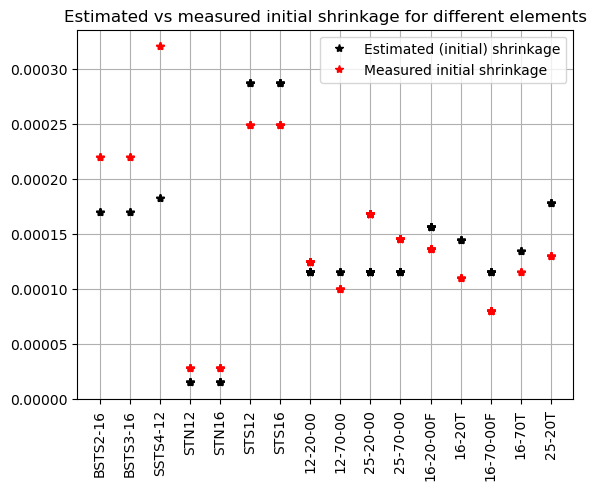

In [204]:
plt.title("Estimated vs measured initial shrinkage for different elements");
plt.plot(df["ELID"],-1*(xi_bs1*df["eps_cbs"] + xi_ds1*df["eps_cds"]),"*k",label="Estimated (initial) shrinkage");
plt.plot(df["ELID"],1*df["epsc"]*10**(-6),"*r",label="Measured initial shrinkage");
plt.legend();
plt.xticks(rotation=90);
plt.grid();

In [205]:
def func_compute_fctmred(data):

    fctmred = np.zeros(data.shape[0]);
    red = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        fctmred[i] = data["fctm"].iloc[i] - data["Ecm"].iloc[i]*abs((abs(data["initstrain"].iloc[i]) - abs(data["shrinkage_init"].iloc[i])));

    return fctmred

In [206]:
df["fctmorg"] = df["fctm"]; # Create a copy

In [207]:
if includeinitshrinkage == "yes":
    df["fctm"] = func_compute_fctmred(df); # Warning: original fctm is rewritten
    df = df.astype({
        "fctm": "float"});

    for i in range(df.shape[0]):
        df["fct095"].iloc[i] = func_cal_fcteff_from_fctm(df["fctm"].iloc[i]);
        
        df["fctmfl"].iloc[i] = func_cal_fctmfl_from_fctm(df["fctm"].iloc[i],df["h"].iloc[i]);
        
        df["fct095fl"].iloc[i] = func_cal_fcteff_from_fctm(df["fctm"].iloc[i]);

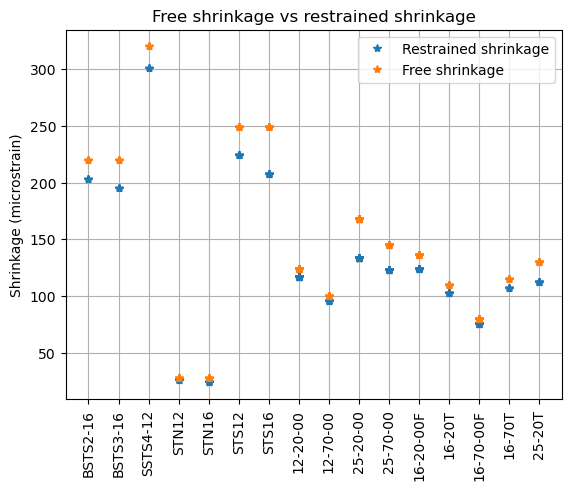

In [208]:
plt.plot(df["ELID"],-10**6*df["initstrain"],"*",label="Restrained shrinkage");
plt.plot(df["ELID"],-10**6*df["shrinkage_init"],"*",label="Free shrinkage");
plt.ylabel("Shrinkage (microstrain)");
plt.legend();
plt.xticks(rotation=90);
plt.grid();
plt.title("Free shrinkage vs restrained shrinkage");

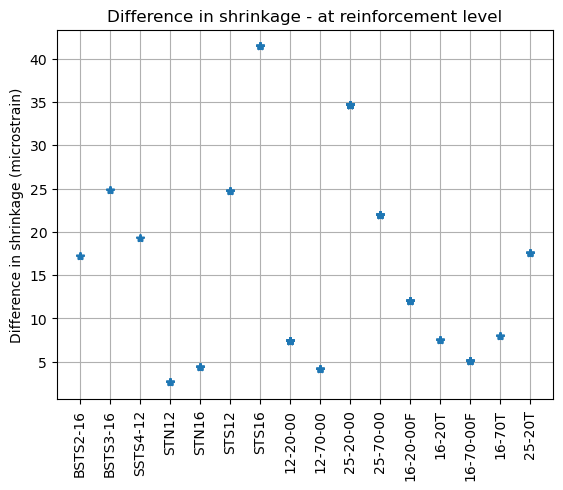

In [209]:
plt.plot(df["ELID"],10**6*(df["initstrain"]-df["shrinkage_init"]),"*",label="Difference in strain");
plt.xticks(rotation=90);
plt.grid();
plt.ylabel("Difference in shrinkage (microstrain)");
plt.title("Difference in shrinkage - at reinforcement level");

### 05.13 - Compute the cracking stage

In [210]:
def func_cal_EI_uncr(data):

    EI_conc = df["Ecm"]*df["Izz"];
    EI_steel = df["Ecm"]*(df["Astot"]*(df["cog"]-df["zstot"])**2)*(df["ae"]-1)
    EI_prestress = df["Ecm"]*(df["Aptot"]*(df["cog"]-df["zptot"])**2)*(df["ap"]-1)

    EI_uncr = EI_conc + EI_steel + EI_prestress;

    W_Ib = EI_uncr/((data["h"]-data["cog"])*data["Ecm"]);

    return W_Ib
    

In [211]:
df["W_Ib"] = func_cal_EI_uncr(df);
df = df.astype({
    "W_Ib": "float"
});

In [212]:
def func_cal_CS(data):

    Ncr = np.zeros(data.shape[0]);
    Mcr = np.zeros(data.shape[0]);
    
    Ncr095 = np.zeros(data.shape[0]);
    Mcr095 = np.zeros(data.shape[0]);

    CS = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if data["epsin"].iloc[i] == "1a" or data["epsin"].iloc[i] == "1b":
            rho = data["Astot"].iloc[i]/data["Ac"].iloc[i];

            Ncr[i] = data["Ac"].iloc[i]*data["fctm"].iloc[i]*(1+(data["ae"].iloc[i]-1)*rho); # N-1 zware doorsnede
            Ncr[i] = Ncr[i]/(1e3);
            
            Ncr095[i] = data["Ac"].iloc[i]*data["fct095"].iloc[i]*(1+(data["ae"].iloc[i]-1)*rho); # N-1 zware doorsnede
            Ncr095[i] = Ncr095[i]/(1e3);

            if data["N"].iloc[i] > Ncr095[i]:
                CS[i] = 2; # Stabilized cracking stage
            else:
                CS[i] = 1; # Crack formation stage
        
        elif data["epsin"].iloc[i] == str(2):
            
            Mcr[i] = data["W_Ib"].iloc[i]*data["fctmfl"].iloc[i];
            Mcr[i] = Mcr[i]/(1e6);
            
            Mcr095[i] = data["W_Ib"].iloc[i]*data["fct095fl"].iloc[i];
            Mcr095[i] = Mcr095[i]/(1e6);

            if data["M"].iloc[i] > Mcr095[i]:
                CS[i] = 2; # Stabilized cracking stage
            else:
                CS[i] = 1; # Crack formation stage
        
        elif data["epsin"].iloc[i] == str(3):
            
            Mcr[i] = data["W_Ib"].iloc[i]*(data["fctmfl"].iloc[i] + 1000*data["PL"].iloc[i]/data["Ac"].iloc[i]);
            Mcr[i] = Mcr[i]/(1e6);
            
            Mcr095[i] = data["W_Ib"].iloc[i]*(data["fct095fl"].iloc[i] + 1000*data["PL"].iloc[i]/data["Ac"].iloc[i]);
            Mcr095[i] = Mcr095[i]/(1e6);
            
            if data["M"].iloc[i] > Mcr095[i]:
                CS[i] = 2;  # Stabilized cracking stage
            else:
                CS[i] = 1; # Crack formation stage
                
    return Ncr095, Mcr095, CS, Ncr, Mcr

In [213]:
df["Ncr095"], df["Mcr095"], df["CS"], df["Ncr"], df["Mcr"] = func_cal_CS(df);
df = df.astype({
    "Ncr095": "float",
    "Mcr095": "float",
    "CS": "int",
    "Ncr": "float",
    "Mcr": "float",
});

### 05.14 - Computation of the bond stress

In [214]:
def func_cal_bond(data,timecutoff,Nrepcutoff):

    # tau_bms CS = 1 (CFS), CS = 2 (SCS)
    # Good bond = 1, bad bond = 2

    tau_bms = np.zeros(data.shape[0]);
    tau_max = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        # tau_bms
        # =======

        if data["CS"].iloc[i] == 1: # Address CFS
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                tau_bms[i] = 1.8*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] > timecutoff:
                tau_bms[i] = 1.35*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                tau_bms[i] = 1.35*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] > timecutoff:
                tau_bms[i] = 1.35*data["fctmorg"].iloc[i];
        elif data["CS"].iloc[i] == 2: # Address SCS
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                tau_bms[i] = 1.8*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] > timecutoff:
                tau_bms[i] = 1.8*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                tau_bms[i] = 1.8*data["fctmorg"].iloc[i];
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] > timecutoff:
                tau_bms[i] = 1.8*data["fctmorg"].iloc[i];
        
        # tau_max en tau_b0
        # =======
        if data["bondLR"].iloc[i] in [0,1] or data["bondPR"].iloc[i] in [0,1]: # Address good or unknown bond
            tau_max[i] = 2.5*np.sqrt(data["fcm"].iloc[i]);
            
        elif data["bondLR"].iloc[i] == 2 or data["bondPR"].iloc[i] == 2: # All other bond conditions
            tau_max[i] = 1.25*np.sqrt(data["fcm"].iloc[i]);
    
    return tau_bms, tau_max

In [215]:
df["tau_bms"], df["tau_max"] = func_cal_bond(df,timecutoff,Nrepcutoff);
df = df.astype({
    "tau_bms": "float",
    "tau_max": "float"
});

### 05.15 - Computation of the steel stress

For a more detailed explanation is referred to: "*Calculation of steel stresses in cracked reinforced rectangular concrete elements loaded in bending*". Proceedings of the International RILEM Conference on Synergising Expertise Towards Sustainability and Robustness of CBMs and Concrete Structures, Milos, 2023.

#### Create an initial guess for the bending case

The computation of the steel stress requires a numerical solving procedure. To (increase the chance to) get a proper solution, an initial guess is suggested for elements loaded in bending, based on linear elastic behavior, loaded in pure bending. The chosen unknowns in the computation are the strain at the top of the concrete section, and the height of the concrete compression zone.

In [216]:
def func_cal_init(data):

    xcinit = np.zeros(data.shape[0]);
    epsinit = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if str(data["epsin"].iloc[i]) == str(2) or str(data["epsin"].iloc[i]) == str(3) and data["Astot"].iloc[i] > 0 and data["M"].iloc[i] > 0:
            
            ae = data["ae"].iloc[i]; rho = data["rhotensinit"].iloc[i];
            d = data["h"].iloc[i] - data["ry"].iloc[i];
            
            kx = -ae*rho + np.sqrt((ae*rho)**2 + 2*ae*rho);
            xcinit[i] = d*kx;

            b = data["Ac"].iloc[i]/data["h"].iloc[i]; # Pseudo-width of the cross-section
            epsinit[i] = 2*(1e6)*data["M"].iloc[i]/(data["Ecm"].iloc[i]*b*xcinit[i]*(d-xcinit[i]/3));

    return xcinit, epsinit

In [217]:
df["xcinit"], df["epsinit"] = func_cal_init(df);
df = df.astype({
    "xcinit": "float",
    "epsinit": "float"
});

#### Constitutive relations

##### Concrete

In [218]:
def func_interpolate_concrete_prop(fcm,E_ci):
    
    C_12 = [20,27100,11100,0.0019,0.0035,2.44];
    C_16 = [24,28800,12200,0.002,0.0035,2.36];
    C_20 = [28,30300,13300,0.0021,0.0035,2.28];
    C_25 = [33,32000,14900,0.0022,0.0035,2.15];
    C_30 = [38,33600,16500,0.0023,0.0035,2.04];
    C_35 = [43,35000,18200,0.0023,0.0035,1.92];
    C_40 = [48,36300,20000,0.0024,0.0035,1.82];
    C_45 = [53,37500,21600,0.0025,0.0035,1.74];
    C_50 = [58,38600,23200,0.0026,0.0034,1.66];
    C_55 = [63,39700,24700,0.0026,0.0034,1.61];
    C_60 = [68,40700,26200,0.0027,0.0033,1.55];
    C_70 = [78,42600,28900,0.0027,0.0032,1.47];
    C_80 = [88,44400,31400,0.0028,0.0031,1.41];
    C_90 = [98,46000,33800,0.0029,0.003,1.36];
    C_100 = [108,47500,36000,0.003,0.003,1.32];
    
    d = {"C12":C_12,"C16":C_16,"C20":C_20,"C25":C_25,"C30":C_30,"C35":C_35,"C40":C_40,"C45":C_45,"C50":C_50,\
         "C55":C_55,"C60":C_60,"C70":C_70,"C80":C_80,"C90":C_90,"C100":C_100};
    
    col = ["fcm","Eci","Ec1","epsc1","epsclim","k"];
        
    df = pd.DataFrame(data=d).T
    df.columns = col;
    
    E_c1_ipl = interp1d(df["fcm"],df["Ec1"],fill_value="extrapolate");
    eps_c1_ipl = interp1d(df["fcm"],df["epsc1"],fill_value="extrapolate");
    eps_clim_ipl = interp1d(df["fcm"],df["epsclim"],fill_value="extrapolate");

    Ec_1 = E_c1_ipl(fcm);
    eps_c1 = eps_c1_ipl(fcm);
    eps_clim = eps_clim_ipl(fcm);
    
    k = E_ci / Ec_1;
    
    return k, eps_c1, eps_clim

In [219]:
def func_cal_fcm_eps(fcm,eps_c,eps_c1,k,epslim,Ecm,phi_creep,chi):
    
    eta = (eps_c/(1+chi*phi_creep)) / eps_c1;

    sig_c = 0;

    if eps_c < 0:
        sig_c = 0;
    
    # elif 0 <= eps_c <= epslim:
    elif 0 <= eps_c <= epslim/(1+chi*phi_creep):
        sig_c = fcm*(k*eta - (eta**2))/(1 + (k-2)*eta);
    
    elif eps_c > epslim/(1+chi*phi_creep):
        sig_c = 0;
    
    return sig_c

##### Reinforcing steel

It is assumed that the steel behaves linear elastic. Afterwards, it is checked if the yield stress is exceeded.

##### Prestressing steel

In [220]:
def func_cal_prestress(Ep,fp01k,fpk,eps_pud,eps):

    stress = Ep*eps;
    
    return stress

#### Forces and point of application of forces

##### Concrete - compression

In [221]:
def func_int_compression(z,epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi):
           
    eps_c = func_create_strain_dist(epsctop,xc,z);

    sig_c = func_cal_fcm_eps(fcm,eps_c,eps_c1,k,epslim,Ecm,phi_creep,chi);

    bz = func_extract_width(z,b);
    dF = sig_c*bz;
    
    return dF

In [222]:
def func_int_compression_moment(z,epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi):
    
    dF = func_int_compression(z,epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi);
    zdF = dF*z;
    
    return zdF

##### Concrete - uncracked part, but in tension

In [223]:
def func_int_uncracked_tension(z,epsctop,xc,b,Ecm):

    eps_c = func_create_strain_dist(epsctop,xc,z);
    
    sigt = -1*Ecm*eps_c;
    
    bz = func_extract_width(z,b);
    dF = sigt*bz;

    return dF

##### Concrete - cracked part, contribution according to Hordijk

In [224]:
def func_cal_tension_softening(fcm,fctm,w):
    
    c1 = 3; c2 = 6.93;
    Gf = 85*(fcm**0.15)/1000;
    wult = 5.136*Gf/fctm;
    
    if w >= 0 and w < wult:
        sigct = fctm*\
            (( 1 + (c1*w/wult)**3 ) * np.exp(-c2*w/wult) - (w/wult)*(1+c1**3)*np.exp(-c2));

    else:
        sigct = 0;

    return sigct

In [225]:
def func_int_hordijk(z,zw,xc,xct1,fcm,b,h,fctm,w0,epsin):
    
    if epsin == str(2) or epsin == str(3): # Addressing case of bending, or prestressing
        w = w0*(z-xc-xct1)/(zw-xc-xct1);
        sig_t = func_cal_tension_softening(fcm,fctm,w);
    elif epsin == str("1a"): # Addressing case of pure tension
        w = w0;
        sig_t = func_cal_tension_softening(fcm,fctm,w);

    bz = func_extract_width(z,b);
    dF = sig_t*bz;

    return dF

In [226]:
def func_int_hordijk_moment(z,zw,xc,xct1,fcm,b,h,fctm,w0,epsin):

    dF = func_int_hordijk(z,zw,xc,xct1,fcm,b,h,fctm,w0,epsin);
    dFz = dF*z;

    return dFz    

##### Reinforcing steel

In [227]:
def func_compute_steel_stress(epsctop,Es,As,xc,zs,zt,fy,Nzero):
    
    Fstore = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,Nzero);

    sigs = np.zeros(len(As));
    
    for i in range(int(Nzero)+1): 
        if As[i] > 0:
            sigs[i] = Fstore[0][i]/As[i];

        else:
            sigs[i] = 0;
    
    return sigs

##### Prestressing steel

In [228]:
def func_sum_steel_dP(epsctop,Ep,Ap,xc,zp,zt,fp01k,fpk,eps_pud,Pinf,Nzero,npl,zeta1):
    
    dPstore = np.zeros(len(Ap));
    MdPstore = np.zeros(len(Ap));
    sigptotstore = np.zeros(len(Ap));
    
    # this is the individual area for a specific tendon within a layer, NOT the total prestressing area in that layer! 
    Aplayer = np.zeros(len(Ap));

    for i in range(int(Nzero)+1):
        Aplayer[i] = npl[i]*Ap[i];
    
    Aptot = sum(Aplayer); # Probaly this was already used, so you can simplify        
    sigpinf = Pinf/Aptot
    
    # Sum over the layers
    for i in range(int(Nzero)+1):
        
        strainp = sigpinf/Ep + zeta1*epsctop*(zp[i]-xc)/xc;
        dPstore[i] = Aplayer[i]*func_cal_prestress(Ep,fp01k,fpk,eps_pud,strainp) - Aplayer[i]*sigpinf;
        MdPstore[i] = dPstore[i]*(zp[i]-zt);
        sigptotstore = func_cal_prestress(Ep,fp01k,fpk,eps_pud,strainp);
    
    return dPstore, MdPstore, sigptotstore

In [229]:
def func_compute_dsigp(epsctop,Ep,Ap,xc,zp,zt,fp01k,fpk,eps_pud,Pinf,Nzero,npl,zeta1):
    
    dPstore, MdPstore, sigptotstore = func_sum_steel_dP(epsctop,Ep,Ap,xc,zp,zt,fp01k,fpk,eps_pud,Pinf,Nzero,npl,zeta1);
    
    dsigp = np.zeros(len(Ap));
    Aplayer = np.zeros(len(Ap));

    for i in range(int(Nzero)+1):
        Aplayer[i] = npl[i]*Ap[i];
    
    for i in range(int(Nzero)+1):
        if Aplayer[i] > 0:
            dsigp[i] = dPstore[i]/Aplayer[i]
    
    return dsigp, sigptotstore

#### Equilibrium relations

Equilibrium relations for elements loaded in pure bending.

In [230]:
def func_cal_steel_stress_eqset_reinf_V2(p,fcm,eps_c1,k,Es,b,h,Nint,zs,As,fy,Mext,\
                                zt,Nzero,epslim,Next,Ecm,phi_creep,chi):
    
    epsctop,xc = p; # set of unknowns, called xc and epstop
    
    # Compression part of concrete
    # =================================================================
    Fcp = quad(func_int_compression,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0];
    
    # Lever arm of compression force (wrt top!)
    # =================================================================  
    zx = quad(func_int_compression_moment,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0]/Fcp;
    
    # Force and bending moment in reinforcing steel
    # =================================================================   
    Fs, Mf = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,Nzero);

    Fstot = sum(Fs);
    Mftot = sum(Mf);
    
    # Return the equilibrium equations
    # =================================================================
        
    horeq = Fcp - Fstot + (10**3)*Next;
    Meq = (10**6)*Mext - Fcp*(zt-zx) - Mftot;
    
    return horeq, Meq

Equilibrium relations for elements subjected to prestressing.

In [231]:
def func_cal_steel_stress_eqset_prestress_V2(p,fcm,eps_c1,k,Es,b,h,Nint,zs,As,fy,Mext,\
                                zt,Pinf,Ep,Ap,zp,fp01k,fpk,eps_pud,\
                                    NzeroAs,NzeroAp,Next,epslim,npl,zeta1,Ecm,phi_creep,chi):
    
    epsctop,xc = p; # set of unknowns, called xc and epstop

    # Compression part of concrete
    # =================================================================
    Fcp = quad(func_int_compression,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0];
    
    # Lever arm of compression force (wrt top!)
    # =================================================================
    zx = quad(func_int_compression_moment,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0]/Fcp;
    
    # Force and bending moment in reinforcing steel
    # =================================================================
    Fs, Mf = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,NzeroAs);
    
    Fstot = sum(Fs);
    Mftot = sum(Mf);

    # Berekening invloed van de voorspanning
    # =================================================================   
    dPstore, MdPstore, sigptotstore = func_sum_steel_dP(epsctop,Ep,Ap,xc,zp,zt,fp01k,fpk,eps_pud,Pinf,NzeroAp,npl,zeta1);
    
    dFp = sum(dPstore);
    Mptot = sum(MdPstore);
    
    # Return the equilibrium equations
    # =================================================================
    horeq = Fcp + (10**3)*Next - Fstot - dFp - Pinf;
    Meq = (10**6)*Mext - Fcp*(zt-zx) - Mftot - Mptot;
    
    return horeq, Meq

Equilibrium relations for elements subjected to pure tension.

In [232]:
def func_cal_steel_stress_eqset_reinf_Hordijk_tensioning(Next,zw,xc,xct1,fcm,b,h,fctm,w0,epsin):

    Nct2 = quad(func_int_hordijk,0,h,args=(zw,xc,xct1,fcm,b,h,fctm,w0,epsin))[0];
    Ns = Next - Nct2; # Linear elastic part, uncracked, in tension, does not exist (constant strain distribution over the height of the cross-section)

    return Ns   
    

In [233]:
def func_cal_steel_stress_eqset_reinf_Hordijk_bending(p,fcm,eps_c1,k,Es,b,h,Nint,zs,As,fy,Mext,\
                                zt,Nzero,epslim,Next,Ecm,phi_creep,chi,zw,w0,epsin,fctm):
    
    epsctop,xc = p; # set of unknowns, called xc and epstop
    
    # Compression part of concrete
    # =================================================================
    Fcp = quad(func_int_compression,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0];
    
    # Lever arm of compression force (wrt top!)
    # =================================================================  
    zx = quad(func_int_compression_moment,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0]/Fcp;

    # Part of the concrete that is uncracked, but in tension
    # =================================================================  
    xct1 = (fctm/Ecm)*(xc/epsctop);
    Nct1 = quad(func_int_uncracked_tension,xc,xc+xct1,args=(epsctop,xc,b,Ecm))[0];

    # Location of force application of NCT1
    # =================================================================  
    zct1 = xc + (2/3)*xct1;

    # Hordijk contribution
    # =================================================================  
    Nct2 = quad(func_int_hordijk,xc+xct1,h,args=(zw,xc,xct1,fcm,b,h,fctm,w0,epsin))[0];

    # Location of force application of NCT2
    # ================================================================= 
    zct2 = xc + xct1 + quad(func_int_hordijk_moment,xc+xct1,h,args=(zw,xc,xct1,fcm,b,h,fctm,w0,epsin))[0]/Nct2;
    
    # Force and bending moment in reinforcing steel
    # =================================================================   
    Fs, Mf = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,Nzero);

    Fstot = sum(Fs);
    Mftot = sum(Mf);
    
    # Return the equilibrium equations
    # =================================================================
        
    horeq = Fcp - Nct1 - Nct2 - Fstot + (10**3)*Next;
    Meq = (10**6)*Mext - Fcp*(zt-zx) - Mftot + Nct1*(zt-xc-(2/3)*xct1) - Nct2*(zct2-zt) ;
    
    return horeq, Meq

In [234]:
def func_cal_steel_stress_eqset_prestress_Hordijk(p,fcm,eps_c1,k,Es,b,h,Nint,zs,As,fy,Mext,\
                                zt,Pinf,Ep,Ap,zp,fp01k,fpk,eps_pud,\
                                    NzeroAs,NzeroAp,Next,epslim,npl,zeta1,Ecm,phi_creep,chi,zw,w0,epsin,fctm):
    
    epsctop,xc = p; # set of unknowns, called xc and epstop

    # Compression part of concrete
    # =================================================================
    Fcp = quad(func_int_compression,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0];
    
    # Lever arm of compression force (wrt top!)
    # =================================================================
    zx = quad(func_int_compression_moment,0,xc,args=(epsctop,xc,b,h,Nint,fcm,eps_c1,k,epslim,Ecm,phi_creep,chi))[0]/Fcp;

    # Part of the concrete that is uncracked, but in tension
    # =================================================================  
    xct1 = (fctm/Ecm)*(xc/epsctop);
    Nct1 = quad(func_int_uncracked_tension,xc,xc+xct1,args=(epsctop,xc,b,Ecm))[0];

    # Location of force application of NCT1
    # =================================================================  
    zct1 = xc + (2/3)*xct1;

    # Hordijk contribution
    # =================================================================  
    Nct2 = quad(func_int_hordijk,xc+xct1,h,args=(zw,xc,xct1,fcm,b,h,fctm,w0,epsin))[0];

    # Location of force application of NCT2
    # ================================================================= 
    zct2 = xc + xct1 + quad(func_int_hordijk_moment,xc+xct1,h,args=(zw,xc,xct1,fcm,b,h,fctm,w0,epsin))[0]/Nct2;
    
    # Force and bending moment in reinforcing steel
    # =================================================================
    Fs, Mf = func_sum_steel_reinf(epsctop,Es,As,xc,zs,zt,fy,NzeroAs);
    
    Fstot = sum(Fs);
    Mftot = sum(Mf);

    # Berekening invloed van de voorspanning
    # =================================================================   
    dPstore, MdPstore, sigptotstore = func_sum_steel_dP(epsctop,Ep,Ap,xc,zp,zt,fp01k,fpk,eps_pud,Pinf,NzeroAp,npl,zeta1);
    
    dFp = sum(dPstore);
    Mptot = sum(MdPstore);
    
    # Return the equilibrium equations
    # =================================================================
    horeq = Fcp + (10**3)*Next - Nct1 - Nct2 - Fstot - dFp - Pinf;
    Meq = (10**6)*Mext - Fcp*(zt-zx) - Mftot - Mptot + Nct1*(zt-xc-(2/3)*xct1) - Nct2*(zct2-zt);
    
    return horeq, Meq

#### Calculation of steel stress including Hordijk Tension Softening

In [235]:
def func_cal_steel_stress_hordijk(data):

    sigstoresimplified = np.zeros(data.shape[0]);
    sigstore = np.zeros((data.shape[0],Ncond)); # Store stresses of all reinforcement layers!
    dpsigstore = np.zeros((data.shape[0],Ncond)); # Store stresses dpsig
    sigptotstore = np.zeros((data.shape[0],Ncond)); # Store prestressing stresses acting in each tendon
    
    xc = np.zeros(data.shape[0]);
    eps = np.zeros(data.shape[0]);# Calculated strain at the top of the considered concrete section
    eps_bot = np.zeros(data.shape[0]);# Calculated strain at the bottom of the considered concrete section

    data["sigs"] = np.zeros(data.shape[0]); # Overwrite --> prevents that "old stress remain"
    data["dpsigs"] = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        # Determine param zw
        if data["locw"].iloc[i] == 1:
            zw = zs[i,data["indLR"].iloc[i]];
        elif data["locw"].iloc[i] == 2:
            zw = data["h"].iloc[i];
        else:
            zw = 0;

        # Determine param w0
        if data["wm"].iloc[i] > tol and data["wmax"].iloc[i] < tol:
            w0 = data["wm"].iloc[i];
        elif data["wmax"].iloc[i] > tol and data["wm"].iloc[i] < tol:
            w0 = data["wmax"].iloc[i];
        elif data["wm"].iloc[i] > tol and data["wmax"].iloc[i] > tol:
            w0 = data["wm"].iloc[i];
        else:
            w0 = 0;

        with suppress(ZeroDivisionError): # Continue calculation

            # Pure axial force
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str("1a"):

                if data["Astot"].iloc[i] > tol:

                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm0"].iloc[i]);
                    Ns = func_cal_steel_stress_eqset_reinf_Hordijk_tensioning(data["N"].iloc[i]*(10**3),
                                                                              zw,
                                                                              0,
                                                                              0,
                                                                              data["fcm"].iloc[i],
                                                                              data["b"].iloc[i],
                                                                              data["h"].iloc[i],
                                                                              data["fctm"].iloc[i],
                                                                              w0,
                                                                              data["epsin"].iloc[i]);

                    sigstore[i,:] = Ns/data["Astot"].iloc[i];
                    sigstoresimplified[i] = (10**3)*data["N"].iloc[i] / data["Astot"].iloc[i]; # Useful for shadow-calculation!

                    if sigstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"reject result");
                        sigstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        data["sigs"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress (<fy) was computed",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i]);
                        data["sigs"].iloc[i] = sigstore[i,data["indLR"].iloc[i]];
            
            # Pure bending and / or bending in combination with axial forces 
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str(2):
                
                # Below, address the case of reinforcing steel only
                # ====================================
                if data["Aptot"].iloc[i] < tol:

                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm0"].iloc[i]);
                    
                    sol = fsolve(func_cal_steel_stress_eqset_reinf_Hordijk_bending,[data["epsinit"].iloc[i],data["xcinit"].iloc[i]],
                                                        args=(data["fcm"].iloc[i],
                                                                eps_c1,
                                                                k,
                                                                data["Es"].iloc[i],
                                                                data["b"].iloc[i],
                                                                data["h"].iloc[i],
                                                                500,
                                                                zs[i,:],
                                                                Aslayer[i,:],
                                                                data["fy"].iloc[i],
                                                                data["M"].iloc[i],
                                                                data["cog"].iloc[i],
                                                                data["indLR"].iloc[i],
                                                                eps_clim,
                                                                data["N"].iloc[i],
                                                                data["Ecm"].iloc[i],
                                                                data["phi_creep"].iloc[i],
                                                                chi,
                                                                zw,
                                                                w0,
                                                                data["epsin"].iloc[i],
                                                                data["fctm"].iloc[i]
                                                            ));
                    
                    eps[i], xc[i] = sol[0], sol[1];
                    eps_bot[i] = eps[i]*(data["h"].iloc[i]-xc[i])/xc[i];
        
                    sigstore[i,:] = func_compute_steel_stress(eps[i],
                                                                     data["Es"].iloc[i],
                                                                     Aslayer[i,:],
                                                                     xc[i],
                                                                     zs[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fy"].iloc[i],
                                                                     data["indLR"].iloc[i]);

                    sigstoresimplified[i] = ((10**6)*data["M"].iloc[i] / data["Astot"].iloc[i])*(1/(data["zstot"].iloc[i]-data["xcinit"].iloc[i]/3))

                    # Check if conditions are met (w.r.t. lowest reinforcing layer; stress should be smaller than yield strength)
                    if sigstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"reject result");
                        sigstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        data["sigs"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress (<fy) was computed",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i]);
                        data["sigs"].iloc[i] = sigstore[i,data["indLR"].iloc[i]];

            # Prestressing
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str(3):
                
                # Below, address the case of prestressing steel, maybe in combination with reinforcing steel
                # ====================================
                if data["Aptot"].iloc[i] > tol:

                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm0"].iloc[i]);
                    
                    sol = fsolve(func_cal_steel_stress_eqset_prestress_Hordijk,[0.001,data["h"].iloc[i]/3],
                                                                args=(data["fcm"].iloc[i],
                                                                eps_c1,
                                                                k,
                                                                data["Es"].iloc[i],
                                                                data["b"].iloc[i],
                                                                data["h"].iloc[i],
                                                                500,
                                                                zs[i,:],
                                                                Aslayer[i,:],
                                                                data["fy"].iloc[i],
                                                                data["M"].iloc[i],
                                                                data["cog"].iloc[i],
                                                                1000*data["PL"].iloc[i],
                                                                data["Ep"].iloc[i],
                                                                Ap[i,:], # Area per tendon in a layer
                                                                zp[i,:],
                                                                data["fp01k"].iloc[i],
                                                                data["fpk"].iloc[i],
                                                                0.005, # epsuk
                                                                data["indLR"].iloc[i],
                                                                data["indNP"].iloc[i],
                                                                data["N"].iloc[i],
                                                                eps_clim,
                                                                npl[i,:],
                                                                data["zeta1"].iloc[i],
                                                                data["Ecm"].iloc[i],
                                                                data["phi_creep"].iloc[i],
                                                                chi,
                                                                zw,
                                                                w0,
                                                                data["epsin"].iloc[i],
                                                                data["fctm"].iloc[i]
                                                                    ));    
                        
                    eps[i], xc[i] = sol[0], sol[1];
                    eps_bot[i] = eps[i]*(data["h"].iloc[i]-xc[i])/xc[i];
                                    
                    sigstore[i,:] = func_compute_steel_stress(eps[i],
                                                             data["Es"].iloc[i],
                                                             Aslayer[i,:],
                                                             xc[i],
                                                             zs[i,:],
                                                             data["cog"].iloc[i],
                                                             data["fy"].iloc[i],
                                                             data["indLR"].iloc[i]);
                    
                    dpsigstore[i,:], sigptotstore[i,:] = func_compute_dsigp(eps[i],
                                                                     data["Ep"].iloc[i],
                                                                     Ap[i,:],
                                                                     xc[i],
                                                                     zp[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fp01k"].iloc[i],
                                                                     data["fpk"].iloc[i],
                                                                     0.005, # epsuk
                                                                     1000*data["PL"].iloc[i],
                                                                     data["indNP"].iloc[i],
                                                                     npl[i,:],
                                                                     data["zeta1"].iloc[i]);

                    # Check if conditions are met (w.r.t. lowest reinforcing layer; stress should be smaller than yield strength)
                    # Check if conditions are met (w.r.t. lowest reinforcing layer and prestressing layer)
                    if sigstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i] or sigptotstore[i,data["indNP"].iloc[i]] > data["fp01k"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"OR computed prestressing stress",
                        #      sigptotstore[i,data["indNP"].iloc[i]],"exceeds fp01k",data["fp01k"].iloc[i],"REJECT");
                        sigstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        dpsigstore[i,data["indNP"].iloc[i]] == np.nan; # Since this prestressing steel stress is not valid
                        data["sigs"].iloc[i] = np.nan;
                        data["dpsigs"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress was computed (<fy)",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i],
                        #     "or valid prestressing steel stress was computed (<fp01k)",sigptotstore[i,data["indNP"].iloc[i]],"<",data["fp01k"].iloc[i]);
                        data["sigs"].iloc[i] = sigstore[i,data["indLR"].iloc[i]];
                        data["dpsigs"].iloc[i] = dpsigstore[i,data["indNP"].iloc[i]];

    # Write results
    # =====================================================================
    
    data["xc"] = xc;
    data["eps"] = eps;
    data["epsbot"] = eps_bot;
    data["sigssimpl"] = sigstoresimplified;
    
    return data

In [236]:
def func_cal_steel_stress(data):

    sigstore = np.zeros((data.shape[0],Ncond)); # Store stresses of all reinforcement layers!
    dpsigstore = np.zeros((data.shape[0],Ncond)); # Store stresses dpsig
    sigptotstore = np.zeros((data.shape[0],Ncond)); # Store prestressing stresses acting in each tendon

    sigstoresimplified = np.zeros(data.shape[0]);
    
    xc = np.zeros(data.shape[0]);
    eps = np.zeros(data.shape[0]);# Calculated strain at the top of the considered concrete section
    eps_bot = np.zeros(data.shape[0]);# Calculated strain at the bottom of the considered concrete section

    data["sigs"] = np.zeros(data.shape[0]);
    data["dpsigs"] = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        with suppress(ZeroDivisionError): # Continue calculation
        
            # Pure tension
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str("1a"):
                if data["N"].iloc[i] > tol:
                    data["sigs"].iloc[i] = (1e3)*data["N"].iloc[i]/data["Astot"].iloc[i];
                            
            # Pure bending and / or bending in combination with axial forces 
            # ==================================================================================
            if str(data["epsin"].iloc[i]) == str(2) or str(data["epsin"].iloc[i]) == str(3):
                
                # Below, address the case of reinforcing steel
                # ====================================
                if data["Aptot"].iloc[i] < tol:
                    
                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm"].iloc[i]);

                    sol = fsolve(func_cal_steel_stress_eqset_reinf_V2,[data["epsinit"].iloc[i],data["xcinit"].iloc[i]],
                                                        args=(data["fcm"].iloc[i],
                                                                eps_c1,
                                                                k,
                                                                data["Es"].iloc[i],
                                                                data["b"].iloc[i],
                                                                data["h"].iloc[i],
                                                                500,
                                                                zs[i,:],
                                                                Aslayer[i,:],
                                                                data["fy"].iloc[i],
                                                                data["M"].iloc[i],
                                                                data["cog"].iloc[i],
                                                                data["indLR"].iloc[i],
                                                                eps_clim,
                                                                data["N"].iloc[i],
                                                                data["Ecm"].iloc[i],
                                                                data["phi_creep"].iloc[i],
                                                                chi
                                                            ));
                    
                    eps[i], xc[i] = sol[0], sol[1];
                    eps_bot[i] = eps[i]*(data["h"].iloc[i]-xc[i])/xc[i];
        
                    sigstore[i,:] = func_compute_steel_stress(eps[i],
                                                                     data["Es"].iloc[i],
                                                                     Aslayer[i,:],
                                                                     xc[i],
                                                                     zs[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fy"].iloc[i],
                                                                     data["indLR"].iloc[i]);
                    
                    # Check if conditions are met (w.r.t. lowest reinforcing layer; stress should be smaller than yield strength)
                    if sigstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"reject result");
                        sigstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        data["sigs"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress (<fy) was computed",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i]);
                        data["sigs"].iloc[i] = sigstore[i,data["indLR"].iloc[i]];
    
                # Below, address the case of prestressing steel (or in combination with reinforcing steel)
                # ====================================
                elif data["Aptot"].iloc[i] > tol:
    
                    k, eps_c1, eps_clim = func_interpolate_concrete_prop(data["fcm"].iloc[i],data["Ecm"].iloc[i]);

                    sol = fsolve(func_cal_steel_stress_eqset_prestress_V2,[0.001,data["h"].iloc[i]/3],
                                                args=(data["fcm"].iloc[i],
                                                eps_c1,
                                                k,
                                                data["Es"].iloc[i],
                                                data["b"].iloc[i],
                                                data["h"].iloc[i],
                                                500,
                                                zs[i,:],
                                                Aslayer[i,:],
                                                data["fy"].iloc[i],
                                                data["M"].iloc[i],
                                                data["cog"].iloc[i],
                                                1000*data["PL"].iloc[i],
                                                data["Ep"].iloc[i],
                                                Ap[i,:], # Area per tendon in a layer
                                                zp[i,:],
                                                data["fp01k"].iloc[i],
                                                data["fpk"].iloc[i],
                                                0.005, # epsuk
                                                data["indLR"].iloc[i],
                                                data["indNP"].iloc[i],
                                                data["N"].iloc[i],
                                                eps_clim,
                                                npl[i,:],
                                                data["zeta1"].iloc[i],
                                                data["Ecm"].iloc[i],
                                                data["phi_creep"].iloc[i],
                                                chi
                                                    ));    
        
                    eps[i], xc[i] = sol[0], sol[1];
                    eps_bot[i] = eps[i]*(data["h"].iloc[i]-xc[i])/xc[i];
                    
                    sigstore[i,:] = func_compute_steel_stress(eps[i],
                                                                     data["Es"].iloc[i],
                                                                     Aslayer[i,:],
                                                                     xc[i],
                                                                     zs[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fy"].iloc[i],
                                                                     data["indLR"].iloc[i]);
                    
                    dpsigstore[i,:], sigptotstore[i,:] = func_compute_dsigp(eps[i],
                                                                     data["Ep"].iloc[i],
                                                                     Ap[i,:],
                                                                     xc[i],
                                                                     zp[i,:],
                                                                     data["cog"].iloc[i],
                                                                     data["fp01k"].iloc[i],
                                                                     data["fpk"].iloc[i],
                                                                     0.005, # epsuk
                                                                     1000*data["PL"].iloc[i],
                                                                     data["indNP"].iloc[i],
                                                                     npl[i,:],
                                                                     data["zeta1"].iloc[i]);
    
                    # Check if conditions are met (w.r.t. lowest reinforcing layer; stress should be smaller than yield strength)
                    # Check if conditions are met (w.r.t. lowest reinforcing layer and prestressing layer)
                    if sigstore[i,data["indLR"].iloc[i]] > data["fy"].iloc[i] or sigptotstore[i,data["indNP"].iloc[i]] > data["fp01k"].iloc[i]:
                        #print("Warning: computed steel stress",sigstore[i,data["indLR"].iloc[i]],
                        #      "larger than yield strength",data["fy"].iloc[i],"OR computed prestressing stress",
                        #      sigptotstore[i,data["indNP"].iloc[i]],"exceeds fp01k",data["fp01k"].iloc[i],"REJECT");
                        sigstore[i,data["indLR"].iloc[i]] == np.nan; # Since this steel stress is not valid!
                        dpsigstore[i,data["indNP"].iloc[i]] == np.nan; # Since this prestressing steel stress is not valid
                        data["sigs"].iloc[i] = np.nan;
                        data["dpsigs"].iloc[i] = np.nan;
                    else:
                        #print("Success: a valid steel stress was computed (<fy)",sigstore[i,data["indLR"].iloc[i]],"<",data["fy"].iloc[i],
                        #     "or valid prestressing steel stress was computed (<fp01k)",sigptotstore[i,data["indNP"].iloc[i]],"<",data["fp01k"].iloc[i]);
                        data["sigs"].iloc[i] = sigstore[i,data["indLR"].iloc[i]];
                        data["dpsigs"].iloc[i] = dpsigstore[i,data["indNP"].iloc[i]];

    data["xc"] = xc;
    data["eps"] = eps;
    data["epsbot"] = eps_bot;
    data["sigssimpl"] = sigstoresimplified;
    
    return data

In [237]:
if importsigs == "no" and hordijksigs == "yes":
    df = func_cal_steel_stress_hordijk(df);
    df[["sigs","sigssimpl","dpsigs","xc","eps","epsbot"]].to_csv("steel_stress_hordijk.csv",index = False);
elif importsigs == "yes" and hordijksigs == "yes":
    df[["sigs","sigssimpl","dpsigs","xc","eps","epsbot"]] = \
        pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Working_database\steel_stress_hordijk.csv"));

if importsigs == "no" and hordijksigs == "no":
    df = func_cal_steel_stress(df);
    df[["sigs","dpsigs"]].to_csv("steel_stress.csv",index = False);
elif importsigs == "yes" and hordijksigs == "no":
    df[["sigs","dpsigs"]] = \
        pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Working_database\steel_stress.csv"));

In [238]:
df = df.astype({
    "sigs": "float",
    "dpsigs": "float",
    "xc": "float",
    "eps": "float"
});

### 05.16 - Function to compute the centre of gravity of the steel in tension

In [239]:
def func_compute_zstottens(data):

    zstemp = np.zeros((data.shape[0],Ncond));
    zstottens = np.zeros(data.shape[0]);
    zstottenstemp = np.zeros((data.shape[0],Ncond));
    nbltens = np.zeros((data.shape[0],Ncond));
    phitens = np.zeros((data.shape[0],Ncond));
    Astenstemp = np.zeros((data.shape[0],Ncond));
    Astens = np.zeros(data.shape[0]);
    Actens = np.zeros(data.shape[0]);

    Aptens = np.zeros((data.shape[0],Ncond));
    
    for i in range(data.shape[0]):
        for j in range(Ncond):
            if zs[i,j] > data["xc"].iloc[i]:
                zstemp[i,j] = zs[i,j];
                nbltens[i,j] = nbl[i,j];
                phitens[i,j] = phi[i,j];

            else:
                zstemp[i,j] = 0;
                nbltens[i,j] = 0;
                phitens[i,j] = 0;

            zstottenstemp[i,j] = zstemp[i,j]*(nbltens[i,j]*(1/4)*np.pi*phitens[i,j]**2);
            Astenstemp[i,j] = (nbltens[i,j]*(1/4)*np.pi*phitens[i,j]**2);

        Astens[i] = sum(Astenstemp[i,:]);
        
        zstottens[i] = np.sum(zstottenstemp[i,:])/np.sum(Astenstemp[i,:]);

        Actens[i] = quad(func_extract_width,data["h"].iloc[i]-data["xc"].iloc[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0];

    return zstottens, Astens, Actens

In [240]:
df["zstottens"], df["Astens"], df["Actens"] = func_compute_zstottens(df);

### 05.17 - Function to compute the effective concrete area

In [241]:
def find_positive(lst):
    for index, x in enumerate(lst):
        if x > 0:
            return index

#### $A_{\mathrm{eff}}$ as defined in *fib* MC 2020

In [242]:
def cal_eff_area_MC2020(data):

    Aceff = np.zeros(data.shape[0]);
    Aseff = np.zeros(data.shape[0]);
    Apeff = np.zeros(data.shape[0]);
    phi_eq = np.zeros(data.shape[0]);
    rhoeff = np.zeros(data.shape[0]);
    hceff = np.zeros(data.shape[0]);
    bceff = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
    
        # Case: pure bending and / or prestressing
        # ========================================
        if data["Astot"].iloc[i] > tol and data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3) and data["Aptot"].iloc[i] > tol:
            
            if data["xc"].iloc[i] > tol:

                if data["Astot"].iloc[i] < tol:
                    idx = find_positive(zp[i,:]-data["xc"].iloc[i]);
                    zptoptens = zp[i,idx];
                    
                    hceff1 = data["ryp"].iloc[i] + 5*data["phi_peq"].iloc[i];
                    hceff2 = 10*data["phi_peq"].iloc[i];
                    hceff3 = 3.5*data["ryp"].iloc[i];

                else:
                    # Determine top layer in tensile zone
                    idx = find_positive(zs[i,:]-data["xc"].iloc[i]);
                    zstoptens = zs[i,idx];
                    
                    hceff1 = data["ry"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
                    hceff2 = 10*phi[i,data["indLR"].iloc[i]];
                    hceff3 = 3.5*data["ry"].iloc[i];
    
                if data["Astot"].iloc[i] < tol:
                    hceffint = np.min([hceff1,hceff2,hceff3]) + (zp[i,data["indNP"].iloc[i]] - zptoptens);
                else:
                    hceffint = np.min([hceff1,hceff2,hceff3]) + (zs[i,data["indLR"].iloc[i]] - zstoptens);
                
                hceff4 = data["h"].iloc[i] - data["xc"].iloc[i];
                
                hceff[i] = np.min([hceffint,hceff4]);
                
                if data["Astot"].iloc[i] > tol:
                    nlayertenseff = data["indLR"].iloc[i] - idx + 1;
                
                Acefftemp = np.zeros(Ncond);
                Asefftemp = np.zeros(Ncond);
                Apefftemp = np.zeros(Ncond);
    
                phi_eqtemp = np.zeros(Ncond);
                phi_eqtemp_sqrt = np.zeros(Ncond);
                
                # Case 1: isolated bars --> indien spacing > 10*phi
                if spacall[i,data["indLR"].iloc[i]] > 10*phi[i,data["indLR"].iloc[i]]:
                    
                    # Subcase: MC 2020 fig. 30.5-4 left: lowest reinfocing layer is <= 5*phi (phi of lowest layer)
                    if data["ry"].iloc[i] <= 5*phi[i,data["indLR"].iloc[i]]:
        
                        for j in range(Ncond):
                            
                            if zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                                    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
                            
                        # zs[i,j] > data["h"].iloc[i] - hceff and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                            elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                        
                        Aceff[i] = sum(Acefftemp);
        
                        for j in range(Ncond):
                            if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                                Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                                phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                                phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                        Aseff[i] = sum(Asefftemp);
                        phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
        
                        if data["Aptot"].iloc[i] > tol:
                            for j in range(Ncond):
                                if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                    Apefftemp[j] = Ap[i,j]*npl[i,j];
        
                        Apeff[i] = sum(Apefftemp);
                        
                    # Subcase: MC 2020 fig. 30.5-4 right: lowest reinfocing layer is > 5*phi (phi of lowest layer)
                    elif data["ry"].iloc[i] > 5*phi[i,data["indLR"].iloc[i]]:
        
                        for j in range(Ncond):
    
                            if zs[i,j] > data["h"].iloc[i] - hceff and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]] and nbl[i,j] > 2:
                                Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                                    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;

                            elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
        
                        Aceff[i] = sum(Acefftemp);
        
                        for j in range(Ncond):
                            if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                                Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                                phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                                phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                        Aseff[i] = sum(Asefftemp);
                        phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
        
                        if data["Aptot"].iloc[i] > tol:
                            for j in range(Ncond):
                                if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                    Apefftemp[j] = Ap[i,j]*npl[i,j];
        
                        Apeff[i] = sum(Apefftemp);
                
                # Case 2: grouped bars --> spacing <= 10*phi
                elif spacall[i,data["indLR"].iloc[i]] <= 10*phi[i,data["indLR"].iloc[i]]:
                    
                    Aceff[i] = quad(func_extract_width,data["h"].iloc[i]-hceff[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
                    
                    for j in range(Ncond):
                        if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                            Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
                            
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                    Aseff[i] = sum(Asefftemp);
                    phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
        
                    for j in range(Ncond):
                        if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                            Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
    
                    Aseff[i] = sum(Asefftemp);
                    phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
        
                    if data["Aptot"].iloc[i] > tol:
                        for j in range(Ncond):
                            if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                Apefftemp[j] = Ap[i,j]*npl[i,j];
        
                    Apeff[i] = sum(Apefftemp);
    
        # Case: pure tension
        # ========================================
        
        if data["epsin"].iloc[i] == str("1a"):

            hceff1 = data["ry"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
            hceff2 = 10*phi[i,data["indLR"].iloc[i]];
            hceff3 = 3.5*data["ry"].iloc[i];
            hceff4 = data["h"].iloc[i];
        
            hceff[i] = min(min(hceff1,hceff2,hceff3),hceff4);
            
            bceff1 = data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
            bceff2 = 10*phi[i,data["indLR"].iloc[i]];
            bceff3 = 3.5*data["rx"].iloc[i];
            bceff4 = func_extract_width(data["indLR"].iloc[i],data["b"].iloc[i]);

            bceff[i] = min(min(bceff1,bceff2,bceff3),bceff4);
            
            Acefftemp = np.zeros(Ncond);
            Asefftemp = np.zeros(Ncond);
            phi_eqtemp = np.zeros(Ncond);
            phi_eqtemp_sqrt = np.zeros(Ncond);
            
            if data["indLR"].iloc[i] > tol: # Multiple layers, centric
                # Aceff is in this case equal to the total concrete area (grouped bars)
                Aceff[i] = quad(func_extract_width,0,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
                
                if data["EPID"].iloc[i] == 13:
                    # Aseff is in this case equal to the total area of reinforcement
                    Aseff[i] = data["Astot"].iloc[i];

                elif data["EPID"].iloc[i] == 15:
                    # Aseff is in this case equal to the total area of reinforcement
                    Aseff[i] = data["Astot"].iloc[i];

                elif data["EPID"].iloc[i] == 16:
                   # Aseff is in this case equal to the total area of reinforcement
                    Aseff[i] = data["Astot"].iloc[i];

                elif data["EPID"].iloc[i] == 18:
                    # Aseff is in this case equal to the total area of reinforcement
                    bceffrand = min(5*phi[i,0],clat[i,0]+phi[i,0])+5*phi[i,0];
                    heffdef = min(min(hceff1,hceff2,hceff3),data["h"].iloc[i]/2);
                    Aseff[i] = data["Astot"].iloc[i];

                elif data["EPID"].iloc[i] == 27:
                    # Aseff is in this case equal to the total area of reinforcement
                    Aseff[i] = data["Astot"].iloc[i];
            
                elif data["EPID"].iloc[i] == 28:
                    # Aseff is in this case equal to the total area of reinforcement
                    Aseff[i] = data["Astot"].iloc[i];

                # Phieq
                for j in range(Ncond):
                    phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                    phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2

                phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);

            # -------------------------
            elif data["indLR"].iloc[i] < 1: # Single layer, centric

                # Address circular cross-sections
                if data["ELID"].iloc[i] in ["T-C1-3","T-C1-5","T-C2-3","T-C2-5","T-C3-1","T-C3-2","T-C3-4",
                                            "Specimen 1","Specimen 2","Specimen 3","Specimen 4","Specimen 5"]:

                    Aceff[i] = quad(func_extract_width,data["h"].iloc[i]/2-hceff[i]/2,data["h"].iloc[i]/2+hceff[i]/2,args=(data["b"].iloc[i]))[0];
                    Aseff[i] = (1/4)*np.pi*phi[i,0]**2;
                    
                    # Address rectangular cross-sections
                else:
                    Aceff[i] = hceff[i]*bceff[i];
                    Aseff[i] = (1/4)*np.pi*phi[i,0]**2;

                phi_eq[i] = phi[i,0]; # Since only a single diameter was applied
            
        # Calculation of rhoeff - MC 2020
        rhoeff[i] = (Aseff[i] + (data["zeta1"].iloc[i]**2)*Apeff[i])/Aceff[i];
                        
    return Aceff, Aseff, Apeff, phi_eq, rhoeff, hceff

In [243]:
df["Aceff_MC2020"], df["Aseff_MC2020"], df["Apeff_MC2020"], df["phi_eq_MC2020"], df["rhoeff_MC2020"], df["hceff_MC2020"] = cal_eff_area_MC2020(df)

df = df.astype({
    "Aceff_MC2020": "float",
    "Aseff_MC2020": "float",
    "Apeff_MC2020": "float",
    "phi_eq_MC2020": "float",
    "rhoeff_MC2020": "float",
    "hceff_MC2020": "float"
});

#### $A_{\mathrm{eff}}$ as defined in EN 1992-1-1 (2023)

In [244]:
def cal_eff_area_FPR(data):

    Aceff = np.zeros(data.shape[0]);
    Aseff = np.zeros(data.shape[0]);
    Apeff = np.zeros(data.shape[0]);
    phi_eq = np.zeros(data.shape[0]);
    rhoeff = np.zeros(data.shape[0]);
    hceff = np.zeros(data.shape[0]);
    bceff = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        # Case: pure bending and / or prestressing
        # ========================================
        if data["Astot"].iloc[i] > tol and data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3) and data["Aptot"].iloc[i] > tol:

            if data["xc"].iloc[i] > tol:

                if data["Astot"].iloc[i] < tol:
                    # Determine top layer in tensile zone
                    idx = find_positive(zp[i,:]-data["phi_peq"].iloc[i]);
                    zptoptens = zp[i,idx];
                    
                    hceff1 = data["ryp"].iloc[i] + 5*data["phi_peq"].iloc[i];
                    hceff2 = 10*data["phi_peq"].iloc[i];
                    hceff3 = 3.5*data["ryp"].iloc[i];
                else:
                    # Determine top layer in tensile zone
                    idx = find_positive(zs[i,:]-data["xc"].iloc[i]);
                    zstoptens = zs[i,idx];
                    
                    hceff1 = data["ry"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
                    hceff2 = 10*phi[i,data["indLR"].iloc[i]];
                    hceff3 = 3.5*data["ry"].iloc[i];

                if data["Astot"].iloc[i] < tol:
                    hceffint = np.min([hceff1,hceff2,hceff3]) + (zp[i,data["indNP"].iloc[i]] - zptoptens);
                else:
                    hceffint = np.min([hceff1,hceff2,hceff3]) + (zs[i,data["indLR"].iloc[i]] - zstoptens);

                hceff4 = data["h"].iloc[i] - data["xc"].iloc[i];
                hceff5 = data["h"].iloc[i]/2;
                
                hceff[i] = np.min([hceffint,hceff4,hceff5]);

                if data["Astot"].iloc[i] > tol:
                    nlayertenseff = data["indLR"].iloc[i] - idx + 1;
                    
                Acefftemp = np.zeros(Ncond);
                Asefftemp = np.zeros(Ncond);
                Apefftemp = np.zeros(Ncond);
    
                phi_eqtemp = np.zeros(Ncond);
                phi_eqtemp_sqrt = np.zeros(Ncond);
                
                # Case 1: isolated bars --> spacing > 10*phi
                if spacall[i,data["indLR"].iloc[i]] > 10*phi[i,data["indLR"].iloc[i]]:
                    
                    # Subcase: MC 2020 fig. 30.5-4 left: lowest reinfocing layer is <= 5*phi (phi of lowest layer)
                    if data["ry"].iloc[i] <= 5*phi[i,data["indLR"].iloc[i]]:
                        
                        for j in range(Ncond):
                            
                            if zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                                    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
                            
                            elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
                        
                        Aceff[i] = sum(Acefftemp);
        
                        for j in range(Ncond):
                            if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                                Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                                phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                                phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                        Aseff[i] = sum(Asefftemp);
                        phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
        
                        if data["Aptot"].iloc[i] > tol:
                            for j in range(Ncond):
                                if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                    Apefftemp[j] = Ap[i,j]*npl[i,j];
        
                        Apeff[i] = sum(Apefftemp);
                        
                    # Subcase: MC 2020 fig. 30.5-4 right: lowest reinfocing layer is > 5*phi (phi of lowest layer)
                    elif data["ry"].iloc[i] > 5*phi[i,data["indLR"].iloc[i]]:
                        
                        for j in range(Ncond):
    
                            if zs[i,j] > data["h"].iloc[i] - hceff and data["rx"].iloc[i] < 5*phi[i,data["indLR"].iloc[i]] and nbl[i,j] > 2:
                                Acefftemp[j] = 2*( data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]] )*hceff[i] / nlayertenseff + \
                                    (nbl[i,j]-2)*( 10*phi[i,data["indLR"].iloc[i]] ) * hceff[i] / nlayertenseff;
    
                            elif zs[i,j] > data["h"].iloc[i] - hceff[i] and data["rx"].iloc[i] >= 5*phi[i,data["indLR"].iloc[i]]:
                                Acefftemp[j] = nbl[i,j]*10*phi[i,data["indLR"].iloc[i]]*hceff[i] / nlayertenseff;
        
                        Aceff[i] = sum(Acefftemp);
        
                        for j in range(Ncond):
                            if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                                Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                                phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                                phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                        Aseff[i] = sum(Asefftemp);
                        phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
        
                        if data["Aptot"].iloc[i] > tol:
                            for j in range(Ncond):
                                if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                    Apefftemp[j] = Ap[i,j]*npl[i,j];
        
                        Apeff[i] = sum(Apefftemp);
                
                # Case 2: grouped bars --> spacing <= 10*phi
                elif spacall[i,data["indLR"].iloc[i]] <= 10*phi[i,data["indLR"].iloc[i]]:
    
                    Aceff[i] = quad(func_extract_width,data["h"].iloc[i]-hceff[i],data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
    
                    for j in range(Ncond):
                        if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                            Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
                            
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
        
                    Aseff[i] = sum(Asefftemp);
                    phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
        
                    for j in range(Ncond):
                        if zs[i,j] > data["h"].iloc[i] - hceff[i]:
                            Asefftemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
    
                            phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                            phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2
    
                    Aseff[i] = sum(Asefftemp);
                    phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
        
                    if data["Aptot"].iloc[i] > tol:
                        for j in range(Ncond):
                            if zp[i,j] > data["h"].iloc[i] - hceff[i]:
                                Apefftemp[j] = Ap[i,j]*npl[i,j];
        
                    Apeff[i] = sum(Apefftemp);
    
        # Case: pure tension
        # ========================================
        
        if data["epsin"].iloc[i] == str("1a"):

            hceff1 = data["ry"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
            hceff2 = 10*phi[i,data["indLR"].iloc[i]];
            hceff3 = 3.5*data["ry"].iloc[i];
            hceff4 = data["h"].iloc[i]/2;
        
            hceff[i] = min(min(hceff1,hceff2,hceff3),hceff4);
            #hceff[i] = min(hceff1,hceff2,hceff3));
            
            bceff1 = data["rx"].iloc[i] + 5*phi[i,data["indLR"].iloc[i]];
            bceff2 = 10*phi[i,data["indLR"].iloc[i]];
            bceff3 = 3.5*data["rx"].iloc[i];
            bceff4 = func_extract_width(data["indLR"].iloc[i],data["b"].iloc[i])/2;

            bceff[i] = min(min(bceff1,bceff2,bceff3),bceff4);
            
            Acefftemp = np.zeros(Ncond);
            Asefftemp = np.zeros(Ncond);
            phi_eqtemp = np.zeros(Ncond);
            phi_eqtemp_sqrt = np.zeros(Ncond);

            idx = find_positive(zs[i,:]-data["xc"].iloc[i]);
            zstoptens = zs[i,idx];
            nlayertenseff = data["indLR"].iloc[i] - idx + 1;
            
            if data["indLR"].iloc[i] >= 1:
                # Aceff is in this case equal to the total concrete area (grouped bars)
                Aceff[i] = quad(func_extract_width,0,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
                
                if data["EPID"].iloc[i] == 13:
                    # Aseff is in this case equal to the total area of reinforcement
                    Aseff[i] = data["Astot"].iloc[i];

                elif data["EPID"].iloc[i] == 15:
                    # Aseff is in this case equal to the total area of reinforcement
                    Aseff[i] = data["Astot"].iloc[i];

                elif data["EPID"].iloc[i] == 16:
                    # Aseff is in this case equal to the total area of reinforcement
                    Aseff[i] = data["Astot"].iloc[i];

                elif data["EPID"].iloc[i] == 18:
                    # Aseff is in this case equal to the total area of reinforcement
                    bceffrand = min(5*phi[i,0],clat[i,0]+phi[i,0])+5*phi[i,0];
                    heffdef = min(min(hceff1,hceff2,hceff3),data["h"].iloc[i]/2);
                    Aseff[i] = data["Astot"].iloc[i];

                elif data["EPID"].iloc[i] == 27:
                    # Aseff is in this case equal to the total area of reinforcement
                    Aseff[i] = data["Astot"].iloc[i];
            
                elif data["EPID"].iloc[i] == 28:
                    # Aseff is in this case equal to the total area of reinforcement
                    Aseff[i] = data["Astot"].iloc[i];

                # Phieq
                for j in range(Ncond):
                    phi_eqtemp[j] = nbl[i,j]*phi[i,j];
                    phi_eqtemp_sqrt[j] = nbl[i,j]*phi[i,j]**2

                phi_eq[i] = sum(phi_eqtemp_sqrt)/sum(phi_eqtemp);
                
            elif data["indLR"].iloc[i] < 1: # Single layer, centric

                hceff[i] = min(hceff1,hceff2,hceff3,data["h"].iloc[i]);
                bceff[i] = min(bceff1,bceff2,bceff3,func_extract_width(data["indLR"].iloc[i],data["b"].iloc[i]));
                
                # Address circular cross-sections
                if data["ELID"].iloc[i] in ["T-C1-3","T-C1-5","T-C2-3","T-C2-5","T-C3-1","T-C3-2","T-C3-4",
                                            "Specimen 1","Specimen 2","Specimen 3","Specimen 4","Specimen 5"]:

                    Aceff[i] = quad(func_extract_width,data["h"].iloc[i]/2-hceff[i]/2+
                                    tol,data["h"].iloc[i]/2+hceff[i]/2-tol,args=(data["b"].iloc[i]))[0];
                    Aseff[i] = (1/4)*np.pi*phi[i,0]**2;
                    
                    # Address rectangular cross-sections
                else:
                    Aceff[i] = hceff[i]*bceff[i];
                    Aseff[i] = (1/4)*np.pi*phi[i,0]**2;

                phi_eq[i] = phi[i,0]; # Since only a single diameter was applied
            
        # Calculation of rhoeff - MC 2020
        rhoeff[i] = (Aseff[i] + (data["zeta1"].iloc[i]**2)*Apeff[i])/Aceff[i];
                        
    return Aceff, Aseff, Apeff, phi_eq, rhoeff, hceff

In [245]:
df["Aceff_FPR"], df["Aseff_FPR"], df["Apeff_FPR"], df["phi_eq_FPR"], df["rhoeff_FPR"], df["hceff_FPR"] = cal_eff_area_FPR(df);

df = df.astype({
    "Aceff_FPR": "float",
    "Aseff_FPR": "float",
    "Apeff_FPR": "float",
    "phi_eq_FPR": "float",
    "rhoeff_FPR": "float",
    "hceff_FPR": "float",
});

### 05.18 - Further processing

#### Drop variables

In [246]:
dfcopy = df.copy(); # Create a copy to keep track of removed indices

phi_copy = phi;
zs_copy = zs;
nbl_copy = nbl;
clat_copy = clat;
Aslayer_copy = Aslayer;

phit_copy = phit;
st_copy = st;

npl_copy = npl;
phip_copy = phip;
Ap_copy = Ap;
zp_copy = zp;
cplat_copy = cplat;

spacall_copy = spacall;

In [247]:
df = df[df['sigs'].notna()];

#### Imputation of targets

In [248]:
if targetimputation == "yes":
    for i in range(df.shape[0]):
        if df["sm"].iloc[i] < tol and df["ncr"].iloc[i] > Ncracksub and df["Lcons"].iloc[i] > 1 and df["CS"].iloc[i] == 2:
            df["sm"].iloc[i] = df["Lcons"].iloc[i]/df["ncr"].iloc[i];

#### Global data filtering

In [249]:
df.drop(df[(df["Astot"] > tol) & (df["sigs"] < 1)].index, inplace=True); # Remove failure computations
df.drop(df[(df["sigs"] > 0.7*df["fy"])].index, inplace=True); # Remove failure computations
df.drop(df[(df["Aptot"] > tol) & (df["dpsigs"] < 1)].index, inplace=True); # Remove failure computations

if filtercrackingplateau == "yes":
    df.drop(df[(df["N"] < df["Ncr"])].index, inplace=True);
    df.drop(df[(df["M"] < df["Mcr"])].index, inplace=True);
    
if globalfilterstress == "yes":
    df.drop(df[(df["sigs"] > sigsupper) & (df["Astot"] > 0.1)].index, inplace=True);
    df.drop(df[(df["sigs"] < sigslower) & (df["Astot"] > 0.1)].index, inplace=True);

#### Compute ratios for the case of uniformly defined targets

In [250]:
df["sigssr"] = (df["fctm"]/df["rhoeff_MC2020"])*( 1 + (df["ae"]-1)*df["rhoeff_MC2020"]);
df = df.astype({
    "sigssr": "float",
});

In [251]:
def func_compute_rat_targ(data):

    r = np.zeros(data.shape[0]);
    p = np.zeros(data.shape[0]);
    k1 = np.zeros(data.shape[0]);
    

    for i in range(data.shape[0]):
        if data["epsin"].iloc[i] == str("1a"):
            k1[i] = data["N"].iloc[i]/data["Ncr"].iloc[i];
        else:
            k1[i] = data["M"].iloc[i]/data["Mcr"].iloc[i];
        
        r[i] = 1 - 0.5*np.sqrt(1-(1/k1[i])**(1 + 2.5/((data["Astot"].iloc[i]/data["Ac"].iloc[i])*100)));

        p[i] = r[i]*(k1[i]-0.33*(3*r[i]-r[i]**2))/(k1[i]-0.67);

    return r,p,k1

In [252]:
def func_fill_empty_targets(data):

    w_max_imputed = np.zeros(data.shape[0]);
    w_m_imputed = np.zeros(data.shape[0]);
    s_max_imputed = np.zeros(data.shape[0]);
    s_m_imputed = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        # if the latter case is applicable: estimate the maximum crack width from the mean crack width: wmax = wm/p
        if data["wm"].iloc[i] > 0.1 and data["wmax"].iloc[i] < 0.1:
            #w_max_imputed[i] = data["wm"].iloc[i]/data["p"].iloc[i];
            data["wmax"].iloc[i] = data["wm"].iloc[i]/data["p"].iloc[i];

        # wm = wmax*p
        elif data["wm"].iloc[i] < 0.1 and data["wmax"].iloc[i] > 0.1:
            #w_m_imputed[i] = data["wmax"].iloc[i]*data["p"].iloc[i];
            data["wm"].iloc[i] = data["wmax"].iloc[i]*data["p"].iloc[i];
        
        # smax = sm/r
        if data["sm"].iloc[i] > 0.1 and data["smax"].iloc[i] < 0.1:
            #s_max_imputed[i] = data["sm"].iloc[i]/data["r"].iloc[i];
            data["smax"].iloc[i] = data["sm"].iloc[i]/data["r"].iloc[i];

        # sm = smax*r
        elif data["sm"].iloc[i] < 0.1 and data["smax"].iloc[i] > 0.1:
            #s_m_imputed[i] = data["smax"].iloc[i]*data["r"].iloc[i];
            data["sm"].iloc[i] = data["smax"].iloc[i]*data["r"].iloc[i];
    
    return data

In [253]:
if uniformtargets == "yes":
    
    df["r"],df["p"],df["k1"] = func_compute_rat_targ(df);
    df = df.astype({
        "r": "float",
        "p": "float",
        "k1": "float"
    });

else:
    df["r"] = np.zeros(df.shape[0]);
    df["p"] = np.zeros(df.shape[0]);
    df["k1"] = np.zeros(df.shape[0]);

#### Filtering of secondary crack widths

In [254]:
def filter_secondary_crack_widths(data):

    sr_lower = np.zeros(data.shape[0]);
    srtemp = np.zeros(data.shape[0]);

    # EPIDs for which it is not clear if there are primary/secondary cracks
    genlist = [1,6,7,8,9,16,24,26,27,28];

    ele = data["ELID"].unique();
    
    for i in range(data.shape[0]):

        if data["EPID"].iloc[i] in genlist:
            sr_lower[i] = data["fctm"].iloc[i]*data["phi_eq_MC2020"].iloc[i] / (4*data["tau_bms"].iloc[i]*data["rhoeff_MC2020"].iloc[i]);
            sr_mintemp = np.zeros(ele.shape[0]);
    
            for j in range(ele.shape[0]):
                srtemplist = [];
                for i in range(data.shape[0]):
                    if ele[j] == data["ELID"].iloc[i]:
                        if data["sm"].iloc[i] > tol: # Computation in case of known mean crack widths
                            srtemplist.append(data["sm"].iloc[i])
                        elif data["smax"].iloc[i]*data["r"].iloc[i] > tol: # Computation in case of known maximum crack widths
                            srtemplist.append(data["smax"].iloc[i]*data["r"].iloc[i])
                if len(srtemplist) > 0:
                    sr_mintemp[j] = np.min(srtemplist);
                else: # Address empty arrays; thus without known spacings --> then not cancelled out, temporarily place a high value
                    sr_mintemp[j] = 1000; # High upper bound, so these will not be filtered out

    for i in range(data.shape[0]):
        if data["EPID"].iloc[i] in genlist:
            for j in range(ele.shape[0]):
                if ele[j] == data["ELID"].iloc[i]:
                    srtemp[i] = sr_mintemp[j];
        else:
            srtemp[i] = 1000; # High upper bound, so these will not be filtered out
            sr_lower[i] = data["fctm"].iloc[i]*data["phi_eq_MC2020"].iloc[i] / (4*data["tau_bms"].iloc[i]*data["rhoeff_MC2020"].iloc[i]);

    data["srtemp"] = srtemp;
    data["srlower"] = sr_lower;
    
    return data

In [255]:
df = filter_secondary_crack_widths(df);

In [256]:
df = df.astype({
    "srtemp": "float",
    "srlower": "float"
})

In [257]:
# Finally, we can remove the rows with "too low crack spacings"
if exclude_secondary_cracks == "yes":
    df.drop(df[(df["srtemp"] < df["srlower"])].index, inplace=True); # Remove secondary crack widths

#### Filter for elements with small element lengths

In [258]:
df.drop(df[(df["Lcons"] <= filter_length)].index,inplace=True);

#### Filter for outliers

In [259]:
if fitleroutliers == "yes":
    df.drop(df[(df["wm"] > wmaxU)].index, inplace=True);
    df.drop(df[(df["wmax"] > wmaxU)].index, inplace=True);
    
    df.drop(df[(df["sm"] > smaxU)].index, inplace=True);
    df.drop(df[(df["smax"] > smaxU)].index, inplace=True);

#### Correction for the removed lines

In [260]:
def corr_removed_lines(data_org,data_filtered,phi,zs,nbl,clat,Aslayer,phit,st,npl,phip,Ap,zp,cplat,spacall):
    delrowlist = data_org.index.difference(data_filtered.index).tolist();

    # Reinforcing properties - longitudinal steel
    # ======================
    
    phi = np.delete(phi,delrowlist,axis=0);
    zs = np.delete(zs,delrowlist,axis=0);
    nbl = np.delete(nbl,delrowlist,axis=0);
    clat = np.delete(clat,delrowlist,axis=0);
    Aslayer = np.delete(Aslayer,delrowlist,axis=0);
    
    # Transverse
    # ======================
    
    phit = np.delete(phit,delrowlist,axis=0);
    st = np.delete(st,delrowlist,axis=0);
    
    # Prestressing steel
    # ======================
    
    npl = np.delete(npl,delrowlist,axis=0);
    phip = np.delete(phip,delrowlist,axis=0);
    Ap = np.delete(Ap,delrowlist,axis=0);
    zp = np.delete(zp,delrowlist,axis=0);
    cplat = np.delete(cplat,delrowlist,axis=0);
    
    # Spacings
    # ======================
    spacall = np.delete(spacall,delrowlist,axis=0);

    return phi, zs, nbl, clat, Aslayer, phit, st, npl, phip, Ap, zp, cplat, spacall

In [261]:
phi, zs, nbl, clat, Aslayer, phit, st, npl, phip, Ap, zp, cplat, spacall = \
    corr_removed_lines(dfcopy,df,
                       phi_copy,
                       zs_copy,
                       nbl_copy,
                       clat_copy,
                       Aslayer_copy,
                       phit_copy,
                       st_copy,
                       npl_copy,
                       phip_copy,
                       Ap_copy,
                       zp_copy,
                       cplat_copy,
                       spacall_copy
                      );

## 6 - Resulting working database

In [262]:
print("Working Dataset contains",df.shape[0], "rows")
print("Working Dataset contains",df.shape[1], "columns")

Working Dataset contains 29 rows
Working Dataset contains 188 columns


## 7 - Analysis of various Crack Width Formulas

### 07.01 - Filter-and-combine functions

In [263]:
def func_filter_results_cwf(data,meas_wm,meas_wmax,meas_sm,meas_smax,cwf_wm,cwf_wmax,cwf_sm,cwf_smax):

    # cutoff
    cutoff = 0.01;
    
    # Summarize results
    summary = np.zeros((data.shape[0],8));
       
    summary[:,0] = meas_wm;
    summary[:,1] = meas_wmax;
    summary[:,2] = meas_sm;
    summary[:,3] = meas_smax;
    summary[:,4] = cwf_wm;
    summary[:,5] = cwf_wmax;
    summary[:,6] = cwf_sm;
    summary[:,7] = cwf_smax;
        
    # Create a dataframe
    dfwm = pd.DataFrame({"meas_wm": summary[:,0],"cwf_wm": summary[:,4]});
    dfwmax = pd.DataFrame({"meas_wmax": summary[:,1],"cwf_wmax": summary[:,5]});
    dfsm = pd.DataFrame({"meas_sm": summary[:,2],"cwf_sm": summary[:,6]});
    dfsmax = pd.DataFrame({"meas_smax": summary[:,3],"cwf_smax": summary[:,7]});

    # Add some columns
    dfwm["EPID"] = data["EPID"].to_numpy();
    dfwm["ELID"] = data["ELID"].to_numpy();
    dfwm["LOADID"] = data["LOADID"].to_numpy();
    dfwm["locw"] = data["locw"].to_numpy();
    dfwm["k1"] = data["k1"].to_numpy();
    dfwm["cy"] = data["cy"].to_numpy();
    dfwm["sigs"] = data["sigs"].to_numpy();
    dfwm["phi_eq_MC2020"] = data["phi_eq_MC2020"].to_numpy();
    dfwm["rhoeff_MC2020"] = data["rhoeff_MC2020"].to_numpy();
    dfwm["CS"] = data["CS"].to_numpy();
    dfwm["epsin"] = data["epsin"].to_numpy();
    dfwm["Nrep"] = data["Nrep"].to_numpy();
    dfwm["t"] = data["t"].to_numpy();

    dfwmax["EPID"] = data["EPID"].to_numpy();
    dfwmax["ELID"] = data["ELID"].to_numpy();
    dfwmax["LOADID"] = data["LOADID"].to_numpy();
    dfwmax["locw"] = data["locw"].to_numpy();
    dfwmax["k1"] = data["k1"].to_numpy();
    dfwmax["cy"] = data["cy"].to_numpy();
    dfwmax["sigs"] = data["sigs"].to_numpy();
    dfwmax["phi_eq_MC2020"] = data["phi_eq_MC2020"].to_numpy();
    dfwmax["rhoeff_MC2020"] = data["rhoeff_MC2020"].to_numpy();
    dfwmax["CS"] = data["CS"].to_numpy();
    dfwmax["epsin"] = data["epsin"].to_numpy();
    dfwmax["Nrep"] = data["Nrep"].to_numpy();
    dfwmax["t"] = data["t"].to_numpy();

    dfsm["EPID"] = data["EPID"].to_numpy();
    dfsm["ELID"] = data["ELID"].to_numpy();
    dfsm["LOADID"] = data["LOADID"].to_numpy();
    dfsm["locw"] = data["locw"].to_numpy();
    dfsm["k1"] = data["k1"].to_numpy();
    dfsm["cy"] = data["cy"].to_numpy();
    dfsm["sigs"] = data["sigs"].to_numpy();
    dfsm["phi_eq_MC2020"] = data["phi_eq_MC2020"].to_numpy();
    dfsm["rhoeff_MC2020"] = data["rhoeff_MC2020"].to_numpy();
    dfsm["CS"] = data["CS"].to_numpy();
    dfsm["epsin"] = data["epsin"].to_numpy();
    dfsm["Nrep"] = data["Nrep"].to_numpy();
    dfsm["t"] = data["t"].to_numpy();

    dfsmax["EPID"] = data["EPID"].to_numpy();
    dfsmax["ELID"] = data["ELID"].to_numpy();
    dfsmax["LOADID"] = data["LOADID"].to_numpy();
    dfsmax["locw"] = data["locw"].to_numpy();
    dfsmax["k1"] = data["k1"].to_numpy();
    dfsmax["cy"] = data["cy"].to_numpy();
    dfsmax["sigs"] = data["sigs"].to_numpy();
    dfsmax["phi_eq_MC2020"] = data["phi_eq_MC2020"].to_numpy();
    dfsmax["rhoeff_MC2020"] = data["rhoeff_MC2020"].to_numpy();
    dfsmax["CS"] = data["CS"].to_numpy();
    dfsmax["epsin"] = data["epsin"].to_numpy();
    dfsmax["Nrep"] = data["Nrep"].to_numpy();
    dfsmax["t"] = data["t"].to_numpy();
    
    # Filter - wm
    dfwm.drop(dfwm[(dfwm["meas_wm"] < cutoff)].index, inplace=True);
    dfwm.drop(dfwm[(dfwm["cwf_wm"] < cutoff)].index, inplace=True);
    dfwm.dropna(subset=["meas_wm"], inplace=True);
    dfwm.dropna(subset=["cwf_wm"], inplace=True);

    # Filter - wmax
    dfwmax.drop(dfwmax[(dfwmax["meas_wmax"] < cutoff)].index, inplace=True);
    dfwmax.drop(dfwmax[(dfwmax["cwf_wmax"] < cutoff)].index, inplace=True);
    dfwmax.dropna(subset=["meas_wmax"], inplace=True);
    dfwmax.dropna(subset=["cwf_wmax"], inplace=True);

    # Filter - sm
    dfsm.drop(dfsm[(dfsm["meas_sm"] < cutoff)].index, inplace=True);
    dfsm.drop(dfsm[(dfsm["cwf_sm"] < cutoff)].index, inplace=True);
    dfsm.dropna(subset=["meas_sm"], inplace=True);
    dfsm.dropna(subset=["cwf_sm"], inplace=True);

    # Filter - smax
    dfsmax.drop(dfsmax[(dfsmax["meas_smax"] < cutoff)].index, inplace=True);
    dfsmax.drop(dfsmax[(dfsmax["cwf_smax"] < cutoff)].index, inplace=True);
    dfsmax.dropna(subset=["meas_smax"], inplace=True);
    dfsmax.dropna(subset=["cwf_smax"], inplace=True);
      
    return dfwm, dfwmax, dfsm, dfsmax

In [264]:
def func_compute_filtered_output_multiple(data,CWFlist):

    wm = [];
    wmax = [];
    sm = [];
    smax = [];

    colors = [];

    for i in range(len(CWFlist)):
    
        if CWFlist[i] == "EN 1992-1-1":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_001a(data);
            color = "salmon";
            
        elif CWFlist[i] == "NEN-EN 1992-1-1":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_001b(data);
            color = "sienna";
            
        elif CWFlist[i] == "FprEN 1992-1-1":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_002_ID_2(data);
            color = "sandybrown";
        
        elif CWFlist[i] == "MC 2010":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_006(data);
            color = "olive";
        
        elif CWFlist[i] == "MC 2020":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_007(data);
            color = "lawngreen";
    
        elif CWFlist[i] == "Noakowski":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_012(data);
            color = "turquoise";
        
        elif CWFlist[i] == "JSCE":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_038(data);
            color = "teal";
        
        elif CWFlist[i] == "Oh + Kang":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_047(data);
            color = "dodgerblue";
        
        elif CWFlist[i] == "Gergely + Lutz":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_053(data);
            color = "navy";
        
        elif CWFlist[i] == "Frosch":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_058(data);
            color = "blueviolet";
        
        elif CWFlist[i] == "SMTCM":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_095(data);
            color = "deeppink";

        elif CWFlist[i] == "":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = np.zeros(4);
            color = "black";
        
        # Finally, compute the filtered output
        wm_add, wmax_add, sm_add, smax_add = func_filter_results_cwf(data,data["wm"],data["wmax"],data["sm"],data["smax"],
                                     cwf_wm,cwf_wmax,cwf_sm,cwf_smax);

        wm.append(wm_add);
        wmax.append(wmax_add);
        sm.append(sm_add);
        smax.append(smax_add);

        colors.append(color);
        
    return wm, wmax, sm, smax, colors

### 07.02 - Selected CWFs

#### EN 1992-1-1 (2005)

In [265]:
def func_cwf_001a(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    beta = 1.7;
    
    for i in range(data.shape[0]):
        if data["fsr"].iloc[i] == 0 or data["fsr"].iloc[i] == 2:
        
            # Calculation of coefficient k1
            if data["Aptot"].iloc[i] > 1 and data["Astot"].iloc[i] < 1: # Filter case with only prestressing steel
                k1 = 1.6;
            else:
                k1 = 0.8; # Ribbed surface
            
            # Calculation of coefficient k2
            if data["epsin"].iloc[i] == str("1a"):
                k2 = 1; # Zuivere trek
            elif data["epsin"].iloc[i] == str(2):
                k2 = 0.5; # Zuivere buiging
            elif data["epsin"].iloc[i] == str(3):
                k2 = (data["epsbot"].iloc[i] + max(0,data["eps"].iloc[i]))/(2*max(0,data["eps"].iloc[i]));
                
            # Coefficient k3 and k4
            k3 = 3.4; k4 = 0.425;
    
            # Long-term or short-term behavior
            if data["t"].iloc[i] <= timecutoff:
                kt = 0.6; # Kortdurend
            elif data["t"].iloc[i] > timecutoff:
                kt = 0.4; # Langdurend

            #heff1 = 2.5*(data["h"].iloc[i] - data["zstot"].iloc[i]);
            heff2 = (data["h"].iloc[i] - data["xc"].iloc[i])/3;
            heff3 = data["h"].iloc[i]/2;
            
            # Calculation of Aceff
            if data["epsin"].iloc[i] == str("1a"):

                heff1 = 2.5*data["ry"].iloc[i]; # (h-d)
                hceff = min(heff1,heff3)  + tol; # To prevent singularities;
                
                Aceff1 = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0]; # Analyze bottom part
                Aceff2 = quad(func_extract_width,0,hceff,args=(data["b"].iloc[i]))[0]; # Analyze top part
                Aceff = Aceff1 + Aceff2;
            else:
                heff1 = 2.5*(data["h"].iloc[i] - data["zstottens"].iloc[i])
                hceff = min(heff1,heff2,heff3);
                Aceff = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
            
            # Calculation of the effective reinforcing area
            Asefftemp = np.zeros(Ncond);
            for j in range(Ncond):
                if data["epsin"].iloc[i] == str("1a"):

                    if data["indLR"].iloc[i] < 1: # Single layer, centric
                        Asefftemp[j] = (1/4)*np.pi*phi[i,j]**2;
                    
                    else:
                        if zs[i,j] < hceff:
                            #print("zs",zs[i,j])
                            Asefftemp[j] = 2*(phi[i,j]**2)*nbl[i,j]*(1/4)*np.pi; # Since there is symmetric reinforcement steel present
                            
                else:
                    if zs[i,j] > data["h"].iloc[i]-hceff:
                        Asefftemp[j] = (phi[i,j]**2)*nbl[i,j]*(1/4)*np.pi;
            Aseff = np.sum(Asefftemp);
    
            # Calculation of the equivalent diamater
            phieqtemp_ni_phi_sqrt = np.zeros(Ncond);
            phieqtemp_ni_phi = np.zeros(Ncond);
            for j in range(Ncond):
                if data["epsin"].iloc[i] == str("1a"):
                    if zs[i,j] < hceff: 
                        phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
                        phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
                else:
                    if zs[i,j] > data["h"].iloc[i]-hceff:
                        phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
                        phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
    
            phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);
    
            # Calculation of the effective prestressing area
            Apefftemp = np.zeros(Ncond);
            for j in range(Ncond):
                if data["epsin"].iloc[i] == str("1a"): # Is not evalutated, there are no elements loaded in tension with prestressing
                    Apefftemp[j] = Ap[i,j]*npl[i,j];
                else:
                    if zp[i,j] > data["h"].iloc[i]-hceff:
                        Apefftemp[j] = Ap[i,j]*npl[i,j];
            Apeff = np.sum(Apefftemp);        
            
            # Calculation of rhoeff
            if data["Astot"].iloc[i] < 0.1:
                rhoeff = (Aseff + np.sqrt(data["zeta"].iloc[i])*Apeff)/Aceff;
            else:
                rhoeff = (Aseff + data["zeta1"].iloc[i]*Apeff)/Aceff;
    
            diff_eps1 = (data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / rhoeff)*(1 + data["ae"].iloc[i]*rhoeff))/data["Es"].iloc[i];
            diff_eps2 = 0.6*data["sigs"].iloc[i]/data["Es"].iloc[i];

            # - sign, since the initial shrinkage is considered as negative. -*- = +, including init. shrinkage leads to larger crack widths
            if includeinitshrinkage == "yes":
                diff_eps = max(diff_eps1,diff_eps2) - (1-kt)*data["shrinkage_init"].iloc[i];
            else:
                diff_eps = max(diff_eps1,diff_eps2);
            
            if data["epsin"].iloc[i] == str("1a") and data["sxLR"].iloc[i] <= 5*data["ry"].iloc[i]:
                srmax1 = k3*data["cy"].iloc[i] + k1*k2*k4*phi_eq/rhoeff;
            elif data["epsin"].iloc[i] == str("2"):
                if data["sxLR"].iloc[i] <= 5*data["ry"].iloc[i]:
                    srmax1 = k3*data["cy"].iloc[i] + k1*k2*k4*phi_eq/rhoeff;
                else:
                    srmax1 = 1.3*(data["h"].iloc[i]-data["xc"].iloc[i]);

            else:
                srmax1 = 0;
            
            wmax[i] = srmax1*diff_eps;
            wm[i] = wmax[i]/beta;
            
            if data["CS"].iloc[i] == 2:
                smax[i] = srmax1;
                sm[i] = smax[i]/beta;
    
    return wm, wmax, sm, smax

#### CWF 001b: NEN-EN 1992-1-1 (Dutch National Annex) (2020)

In [266]:
def func_cwf_001b(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    beta = 1.7;
    
    for i in range(data.shape[0]):

        if data["fsr"].iloc[i] == 0 or data["fsr"].iloc[i] == 2:
    
            if data["Aptot"].iloc[i] > 1 and data["Astot"].iloc[i] < 1: # Filter case with only prestressing steel
                k1 = 1.6; 
            else:
                k1 = 0.8; # Ribbed surface
            
            # Calculation of coefficient k2
            if data["epsin"].iloc[i] == str("1a"):
                k2 = 1; # Pure tension
            elif data["epsin"].iloc[i] == str(2):
                k2 = 0.5; # Pure bending
            elif data["epsin"].iloc[i] == str(3):
                k2 = (data["epsbot"].iloc[i] + max(0,data["eps"].iloc[i]))/(2*max(0,data["eps"].iloc[i]));
                
            # Coefficient k3 and k4
            k3 = 3.4; k4 = 0.425;
    
            # Long-term or short-term behavior
            if data["t"].iloc[i] <= timecutoff:
                kt = 0.6; # Kortdurend
            elif data["t"].iloc[i] > timecutoff:
                kt = 0.4; # Langdurend
    
            #heff1 = 2.5*(data["h"].iloc[i] - data["zstot"].iloc[i]);
            heff2 = (data["h"].iloc[i] - data["xc"].iloc[i])/3;
            heff3 = data["h"].iloc[i]/2;
            
           # Calculation of Aceff
            if data["epsin"].iloc[i] == str("1a"):
                #d = zs[i,data["indLR"].iloc[i]]; # Select the lowest layer of reinforcing steel
                d = data["zstottens"].iloc[i];
                #heff1 = 2.5*(data["h"].iloc[i] - d);
                heff1 = 2.5*data["ry"].iloc[i];
                hceff = min(heff1,heff3)  + tol; # To prevent singularities;

                Aceff1 = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0]; # Analyze bottom part
                Aceff2 = quad(func_extract_width,0,hceff,args=(data["b"].iloc[i]))[0]; # Analyze top part
                Aceff = Aceff1 + Aceff2;
            else:
                heff1 = 2.5*(data["h"].iloc[i] - data["zstottens"].iloc[i])
                hceff = min(heff1,heff2,heff3);
                Aceff = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
            
            # Calculation of the effective reinforcing area
            Asefftemp = np.zeros(Ncond);
            for j in range(Ncond):
                if data["epsin"].iloc[i] == str("1a"):

                    if data["indLR"].iloc[i] < 1: # Single layer, centric
                        Asefftemp[j] = (1/4)*np.pi*phi[i,j]**2;
                    
                    else:
                        if zs[i,j] < hceff:
                            #print("zs",zs[i,j])
                            Asefftemp[j] = 2*(phi[i,j]**2)*nbl[i,j]*(1/4)*np.pi; # Since there is symmetric reinforcement steel present
                            
                else:
                    if zs[i,j] > data["h"].iloc[i]-hceff:
                        Asefftemp[j] = (phi[i,j]**2)*nbl[i,j]*(1/4)*np.pi;
            Aseff = np.sum(Asefftemp);
    
            # Calculation of the equivalent diamater
            phieqtemp_ni_phi_sqrt = np.zeros(Ncond);
            phieqtemp_ni_phi = np.zeros(Ncond);
            for j in range(Ncond):
                if data["epsin"].iloc[i] == str("1a"):
                    if zs[i,j] < hceff: 
                        phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
                        phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
                else:
                    if zs[i,j] > data["h"].iloc[i]-hceff:
                        phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
                        phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
    
            phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);
    
            # Calculation of the effective prestressing area
            Apefftemp = np.zeros(Ncond);
            for j in range(Ncond):
                if data["epsin"].iloc[i] == str("1a"):
                    Apefftemp[j] = Ap[i,j]*npl[i,j];
                else:
                    if zp[i,j] > data["h"].iloc[i]-hceff:
                        Apefftemp[j] = Ap[i,j]*npl[i,j];
            Apeff = np.sum(Apefftemp);        
            
            # Calculation of rhoeff
            if data["Astot"].iloc[i] < 0.1:
                rhoeff = (Aseff + np.sqrt(data["zeta"].iloc[i])*Apeff)/Aceff;
            else:
                rhoeff = (Aseff + data["zeta1"].iloc[i]*Apeff)/Aceff;

            diff_eps1 = (data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / rhoeff)*(1 + data["ae"].iloc[i]*rhoeff))/data["Es"].iloc[i];
            diff_eps2 = 0.6*data["sigs"].iloc[i]/data["Es"].iloc[i];           

            # - sign, since the initial shrinkage is considered as negative. -*- = +, including init. shrinkage leads to larger crack widths
            if includeinitshrinkage == "yes":
                diff_eps = max(diff_eps1,diff_eps2) - (1-kt)*data["shrinkage_init"].iloc[i];
            else:
                diff_eps = max(diff_eps1,diff_eps2);
    
            # Calculation of the maximum crack spacing

            if data["epsin"].iloc[i] == str("1a") and data["sxLR"].iloc[i] <= 5*data["ry"].iloc[i]:
                srmax1 = k3*data["cy"].iloc[i] + k1*k2*k4*phi_eq/rhoeff;
                srmax2 = max((50-0.8*(data["fcm"].iloc[i]-8))*phi_eq,15*phi_eq);
                srmax = min(srmax1,srmax2);
            
            elif data["epsin"].iloc[i] == str("2"):
                if data["sxLR"].iloc[i] <= 5*data["ry"].iloc[i]:
                    srmax1 = k3*data["cy"].iloc[i] + k1*k2*k4*phi_eq/rhoeff;
                    srmax2 = max((50-0.8*(data["fcm"].iloc[i]-8))*phi_eq,15*phi_eq);
                    srmax = min(srmax1,srmax2);
                else:
                    srmax = 1.3*(data["h"].iloc[i]-data["xc"].iloc[i]);
            else:
                srmax = 0;

            srmaxtemp = srmax;

            wmax[i] = srmaxtemp*diff_eps;
            wm[i] = wmax[i]/beta;

            if data["CS"].iloc[i] == 2:
                smax[i] = srmaxtemp;
                sm[i] = smax[i]/beta;

    return wm, wmax, sm, smax

#### CWF 002: EN 1992-1-1 (2023)

##### Eqs. (9.8, 9.11, 9.15)

In [267]:
def func_cwf_002_ID_2(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    kw = 1.7; # Factor to convert a mean crack width into a calculated crack width
    
    for i in range(data.shape[0]):
        
        if data["fsr"].iloc[i] == 2: # This formula can only be used in the case of ribbed steel

            c = max(data["cy"].iloc[i] - data["phiw"].iloc[i],clat[i,data["indLR"].iloc[i]] - data["phiw"].iloc[i]);
            
            # Curvature effect --> applies only in case of pure bending, or combination of bending and tension
            if data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3):
                if data["locw"].iloc[i] == 2:
                    kr = (data["h"].iloc[i]-data["xc"].iloc[i])/(data["h"].iloc[i]-data["xc"].iloc[i]-data["ry"].iloc[i]);
                else:
                    kr = 1;
            
            elif data["epsin"].iloc[i] == str("1a"): # Address the pure tensioned case --> since there is no curvature
                kr = 1;
            
            # Long-term or short-term behavior
            if data["t"].iloc[i] <= timecutoff:
                kt = 0.6; # Kortdurend
            elif data["t"].iloc[i] > timecutoff or data["Nrep"].iloc[i] > Nrepcutoff:
                kt = 0.4; # Langdurend
        
            # Factor (analogue to the strain distribution in over the concrete, in the effective concrete area)
            if data["epsin"].iloc[i] == str("1a") or data["epsin"].iloc[i] == str("1b"):
                kfl = 1;
            else:
                kfl = (1/2)*(1 + ( data["h"].iloc[i] - data["cog"].iloc[i] - data["hceff_FPR"].iloc[i] ) / ( data["h"].iloc[i] - data["cog"].iloc[i] ));
    
            # Factor, considering the bond (1 = good, 2 = bad)
            if data["bondLR"].iloc[i] == 1: # Consider good bond conditions
                kb = 0.9;
            else:
                kb = 1.2;
            
            diff_eps1 = (data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / \
                                                    data["rhoeff_FPR"].iloc[i])*(1 + data["ae"].iloc[i]*data["rhoeff_FPR"].iloc[i]))/data["Es"].iloc[i];
            diff_eps2 = (1-kt)*data["sigs"].iloc[i]/data["Es"].iloc[i];
            
            # - sign, since the initial shrinkage is considered as negative. -*- = +, including init. shrinkage leads to larger crack widths
            if includeinitshrinkage == "yes":
                diff_eps = max(diff_eps1,diff_eps2) - (1-kt)*data["shrinkage_init"].iloc[i];
            else:
                diff_eps = max(diff_eps1,diff_eps2);

            sm1 = 1.5*c + (kb*kfl/7.2)*(data["phi_eq_FPR"].iloc[i]/data["rhoeff_FPR"].iloc[i]);
            
            if data["epsin"].iloc[i] == str("1a"):
                smtemp = sm1;
            elif data["epsin"].iloc[i] == str("2"):
                sm2 = (1.3/kw)*(data["h"].iloc[i]-data["xc"].iloc[i]);
                smtemp = min(sm1,sm2);
    
            # Finally, calculate the final crack width
            wmax[i] = kw*kr*smtemp*diff_eps;
            wm[i] = kr*smtemp*diff_eps;

            # Output only the crack spacing if there is a stabilized cracking stage
            if data["CS"].iloc[i] == 2:               
                sm[i] = smtemp;

                if uniformtargets == "yes":
                    smax[i] = sm[i]/data["r"].iloc[i];
    
    return wm, wmax, sm, smax

#### CWF 006: fib MC 2010

##### Eqs. (7.6-2, 7.6-3)

In [268]:
def func_cwf_006(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        
        if data["fsr"].iloc[i] == 2: 
        
            # Coefficient k3 and k4
            k3 = 1;
            
            # Long-term or short-term behavior
            if data["t"].iloc[i] <= timecutoff:
                kt = 0.6; # Short-term
            elif data["t"].iloc[i] > timecutoff:
                kt = 0.4; # Long-term   

            heff3 = data["h"].iloc[i]/2;
                
            # Calculation of Aceff
            if data["epsin"].iloc[i] == str("1a"):
                heff1 = 2.5*(data["h"].iloc[i] - zs[i,data["indLR"].iloc[i]]);
                heff2 = data["h"].iloc[i] / 2 + tol; # + 0.1 to prevent singularities
                
                hceff = min(heff1,heff2)
                Aceff1 = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0]; # Analyze top part
                Aceff2 = quad(func_extract_width,0,hceff,args=(data["b"].iloc[i]))[0]; # Analyze bottom part
                Aceff = Aceff1 + Aceff2;
                
            else:
                # Beam
                if data["h"].iloc[i] > 200:
                    #heff1 = 2.5*(data["h"].iloc[i] - data["zstottens"].iloc[i]);
                    heff1 = 2.5*data["ry"].iloc[i];
                    heff2 = (data["h"].iloc[i] - data["xc"].iloc[i])/3;
                    hceff = min(heff1,heff2);
                    Aceff = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
                else:
                # Slab
                    heff1 = 2.5*(data["cy"].iloc[i]+phi[i,data["indLR"].iloc[i]]/2);
                    heff2 = (data["h"].iloc[i] - data["xc"].iloc[i])/3;
                    hceff = min(heff1,heff2);
                    Aceff = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
            
            # Calculation of the effective reinforcing area
            Asefftemp = np.zeros(Ncond);
            for j in range(Ncond):
                if data["epsin"].iloc[i] == str("1a"):
                    #print("hceff",hceff);

                    if data["indLR"].iloc[i] < 1: # Single layer, centric
                        Asefftemp[j] = (1/4)*np.pi*phi[i,j]**2;
                    
                    else:
                        if zs[i,j] < hceff+tol:
                            #print("zs",zs[i,j])
                            Asefftemp[j] = 2*(phi[i,j]**2)*nbl[i,j]*(1/4)*np.pi; # Since there is symmetric reinforcement steel present
                            
                else:
                    if zs[i,j] > data["h"].iloc[i]-hceff:
                        Asefftemp[j] = (phi[i,j]**2)*nbl[i,j]*(1/4)*np.pi;
            Aseff = np.sum(Asefftemp);
        
            # Calculation of the equivalent diamater
            phieqtemp_ni_phi_sqrt = np.zeros(Ncond);
            phieqtemp_ni_phi = np.zeros(Ncond);
            for j in range(Ncond):
                if data["epsin"].iloc[i] == str("1a"):
                    if zs[i,j] < hceff: 
                        phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
                        phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
                else:
                    if zs[i,j] > data["h"].iloc[i]-hceff:
                        phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
                        phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
    
            phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);
    
            # Calculation of the effective prestressing area
            Apefftemp = np.zeros(Ncond);
            for j in range(Ncond):
                if data["epsin"].iloc[i] == str("1a"):
                    Apefftemp[j] = Ap[i,j]*npl[i,j];
                else:
                    if zp[i,j] > data["h"].iloc[i]-hceff:
                        Apefftemp[j] = Ap[i,j]*npl[i,j];
            Apeff = np.sum(Apefftemp);       
            
            # Calculation of rhoeff
            if data["Astot"].iloc[i] < 0.1:
                rhoeff = (Aseff + ((data["zeta"].iloc[i])**2)*Apeff)/Aceff; # This is my own interpretation, in analogy of FprEN1992
            else:
                rhoeff = (Aseff + ((data["zeta1"].iloc[i])**2)*Apeff)/Aceff;

            sigsr = (data["fctm"].iloc[i]/rhoeff)*(1+data["ae"].iloc[i]*rhoeff);
            
            if includeinitshrinkage == "yes":
                diff_eps = (data["sigs"].iloc[i] - kt*sigsr) /data["Es"].iloc[i] - (1-kt)*data["shrinkage_init"].iloc[i];
            else:
                diff_eps = (data["sigs"].iloc[i] - kt*sigsr) /data["Es"].iloc[i];
            
            lsmax = k3*data["cy"].iloc[i] + (1/4)*data["fctm"].iloc[i]/data["tau_bms"].iloc[i] * phi_eq/rhoeff;
    
            if data["locw"].iloc[i] == 1 and data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3):
                wmax[i] = 2*lsmax*diff_eps;
    
            elif data["locw"].iloc[i] == 2 and data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3):
                R = (data["h"].iloc[i] - data["xc"].iloc[i])/(data["zstottens"].iloc[i] - data["xc"].iloc[i]);
                wmax[i] = 2*lsmax*diff_eps*R;
    
            if data["epsin"].iloc[i] == str("1a"):
                wmax[i] = 2*lsmax*diff_eps;
            
            if data["CS"].iloc[i] == 2:
                smax[i] = 2*lsmax;
    
    return wm, wmax, sm, smax

#### CWF 007: fib MC 2020

##### Eqs. (30.5-2, 30.5-3, 30.5-5, 30.5-13)

In [269]:
def func_cwf_007(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):
        
        if data["fsr"].iloc[i] == 2: # This formula can only be used in the case of ribbed steel
            
            # factor to convert sm to srmax
            if data["CS"].iloc[i] == 1: # CFS
                kw = 2;
            else: # Address SCS
                kw = 1.7;
            
            # Curvature effect --> applies only in case of pure bending, or combination of bending and tension
            if data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3) :
                if data["locw"].iloc[i] == 2:
                    kr = (data["h"].iloc[i]-data["xc"].iloc[i])/(data["zstottens"].iloc[i]-data["xc"].iloc[i]);
                else:
                    kr = 1;
            
            else: # Address the pure tensioned case --> since there is no curvature
                kr = 1;
            
            # Long-term or short-term behavior
            if data["t"].iloc[i] <= timecutoff:
                kt = 0.6; # Kortdurend
            elif data["t"].iloc[i] > timecutoff or data["Nrep"].iloc[i] > Nrepcutoff:
                kt = 0.4; # Langdurend
        
            # Factor (analogue to the strain distribution in over the concrete, in the effective concrete area)
            if data["epsin"].iloc[i] == str("1a") or data["epsin"].iloc[i] == str("1b"):
                kfl = 1;
            else:
                kfl = (1/2)*(1 + ( data["h"].iloc[i] - data["cog"].iloc[i] - data["hceff_MC2020"].iloc[i] ) / ( data["h"].iloc[i] - data["cog"].iloc[i] ));
    
            # Factor, considering the bond (1 = good, 2 = bad)
            if data["bondLR"].iloc[i] == 1: # Consider good bond conditions
                kb = 0.9;
            else:
                kb = 1.2;
            
            diff_eps1 = (data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / \
                                                    data["rhoeff_MC2020"].iloc[i])*(1 + data["ae"].iloc[i]*data["rhoeff_MC2020"].iloc[i]))/data["Es"].iloc[i];
            diff_eps2 = (1-kt)*data["sigs"].iloc[i]/data["Es"].iloc[i];

            c = max(data["cy"].iloc[i] - data["phiw"].iloc[i],clat[i,data["indLR"].iloc[i]] - data["phiw"].iloc[i]);
            # Calculation of the mean final crack spacing
            k_phi_rho = 0.25;

            smtemp = 1.5*c +\
                    (kb*kfl*k_phi_rho)*( data["fctm"].iloc[i]*data["phi_eq_MC2020"].iloc[i]) / (data["tau_bms"].iloc[i]*data["rhoeff_MC2020"].iloc[i] );
            
            # - sign, since the initial shrinkage is considered as negative. -*- = +, including init. shrinkage leads to larger crack widths
            if includeinitshrinkage == "yes":
                diff_eps = max(diff_eps1,diff_eps2) - (1-kt)*data["shrinkage_init"].iloc[i];
            else:
                diff_eps = max(diff_eps1,diff_eps2);

            # Finally, calculate the final crack width
            wmax[i] = kw*kr*smtemp*diff_eps;
            wm[i] = kr*smtemp*diff_eps;

            if data["CS"].iloc[i] == 2: # Output only a crack spacing in the SCS
                sm[i] = smtemp;
                smax[i] = kw*smtemp;
        
    return wm, wmax, sm, smax

#### CWF 012: Noakowksi

In [270]:
def func_cwf_012(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    beta = 1.5;
    
    for i in range(data.shape[0]):

        if data["Aptot"].iloc[i] < 0.1 and data["fsr"].iloc[i] == 2:
            
            rho_L = data["Astot"].iloc[i]/data["Ac"].iloc[i];
    
            phieqtemp_ni_phi_sqrt = np.zeros(Ncond);
            phieqtemp_ni_phi = np.zeros(Ncond);
            if data["epsin"].iloc[i] == str("1a"):
                for j in range(Ncond):
                    if zs[i,j] > tol:
                        phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
                        phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
                
                phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi); 
            
            elif data["epsin"].iloc[i] == str("2"):
                for j in range(Ncond):
                    if zs[i,j] > data["h"].iloc[i] - data["xc"].iloc[i]:
                        phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
                        phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
                
                phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);

            if data["epsin"].iloc[i] == str("1a"):
                k1 = 0.5;
            elif data["epsin"].iloc[i] == str("2"):
                k1 = 0.22;    
            
            if data["CS"].iloc[i] == 1: # Address the crack formation stage
                CE = 1;
            elif data["CS"].iloc[i] == 2:
                CE = 0.75;
                
            a1 = 3.1*(((((k1*data["fctm"].iloc[i]/rho_L)**0.88) * phi_eq) / (data["fcm_cube_150"].iloc[i]**0.66))**0.89);
            
            if includeinitshrinkage == "yes":
                wmax[i] = beta*CE*a1*(((data["sigs"].iloc[i]-CE*0.56*(k1*data["fctm"].iloc[i]/rho_L))/data["Es"].iloc[i]) - CE*0.56*data["shrinkage_init"].iloc[i]);
                wm[i] = CE*a1*((data["sigs"].iloc[i]-CE*0.56*(k1*data["fctm"].iloc[i]/rho_L))/data["Es"].iloc[i] - CE*0.56*data["shrinkage_init"].iloc[i]);
                
            elif includeinitshrinkage == "no":
                wmax[i] = beta*CE*a1*((data["sigs"].iloc[i]-CE*0.56*(k1*data["fctm"].iloc[i]/rho_L))/data["Es"].iloc[i]);
                wm[i] = CE*a1*((data["sigs"].iloc[i]-CE*0.56*(k1*data["fctm"].iloc[i]/rho_L))/data["Es"].iloc[i]);
            
            if data["CS"].iloc[i] == 2:
                sm[i] = a1*CE;
                smax[i] = sm[i]/data["r"].iloc[i];
    
    return wm, wmax, sm, smax

#### CWF 038: JSCE

In [271]:
def func_cwf_038(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):

        # Calculation of k1
        if data["fsr"].iloc[i] == 1: # Plain steel
            k1 = 1.3;
        elif data["fsr"].iloc[i] == 2: # Ribbed steel
            k1 = 1;
        elif data["fsr"].iloc[i] == 0 and data["Aptot"].iloc[i] > 1: # Only prestressing steel available
            k1 = 1.3;

        # Calculation of k2
        fcd = (data["fcm"].iloc[i]-8)/1.5;
        k2 = 15/(fcd+20) + 0.7;

        # Calculation of k3 (number of layers within tension zone)
        layerind = np.zeros(Ncond);
        phieqtemp_ni_phi_sqrt = np.zeros(Ncond);
        phieqtemp_ni_phi = np.zeros(Ncond);

        if data["epsin"].iloc[i] == "1a":
            for j in range(Ncond):
                if zs[i,j] > tol: # Cound + 1 in case there is reinforcing steel present
                    layerind[j] = 1;
                    phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
                    phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
        elif data["epsin"].iloc[i] == str("2") or data["epsin"].iloc[i] == str("3"):
            for j in range(Ncond):
                if zs[i,j] > data["xc"].iloc[i]:
                    layerind[j] = 1; # Count 1 in case layer is within tensile zone            
                    phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
                    phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
        
        nlayer = np.sum(layerind);
        k3 = 5*(nlayer + 2)/(7*nlayer + 8);

        phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);
        
        if data["Aptot"].iloc[i] < 0.1 and data["epsin"].iloc[i] == str("2"): # The formula is only valid for reinforcing steel and pure bending
           # Address the reinforcing case
            
            smaxtemp = 1.1*k1*k2*k3*(4*data["cy"].iloc[i] + 0.7*(data["sxLR"].iloc[i]-phi_eq));
            if includeinitshrinkage == "yes":
                wmax[i] = smaxtemp*(data["sigs"].iloc[i]/data["Es"].iloc[i] - data["shrinkage_init"].iloc[i]);
            else:
                wmax[i] = smaxtemp*(data["sigs"].iloc[i]/data["Es"].iloc[i]);

            if data["CS"].iloc[i] == 2:
                smax[i] = smaxtemp;

    return wm, wmax, sm, smax 

#### CWF 047: Oh and Kang

In [272]:
def func_cwf_047(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        if data["Aptot"].iloc[i] < 0.1 and data["epsin"].iloc[i] == str("2") and data["fsr"].iloc[i] == 2 and data["Astot"].iloc[i] > 0.1:
        # The formula is only valid for reinforcing steel 
            b_top_eff = func_extract_width(0.4*data["h"].iloc[i],data["b"].iloc[i]); # Section width at top of effective zone
            b_bot_eff = func_extract_width(data["h"].iloc[i]-tol,data["b"].iloc[i]); # Section width at top of effective zone

            db = b_top_eff - b_bot_eff

            # Analyze only sections where the effective area has a rectangular shape
            if db < tol:
    
                # Curvature effect
                if data["locw"].iloc[i] == 2:
                    R = (data["h"].iloc[i] - data["xc"].iloc[i])/(data["zstottens"].iloc[i] - data["xc"].iloc[i] );
                else: # Doesn't actually matter; since Oh and Kang is only allowed to analyze at most tensioned fibre
                    R = 1;
        
                # Calculation of Aceff
                b = func_extract_width(data["h"].iloc[i]-tol,data["b"].iloc[i]);
                heff = ((data["h"].iloc[i]-data["xc"].iloc[i])**3)/(3*(data["h"].iloc[i]-data["ry"].iloc[i]-data["xc"].iloc[i])**2);
                Aceff = b*heff;
        
                # Calculation of the number of bars in the effective concrete area
                ntemp = np.zeros(Ncond);
                Astemp = np.zeros(Ncond);
                for j in range(Ncond):
                    if zs[i,j] > data["h"].iloc[i] - heff:
                        ntemp[j] = nbl[i,j];
                        Astemp[j] = nbl[i,j]*(1/4)*np.pi*phi[i,j]**2;
                nbars = np.sum(ntemp);
                As = np.sum(Astemp);
    
                # Calculation of the equivalent diameter
                phieqtemp_ni_phi_sqrt = np.zeros(Ncond);
                phieqtemp_ni_phi = np.zeros(Ncond);
                for j in range(Ncond):
                    if zs[i,j] > data["h"].iloc[i] - heff:
                        phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
                        phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
                
                phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);

                rhoeff = As/Aceff;
                    
                # Calculation of the crack width
                if includeinitshrinkage == "yes":
                    wmax[i] = phi_eq * ((159*((data["ry"].iloc[i])/(data["h"].iloc[i]-data["xc"].iloc[i]))**4.5) +\
                                      2.83*(Aceff/(As))**(1/3))*((data["sigs"].iloc[i]/data["Es"].iloc[i])-0.0002-data["shrinkage_init"].iloc[i])*R;
                else:
                    wmax[i] = phi_eq * ((159*((data["ry"].iloc[i])/(data["h"].iloc[i]-data["xc"].iloc[i]))**4.5) +\
                                      2.83*(Aceff/(As))**(1/3))*((data["sigs"].iloc[i]/data["Es"].iloc[i])-0.0002)*R;
    
                # Calculation of the mean crack spacing
                c0 = 25.7*((data["ry"].iloc[i]/(data["h"].iloc[i]-data["xc"].iloc[i]))**4.5) +\
                    1.66*(Aceff/(As))**(1/3);
                eps_s = data["sigs"].iloc[i] / data["Es"].iloc[i];

                if data["CS"].iloc[i] == 2:
                    sm[i] = phi_eq*(c0 + (0.236*10**(-6))/(eps_s**2));

                    if uniformtargets == "yes":
                        smax[i] = sm[i]/data["r"].iloc[i];
    
    return wm, wmax, sm, smax   

#### CWF 053: Gergely and Lutz

In [273]:
def func_cwf_053(data):
    
    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    tol = 0.1;
    
    for i in range(data.shape[0]):

        # The formula is only valid for elements loaded in pure bending and no prestressing
        if data["Aptot"].iloc[i] < 0.1 and data["epsin"].iloc[i] == str("2"):

            b_top_eff = func_extract_width(0.6*data["h"].iloc[i],data["b"].iloc[i]); # Section width at top of effective zone
            b_bot_eff = func_extract_width(data["h"].iloc[i]-tol,data["b"].iloc[i]); # Section width at top of effective zone

            db = b_top_eff - b_bot_eff

            # Analyze only sections where the effective area has a rectangular shape
            if db < tol:
                
                # Calculation of effective concrete area
                hceff = 2*(data["h"].iloc[i]-data["zstottens"].iloc[i]);
                Aceff = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
                
                # Calculation of the number of bars in the effective concrete area + equivalent diameter
                phieqtemp_ni_phi_sqrt = np.zeros(Ncond);
                phieqtemp_ni_phi = np.zeros(Ncond);
                
                ntemp = np.zeros(Ncond);
                for j in range(Ncond):
                    if zs[i,j] > data["h"].iloc[i]-hceff:
                        ntemp[j] = nbl[i,j];
                        phieqtemp_ni_phi_sqrt[j] = nbl[i,j]*phi[i,j]**2;
                        phieqtemp_ni_phi[j] = nbl[i,j]*phi[i,j];
                nbars = np.sum(ntemp);
                phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);
    
                # Curvature effect (from lowest layer to most tensioned surface)
                if data["locw"].iloc[i] == 2:
                    R = (data["h"].iloc[i] - data["xc"].iloc[i])/(data["zstottens"].iloc[i] - data["xc"].iloc[i] )
                else:
                    R = 1;
                    
                # Calculation of the crack width
                wmax[i] = 1.1*(10**(-5))*( ((data["h"].iloc[i]-data["zstot"].iloc[i])*(Aceff/nbars)  )**(1/3)) * data["sigs"].iloc[i] * R;
    
    return wm, wmax, sm, smax   

#### EN 1992-1-1

In [274]:
wm_001a, wmax_001a, sm_001a, smax_001a, colors = func_compute_filtered_output_multiple(df,["EN 1992-1-1"]);

#### NEN-EN 1992-1-1

In [275]:
wm_001b, wmax_001b, sm_001b, smax_001b, colors = func_compute_filtered_output_multiple(df,["NEN-EN 1992-1-1"]);

#### FprEN 1992-1-1

In [276]:
wm_002_ID_2, wmax_002_ID_2, sm_002_ID_2, smax_002_ID_2, colors = func_compute_filtered_output_multiple(df,["FprEN 1992-1-1"]);

#### MC 2010

In [277]:
wm_006, wmax_006, sm_006, smax_006, colors = func_compute_filtered_output_multiple(df,["MC 2010"]);

#### MC 2020

In [278]:
wm_007, wmax_007, sm_007, smax_007, colors = func_compute_filtered_output_multiple(df,["MC 2020"]);

#### Noakowski

In [279]:
wm_012, wmax_012, sm_012, smax_012, colors = func_compute_filtered_output_multiple(df,["Noakowski"]);

#### JSCE

In [280]:
wm_038, wmax_038, sm_038, smax_038, colors = func_compute_filtered_output_multiple(df,["JSCE"]);

#### Oh + Kang

In [281]:
wm_047, wmax_047, sm_047, smax_047, colors = func_compute_filtered_output_multiple(df,["Oh + Kang"]);

#### Gergely + Lutz

In [282]:
wm_053, wmax_053, sm_053, smax_053, colors = func_compute_filtered_output_multiple(df,["Gergely + Lutz"]);

### Export for further analysis

In [283]:
wm_001a, wmax_001a, sm_001a, smax_001a, col_001a = func_compute_filtered_output_multiple(df,["EN 1992-1-1"]);
wm_001b, wmax_001b, sm_001b, smax_001b, col_001b = func_compute_filtered_output_multiple(df,["NEN-EN 1992-1-1"]);
wm_002, wmax_002, sm_002, smax_002, col_002 = func_compute_filtered_output_multiple(df,["FprEN 1992-1-1"]);
wm_006, wmax_006, sm_006, smax_006, col_006 = func_compute_filtered_output_multiple(df,["MC 2010"]);
wm_007, wmax_007, sm_007, smax_007, col_007 = func_compute_filtered_output_multiple(df,["MC 2020"]);
wm_012, wmax_012, sm_012, smax_012, col_012 = func_compute_filtered_output_multiple(df,["Noakowski"]);
wm_038, wmax_038_, sm_038, smax_038, col_038 = func_compute_filtered_output_multiple(df,["JSCE"]);
wm_047, wmax_047, sm_047, smax_047, col_047 = func_compute_filtered_output_multiple(df,["Oh + Kang"]);
wm_053, wmax_053, sm_053, smax_053, col_053 = func_compute_filtered_output_multiple(df,["Gergely + Lutz"]);

In [284]:
df_exp = wmax_001a[0].copy();
df_exp.rename(columns={"cwf_wmax": "wmax_001a"},inplace=True);

In [285]:
df_exp = pd.concat([df_exp,wmax_001b[0]["cwf_wmax"]],axis=1);
df_exp.rename(columns={"cwf_wmax": "wmax_001b"},inplace=True);

In [286]:
df_exp = pd.concat([df_exp,wmax_002[0]["cwf_wmax"]],axis=1);
df_exp.rename(columns={"cwf_wmax": "wmax_002"},inplace=True);

In [287]:
df_exp = pd.concat([df_exp,wmax_006[0]["cwf_wmax"]],axis=1);
df_exp.rename(columns={"cwf_wmax": "wmax_006"},inplace=True);

In [288]:
df_exp = pd.concat([df_exp,wmax_007[0]["cwf_wmax"]],axis=1);
df_exp.rename(columns={"cwf_wmax": "wmax_007"},inplace=True);

In [289]:
df_exp = pd.concat([df_exp,wmax_012[0]["cwf_wmax"]],axis=1);
df_exp.rename(columns={"cwf_wmax": "wmax_012"},inplace=True);

In [290]:
df_exp = pd.concat([df_exp,wmax_038[0]["cwf_wmax"]],axis=1);
df_exp.rename(columns={"cwf_wmax": "wmax_038"},inplace=True);

In [291]:
df_exp = pd.concat([df_exp,wmax_047[0]["cwf_wmax"]],axis=1);
df_exp.rename(columns={"cwf_wmax": "wmax_047"},inplace=True);

In [292]:
df_exp = pd.concat([df_exp,wmax_053[0]["cwf_wmax"]],axis=1);
df_exp.rename(columns={"cwf_wmax": "wmax_053"},inplace=True);

In [293]:
df_exp[["EPID","ELID","LOADID","locw","meas_wmax","wmax_001a","wmax_001b","wmax_002","wmax_006","wmax_007","wmax_012","wmax_038","wmax_047","wmax_053"]]

,EPID,ELID,LOADID,locw,meas_wmax,wmax_001a,wmax_001b,wmax_002,wmax_006,wmax_007,wmax_012,wmax_038,wmax_047,wmax_053
0,23,BSTS2-16,3,1,0.125,0.224144,0.224144,0.168786,0.205146,0.151904,0.146234,0.364388,0.202951,0.202498
1,23,BSTS2-16,4,1,0.150,0.320793,0.320793,0.257247,0.294252,0.231516,0.197015,0.456919,0.264690,0.264904
2,23,BSTS3-16,3,1,0.125,0.187506,0.187506,0.147350,0.148330,0.130086,0.090851,0.282589,0.151312,0.151138
3,23,BSTS3-16,4,1,0.175,0.300727,0.300727,0.247563,0.238894,0.218558,0.138023,0.395627,0.225883,0.226711
4,23,SSTS4-12,1,1,0.125,0.092169,0.092169,0.084913,0.128768,0.166282,0.093328,0.303842,0.160241,0.120286
5,23,SSTS4-12,2,1,0.175,0.170784,0.170784,0.164354,0.237278,0.333041,0.156211,0.447013,0.251558,0.198416
6,23,STN12,4,2,0.250,0.282926,0.264045,0.126040,0.126089,0.145493,0.143325,NaN,NaN,NaN
7,23,STN12,5,2,0.300,0.506523,0.472720,0.335125,0.371624,0.328821,0.220982,NaN,NaN,NaN
8,23,STN12,6,2,0.300,0.563126,0.525546,0.372570,0.413153,0.365562,0.238631,NaN,NaN,NaN
9,23,STN16,4,2,0.250,0.228808,0.228808,0.152881,0.163042,0.148434,0.102064,NaN,NaN,NaN
